# Figures

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [3]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [4]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
# PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['BCell', 'TCell']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [5]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [6]:
def load_peaks(path, suffix,
               modifications=MODIFICATIONS,
               cells=GSE26320_CELLS,
               replicates=GSE26320_REPS):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [7]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [8]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/86 [00:00<?, ?it/s]

SPAN 85


file modification   cell  \
19   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac   K562   
182  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K27ac   K562   
29   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3  Huvec   
144  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     H1   
172  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K27ac   NHEK   

    replicate  peaks         tool dataset  
19       rep1  53699        MACS2  ENCODE  
182      rep2  26159        SICER  ENCODE  
29       rep2   3389        MACS2  ENCODE  
144      rep1  54953  MACS2 broad  ENCODE  
172      rep1  40030        SICER  ENCODE

In [9]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, [''])
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 10


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 10


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 10


  0%|          | 0/15 [00:00<?, ?it/s]

SPAN 10


file modification   cell  \
36  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K36me3  BCell   
22  /home/jetbrains/data/2023_Immune/sicer/TCell_H...      H3K27ac  TCell   
17  /home/jetbrains/data/2023_Immune/macs2/TCell_H...     H3K36me3  TCell   
28  /home/jetbrains/data/2023_Immune/sicer/BCell_H...      H3K4me3  BCell   
27  /home/jetbrains/data/2023_Immune/sicer/BCell_H...      H3K27ac  BCell   

   replicate   peaks         tool  dataset  
36             42693         SPAN  Roadmap  
22             26338        SICER  Roadmap  
17            161765  MACS2 broad  Roadmap  
28             18342        SICER  Roadmap  
27             24342        SICER  Roadmap

In [10]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

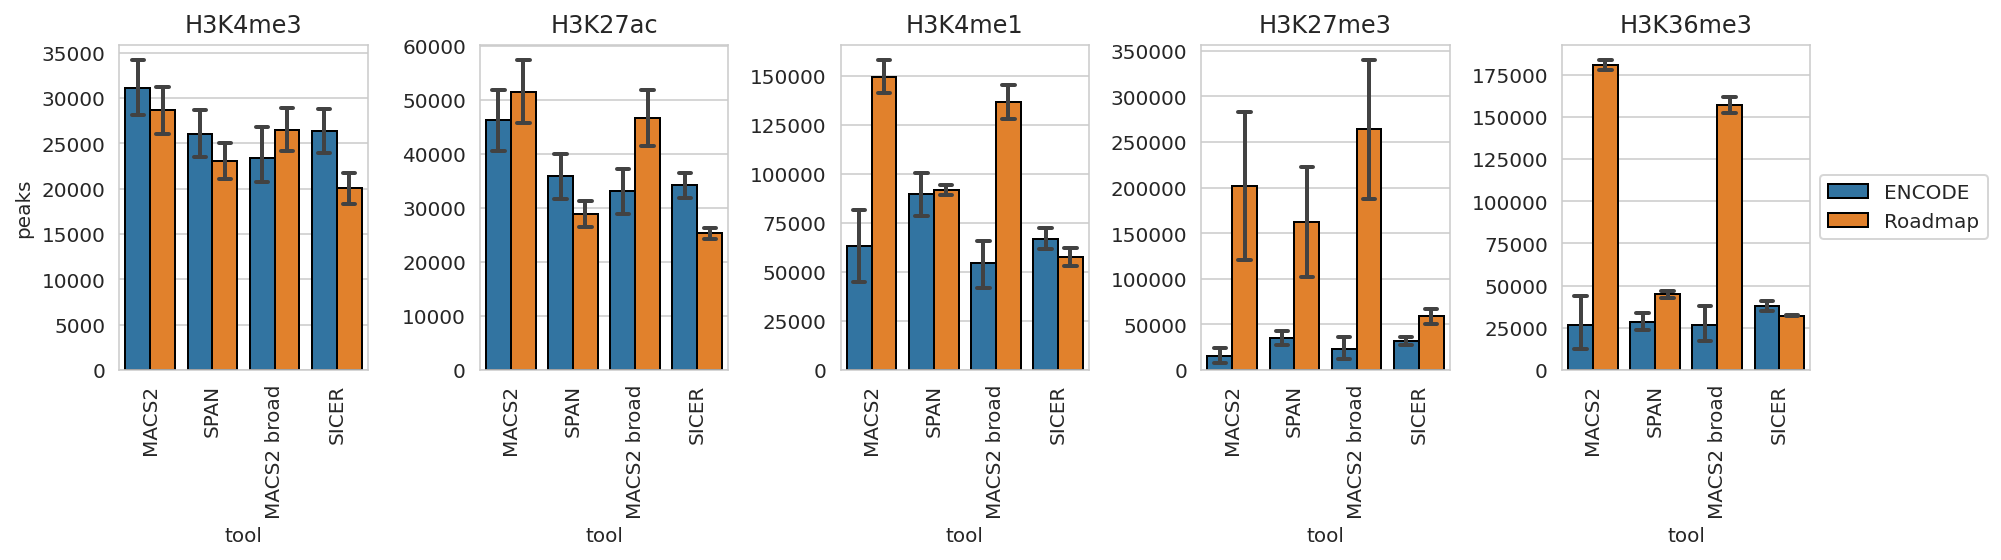

In [11]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'SPAN', 'MACS2 broad', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [12]:
df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1']) & 
          (df_peaks['replicate'].isin(['rep1', '']))) & 
         ((df_peaks['peaks'] > 100_000) | (df_peaks['peaks'] < 10_000))]

file modification   cell  \
25   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   NHEK   
57   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   K562   
261  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1   NHEK   
340  /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1  TCell   
343  /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K4me1  BCell   
351  /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K4me1  BCell   
359  /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1  TCell   

    replicate   peaks         tool  dataset  
25       rep1  110303        MACS2   ENCODE  
57       rep1  119713        MACS2   ENCODE  
261      rep1  107773         SPAN   ENCODE  
340            158205        MACS2  Roadmap  
343            141414        MACS2  Roadmap  
351            127965  MACS2 broad  Roadmap  
359            145437  MACS2 broad  Roadmap

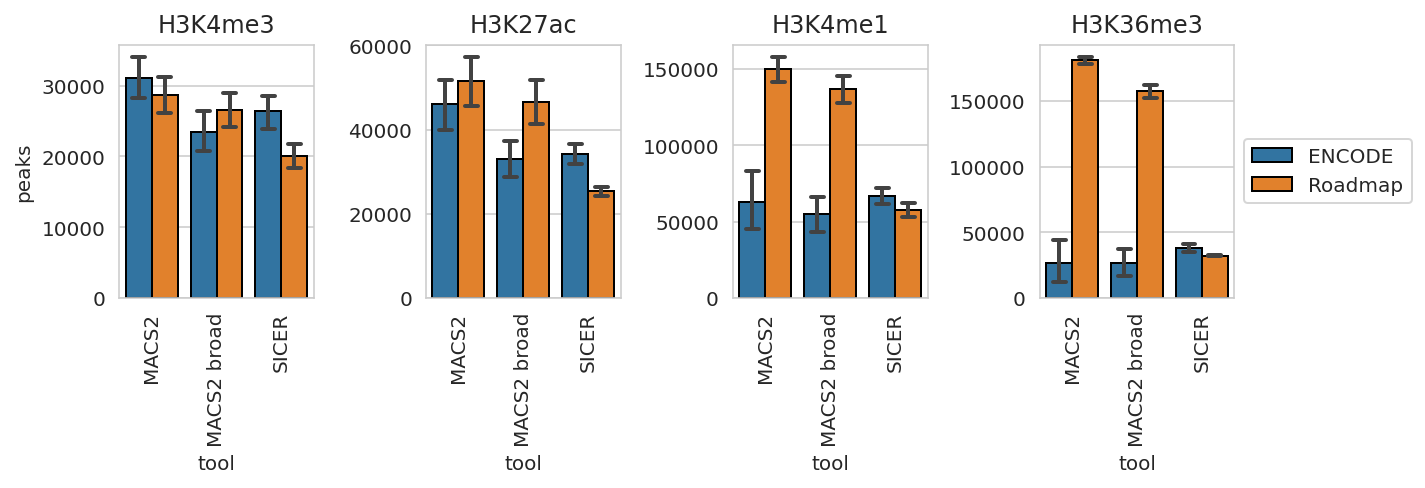

In [13]:
plt.figure(figsize=(10, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

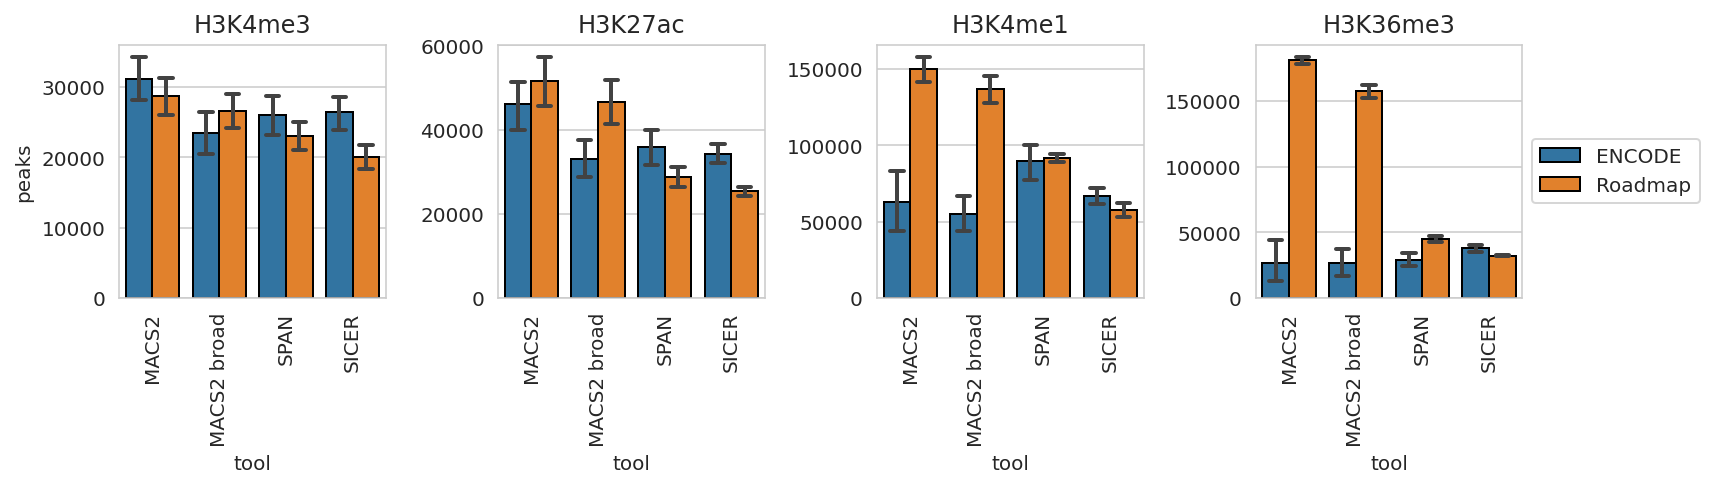

In [14]:
plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [15]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length  dataset modification     cell replicate         tool
704890     307.0   ENCODE     H3K27me3     NHEK      rep1        MACS2
1305589    955.0   ENCODE      H3K27ac    Huvec      rep2  MACS2 broad
2435820  17453.0   ENCODE     H3K36me3  GM12878      rep2         SPAN
171825    2019.0   ENCODE      H3K4me3     K562      rep1        MACS2
435723     326.0   ENCODE     H3K27me3     NHEK      rep2        MACS2
2332423   2379.0   ENCODE      H3K4me3       H1      rep2         SPAN
2701814  19500.0   ENCODE     H3K27me3     NHEK      rep2         SPAN
2539084   9341.0   ENCODE     H3K27me3     HSMM      rep2         SPAN
3353344    291.0  Roadmap      H3K4me1    TCell            MACS2 broad
474192     297.0   ENCODE     H3K27me3    HepG2      rep1        MACS2

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


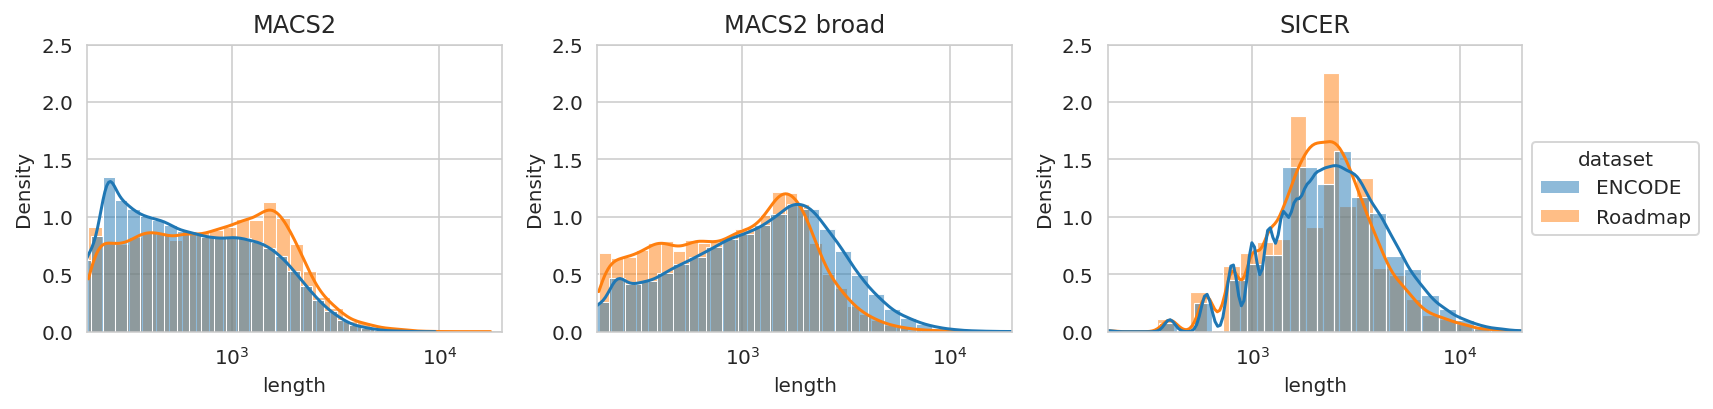

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


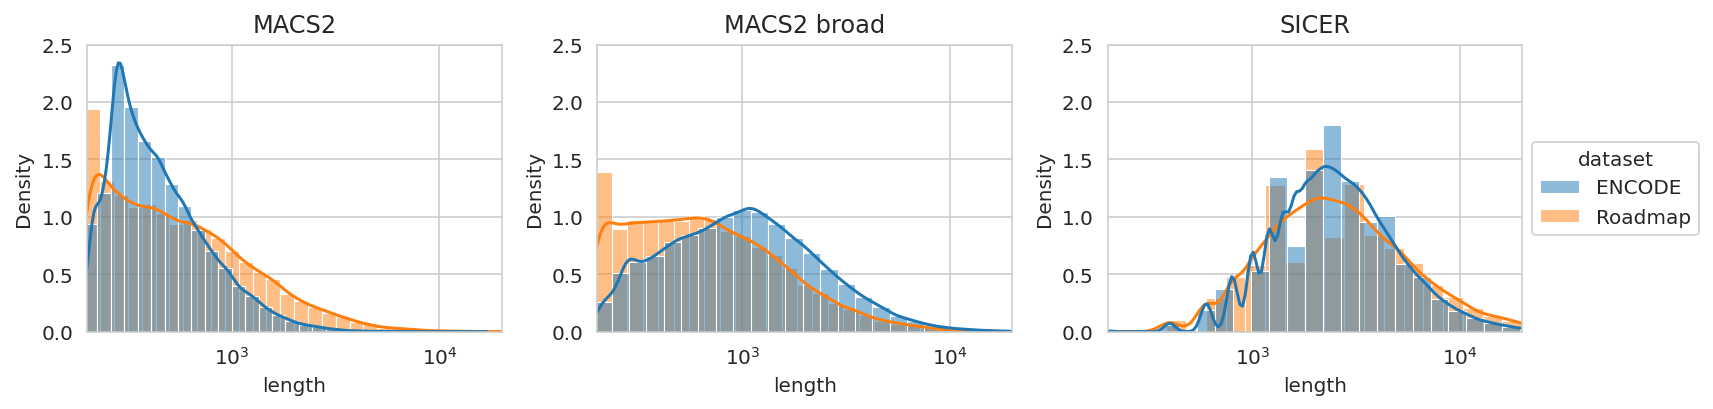

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


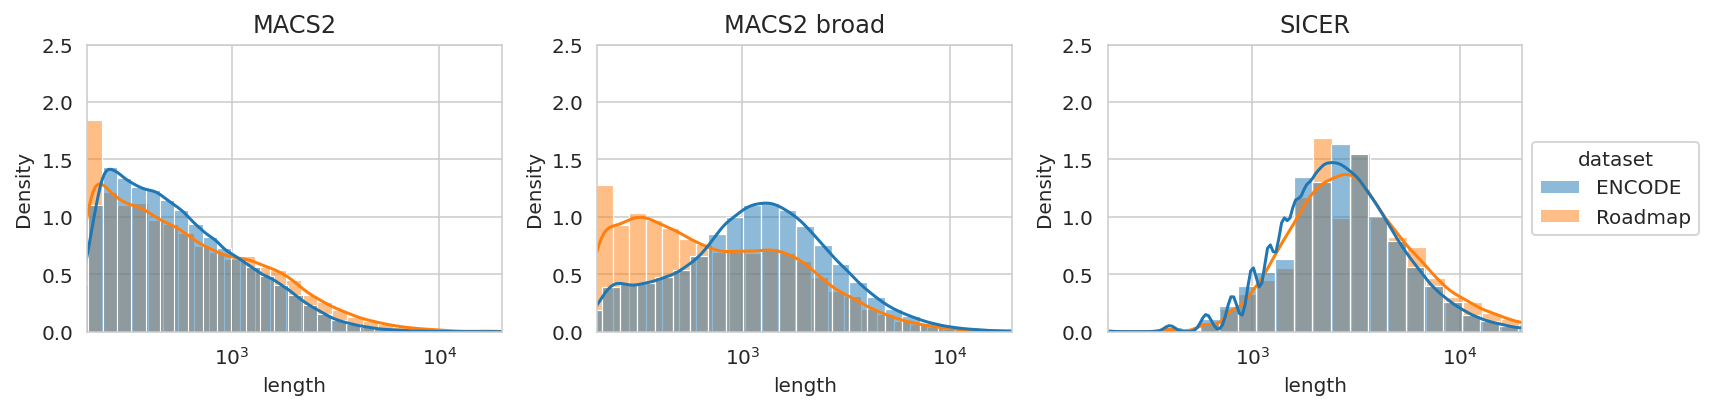

H3K36me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


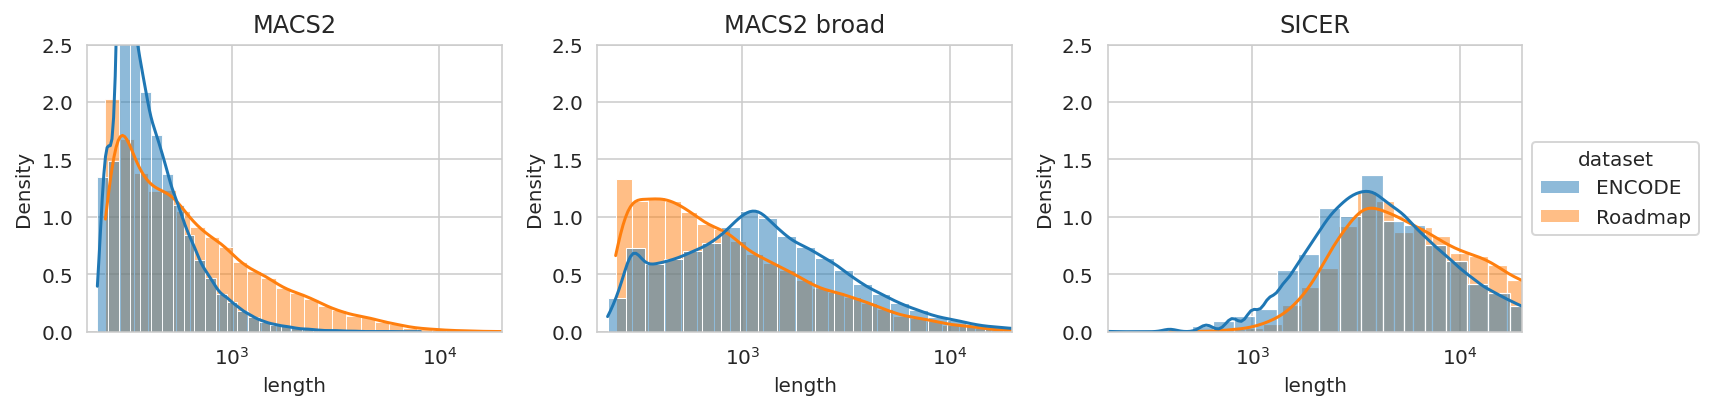

In [16]:
for m in ['H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='dataset', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 # palette=TOOLS_PALETTE,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K36me3


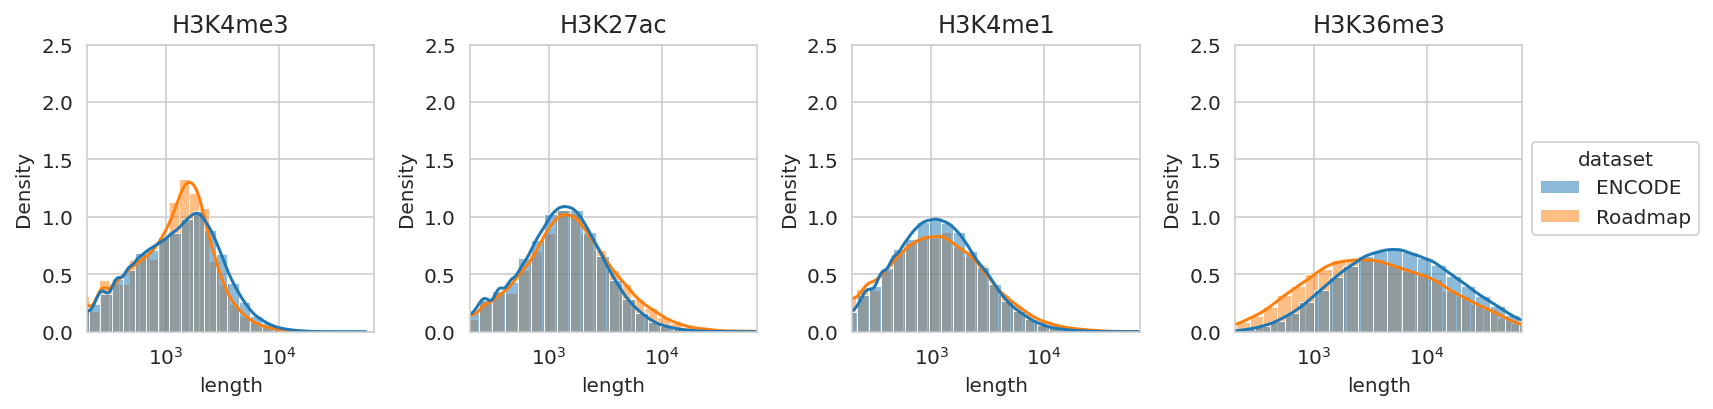

In [17]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # palette=TOOLS_PALETTE,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 7e4)
    ax.title.set_text(m)
    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

In [18]:
t_aggr = t[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
t_aggr.sample(3)

dataset modification     cell replicate         tool       length
73    ENCODE     H3K27me3  GM12878      rep2  MACS2 broad   522.441751
156   ENCODE     H3K36me3     HMEC      rep2        SICER  9246.500000
366  Roadmap      H3K4me3    BCell                  MACS2  1041.318200

H3K4me3
H3K27ac
H3K4me1
H3K36me3


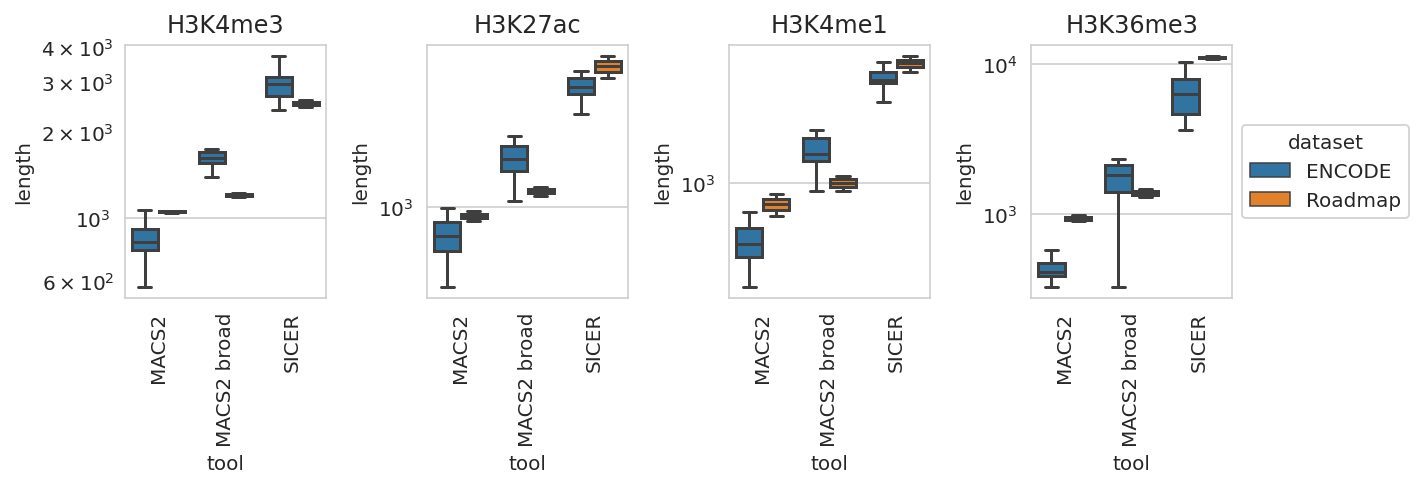

In [19]:
plt.figure(figsize=(10, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.boxplot(data=t_aggr[t_aggr['modification'] == m],
                            x='tool', y='length', ax=ax, hue='dataset',
                            showfliers=False,
                            # capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    ax.set(yscale='log')

    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, )
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Load downsampled peaks

In [20]:
# NOISE_PATH = os.path.expanduser('~/data/2023_Immune_noise')
NOISE_PATH = os.path.expanduser('~/data/2023_Immune_mln_control')

In [21]:
df_peaks_noise = load_peaks_path(NOISE_PATH, MODIFICATIONS, IMMUNE_CELLS, [''])
df_peaks_noise['quality'] = 0
for mln in [15, 10, 5, 2, 1]:
    df_peaks_noise.loc[[f'_{mln}mln' in file for file in df_peaks_noise['file']], 'quality'] = mln
df_peaks_noise.sample(3)

  0%|          | 0/352 [00:00<?, ?it/s]

MACS2 32


  0%|          | 0/352 [00:00<?, ?it/s]

MACS2 broad 32


  0%|          | 0/352 [00:00<?, ?it/s]

SICER 32


  0%|          | 0/45 [00:00<?, ?it/s]

SPAN 32


file modification   cell  \
13   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  TCell   
107  /home/jetbrains/data/2023_Immune_mln_control/s...      H3K4me3  BCell   
65   /home/jetbrains/data/2023_Immune_mln_control/s...      H3K27ac  BCell   

    replicate  peaks   tool  quality  
13             27685  MACS2       10  
107            15704   SPAN        5  
65             15565  SICER        2

In [22]:
t1 = df_peaks_noise[df_peaks_noise['quality'] == 10].copy()
t1['reads'] = 10
t2 = df_immune_peaks.copy()
t2['reads'] = 20
df_downsample = pd.concat([t1, t2]).reset_index(drop=True)
df_downsample['reads'] = df_downsample['reads'].astype(str) + 'M'

df_downsample

file modification   cell  \
0   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  BCell   
1   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  BCell   
2   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  TCell   
3   /home/jetbrains/data/2023_Immune_mln_control/m...     H3K36me3  BCell   
4   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  TCell   
..                                                ...          ...    ...   
67  /home/jetbrains/data/2023_Immune/span/TCell_H3...     H3K27me3  TCell   
68  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K36me3  BCell   
69  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K27ac  BCell   
70  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K4me1  BCell   
71  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K4me3  TCell   

   replicate   peaks   tool  quality reads  dataset  
0             112650  MACS2     10.0   10M      NaN  
1              23702  MACS2     10.0   10M      NaN  
2              27685  MACS2     10.0   10M      NaN  
3             137165  MACS2     10.0   10M      NaN  
4             124685  MACS2     10.0   10M      NaN  
..       ...     ...    ...      ...   ...      ...  
67            222162   SPAN      NaN   20M  Roadmap  
68             42693   SPAN      NaN   20M  Roadmap  
69             26454   SPAN      NaN   20M  Roadmap  
70             89375   SPAN      NaN   20M  Roadmap  
71             25006   SPAN      NaN   20M  Roadmap  

[72 rows x 9 columns]

H3K27ac
H3K4me1


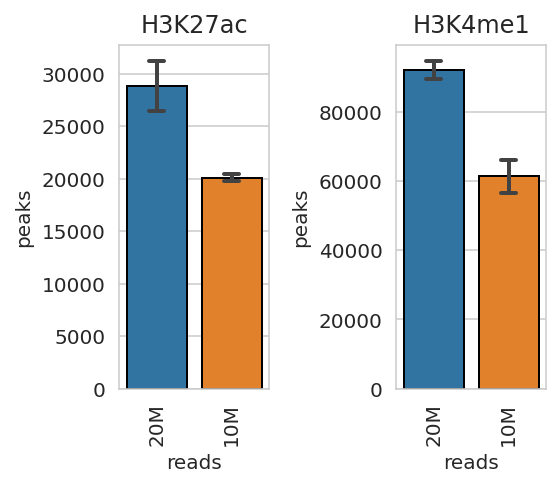

In [22]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[(df_downsample['modification'] == m) & 
                                               (df_downsample['tool'] == 'SPAN')],
                            x='reads', y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['20M', '10M'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


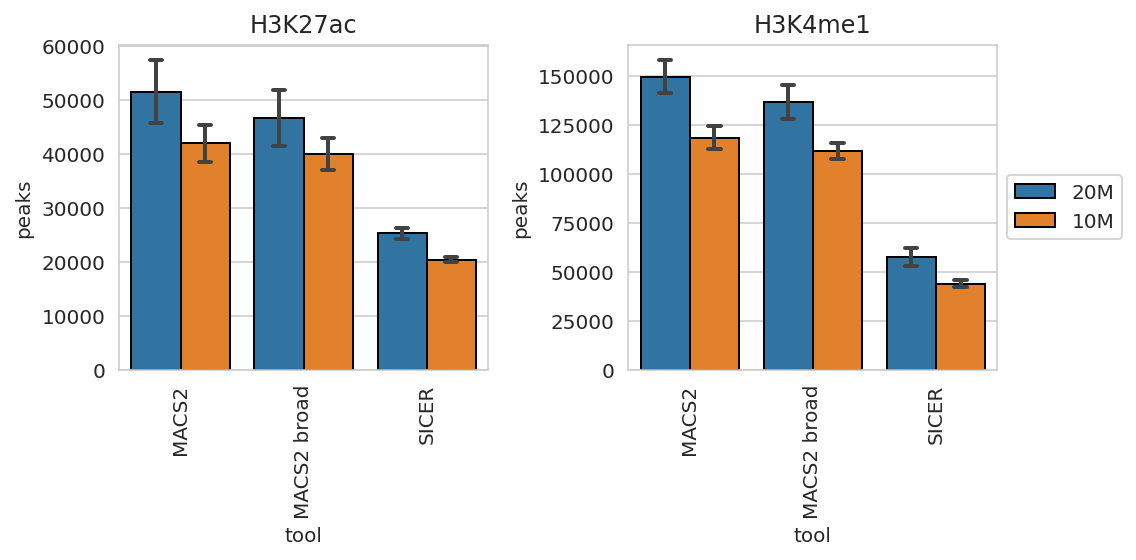

In [23]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[df_downsample['modification'] == m],
                            hue='reads', x='tool', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            hue_order=['20M', '10M'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)
    if i != 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [24]:
df_downsample_fc = pd.DataFrame(columns=['modification', 'cell', 'replicate', 'tool', 
                                         'peaks20M', 'peaks10M', 'fold-change'])
t = df_downsample[df_downsample['reads'] == '20M']
for m, c, r, to, p in tqdm(zip(t['modification'], t['cell'], t['replicate'], t['tool'], t['peaks'])):
    print(m, c, r, to, p)
    t10 = df_downsample[(df_downsample['reads'] == '10M') &
                        (df_downsample['modification'] == m) &
                        (df_downsample['cell'] == c) &
                        (df_downsample['replicate'] == r) &
                        (df_downsample['tool'] == to)]
    if len(t10) == 0:
        continue
    p10 = t10['peaks'].values[0]
    df_downsample_fc.loc[len(df_downsample_fc)] = (m, c, r, to, p, p10, d(p10, p))
df_downsample_fc.sample(3)

0it [00:00, ?it/s]

H3K4me1 TCell  MACS2 158205
H3K27me3 BCell  MACS2 120947
H3K27me3 TCell  MACS2 283089
H3K4me1 BCell  MACS2 141414
H3K27ac TCell  MACS2 57350
H3K4me3 TCell  MACS2 31242
H3K36me3 TCell  MACS2 183613
H3K4me3 BCell  MACS2 26066
H3K27ac BCell  MACS2 45626
H3K36me3 BCell  MACS2 177956
H3K27ac TCell  MACS2 broad 51740
H3K4me1 BCell  MACS2 broad 127965
H3K27ac BCell  MACS2 broad 41460
H3K27me3 TCell  MACS2 broad 339795
H3K36me3 BCell  MACS2 broad 152502
H3K27me3 BCell  MACS2 broad 187656
H3K4me3 BCell  MACS2 broad 24118
H3K36me3 TCell  MACS2 broad 161765
H3K4me3 TCell  MACS2 broad 28929
H3K4me1 TCell  MACS2 broad 145437
H3K4me3 TCell  SICER 21785
H3K36me3 BCell  SICER 31862
H3K27ac TCell  SICER 26338
H3K27me3 BCell  SICER 50127
H3K4me1 BCell  SICER 62076
H3K27me3 TCell  SICER 67477
H3K36me3 TCell  SICER 32491
H3K27ac BCell  SICER 24342
H3K4me3 BCell  SICER 18342
H3K4me1 TCell  SICER 53056
H3K27ac TCell  SPAN 31192
H3K36me3 TCell  SPAN 47042
H3K27me3 BCell  SPAN 102270
H3K4me3 BCell  SPAN 21067

modification   cell replicate         tool  peaks20M  peaks10M  fold-change
21      H3K27ac  BCell                  SICER     24342     19973     0.820516
28     H3K36me3  BCell                   SPAN     42693     36471     0.854262
14      H3K4me3  TCell            MACS2 broad     28929     25336     0.875799

H3K27ac
H3K4me1


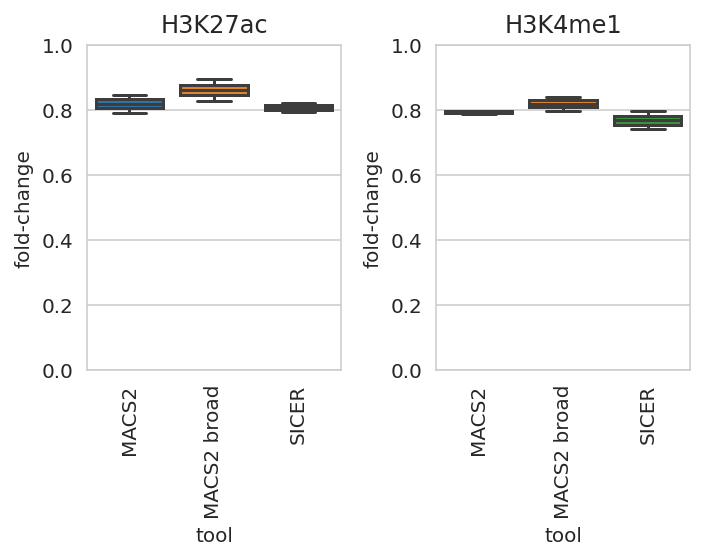

In [25]:
plt.figure(figsize=(5, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.boxplot(data=df_downsample_fc[df_downsample_fc['modification'] == m],
                            x='tool', y='fold-change', ax=ax,
                            # capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)
    # if i != 1:
    #     ax.legend().set_visible(False)
    # else:
        # Put a legend to the right of the current axis
        # g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [26]:
print('Load lengths')
ts = []
for mod, signal_reads, file, tool in tqdm(zip(
        df_downsample['modification'], df_downsample['reads'], df_downsample['file'], df_downsample['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['modification'] = mod
    t['reads'] = signal_reads
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length modification reads         tool
348178     268     H3K27me3   20M        MACS2
490691     697     H3K36me3   20M  MACS2 broad
559396    4599     H3K27me3   20M        SICER
406821     359      H3K27ac   20M        MACS2
36947     1875     H3K36me3   10M        MACS2
146588     421      H3K27ac   10M  MACS2 broad
392489     776      H3K4me3   20M        MACS2
239958    4399      H3K27ac   10M        SICER
464874     274     H3K36me3   20M  MACS2 broad
559056   28799     H3K27me3   20M        SICER

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


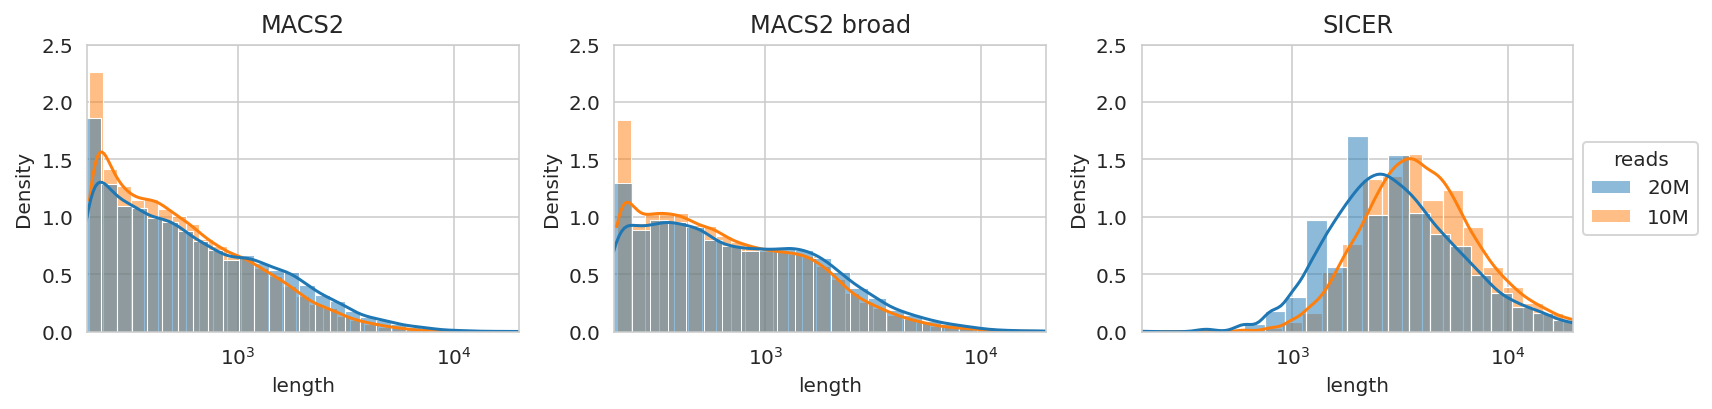

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


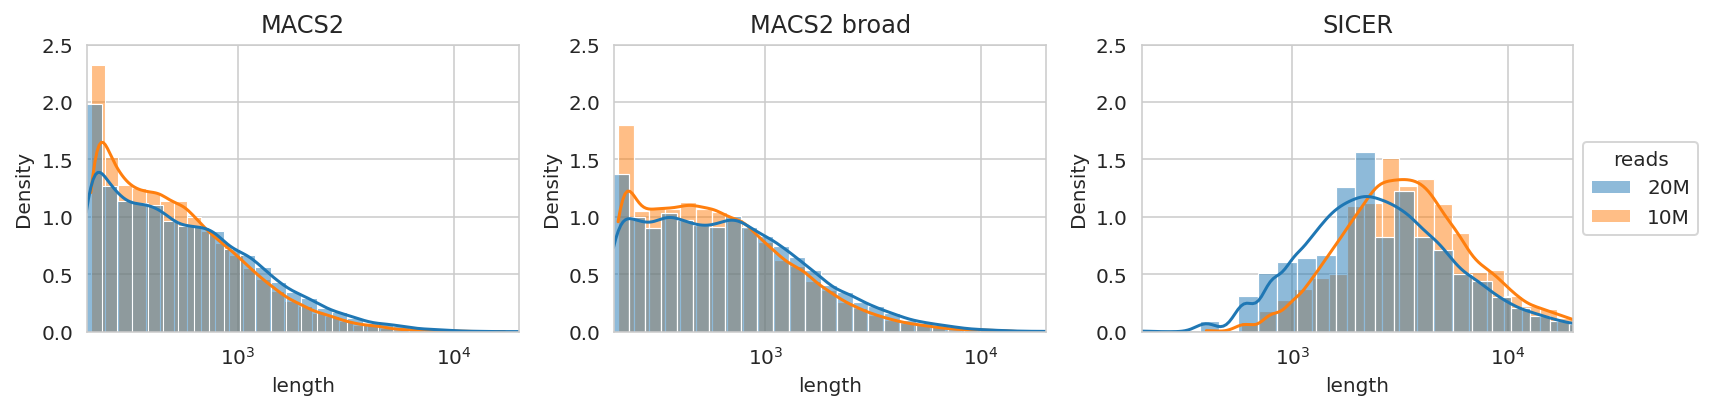

In [27]:
palette = plt.cm.get_cmap('tab10')
READS_PALETTE = {'20M': palette(0), '10M': palette(1)}

t['dataset'] = t['modification'] + ' ' + t['reads']

for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='reads', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 hue_order=['20M', '10M'],
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.tight_layout()
    plt.show()


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


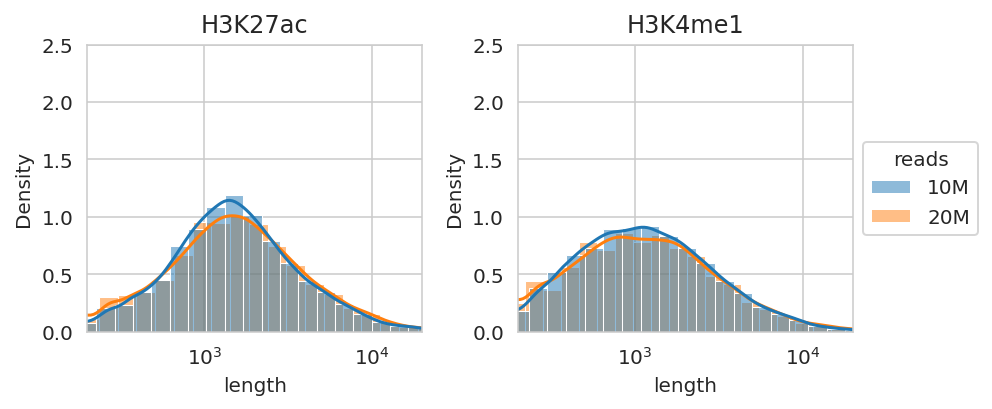

In [28]:
palette = plt.cm.get_cmap('tab10')
READS_PALETTE = {'20M': palette(0), '10M': palette(1)}

t['dataset'] = t['modification'] + ' ' + t['reads']

plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='reads', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # hue_order=['20M', '10M'],
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


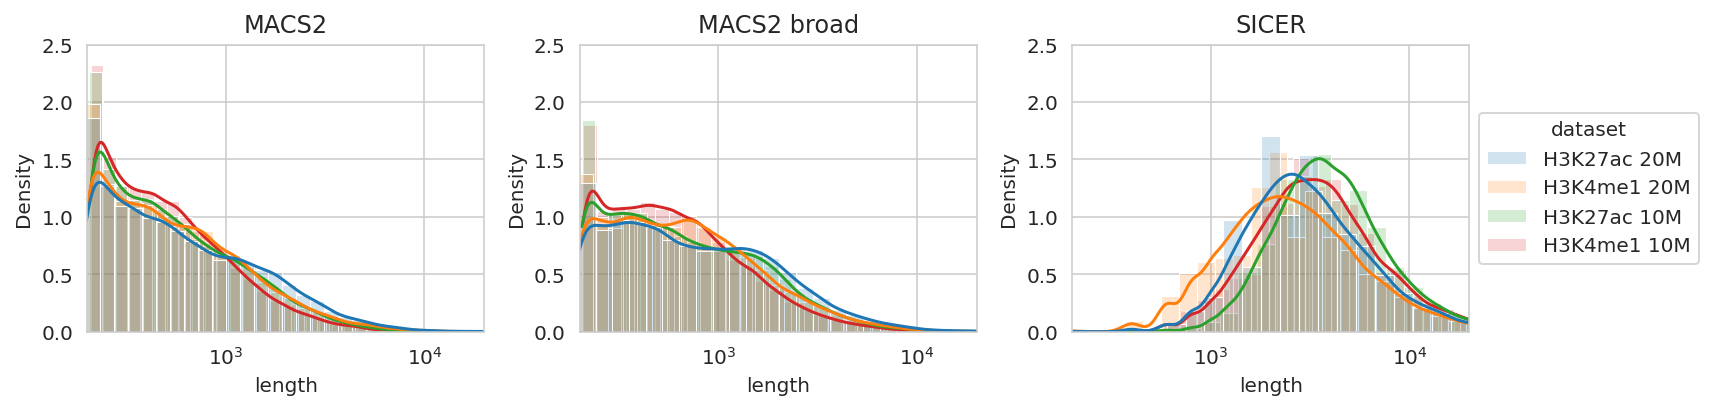

In [29]:
t['dataset'] = t['modification'] + ' ' + t['reads']

plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(
        data=t[((t['modification'] == 'H3K27ac') | (t['modification'] == 'H3K4me1')) & (t['tool'] == tool)],
        x='length', hue='dataset', ax=ax,
        stat='density', common_bins=False, common_norm=False,
        bins=30, kde=True, log_scale=True, alpha=0.2,
        hue_order=['H3K27ac 20M', 'H3K4me1 20M', 'H3K27ac 10M', 'H3K4me1 10M'],
        # palette=READS_PALETTE,
        )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 2:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


## Jaccard original vs downsampled

In [30]:
df_downsample

file modification   cell  \
0   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  BCell   
1   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  BCell   
2   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  TCell   
3   /home/jetbrains/data/2023_Immune_mln_control/m...     H3K36me3  BCell   
4   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  TCell   
..                                                ...          ...    ...   
67  /home/jetbrains/data/2023_Immune/span/TCell_H3...     H3K27me3  TCell   
68  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K36me3  BCell   
69  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K27ac  BCell   
70  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K4me1  BCell   
71  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K4me3  TCell   

   replicate   peaks   tool  quality reads  dataset  
0             112650  MACS2     10.0   10M      NaN  
1              23702  MACS2     10.0   10M      NaN  
2              27685  MACS2     10.0   10M      NaN  
3             137165  MACS2     10.0   10M      NaN  
4             124685  MACS2     10.0   10M      NaN  
..       ...     ...    ...      ...   ...      ...  
67            222162   SPAN      NaN   20M  Roadmap  
68             42693   SPAN      NaN   20M  Roadmap  
69             26454   SPAN      NaN   20M  Roadmap  
70             89375   SPAN      NaN   20M  Roadmap  
71             25006   SPAN      NaN   20M  Roadmap  

[72 rows x 9 columns]

In [ ]:
bench_df = pd.DataFrame(
    columns=['modification', 'cell', 'replicate', 'name', 'quality',
             'original_peaks', 'original_peaks_len',
             'peaks', 'peaks_len', 'overlap1', 'overlap2', 'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for m, c, r, tool in tqdm(product(['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], TOOLS)):
    print(m, c, r, tool)
    t = df_downsample[
        (df_downsample['modification'] == m) &
        (df_downsample['cell'] == c) &
        (df_downsample['replicate'] == r) &
        (df_downsample['tool'] == tool) &
        (df_downsample['reads'] == '20M')]
    if len(t) == 0:
        print('-')
        continue
    original_file = sorted_file(t['file'].values[0])
    original_peaks = lines(original_file)
    original_peaks_len = int(bedl(original_file).sum())
    t = df_downsample[
        (df_downsample['modification'] == m) &
        (df_downsample['cell'] == c) &
        (df_downsample['replicate'] == r) &
        (df_downsample['tool'] == tool) &
        (df_downsample['reads'] == '10M')]
    if len(t) == 0:
        continue
    file = sorted_file(t['file'].values[0])
    peaks_len = int(bedl(file).sum())
    !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
    overlap1 = lines(tf)
    !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
    overlap2 = lines(tf)
    !bedtools intersect -a {original_file} -b {file} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    bench_df.loc[len(bench_df)] = \
        (m, c, r, tool, '10M',
         original_peaks, original_peaks_len,
         (lines(file)), peaks_len, overlap1, overlap2, overlap_len)

display(bench_df.sample(3))


In [ ]:
bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['original_peaks_len'], bench_df['peaks_len'], bench_df['overlap_len'])
]
bench_df.sample(1)


In [ ]:
plt.figure(figsize=(6, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['modification'] == m],
                            x='name', hue='quality', y='jaccard', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            # hue_order=['wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

## Compute BAM coverage

In [23]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams


In [24]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_encode_bams.sample(3)

  0%|          | 0/206 [00:00<?, ?it/s]

bam_file modification     cell  \
14  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HSMM   
97  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3  GM12878   
29  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HSMM   

   replicate     reads dataset  
14      rep1   8080332  ENCODE  
97      rep2   8126028  ENCODE  
29      rep1  11291330  ENCODE

In [25]:
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, [''], 'Control')
df_immune_bams['dataset'] = 'Roadmap'
df_immune_bams.sample(3)

  0%|          | 0/35 [00:00<?, ?it/s]

bam_file modification   cell  \
9  /home/jetbrains/data/2023_Immune/bams/TCell_H3...     H3K36me3  TCell   
1  /home/jetbrains/data/2023_Immune/bams/BCell_H3...      H3K27ac  BCell   
0  /home/jetbrains/data/2023_Immune/bams/TCell_Co...      Control  TCell   

  replicate     reads  dataset  
9            22349392  Roadmap  
1            21067933  Roadmap  
0            35331343  Roadmap

In [26]:
df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)

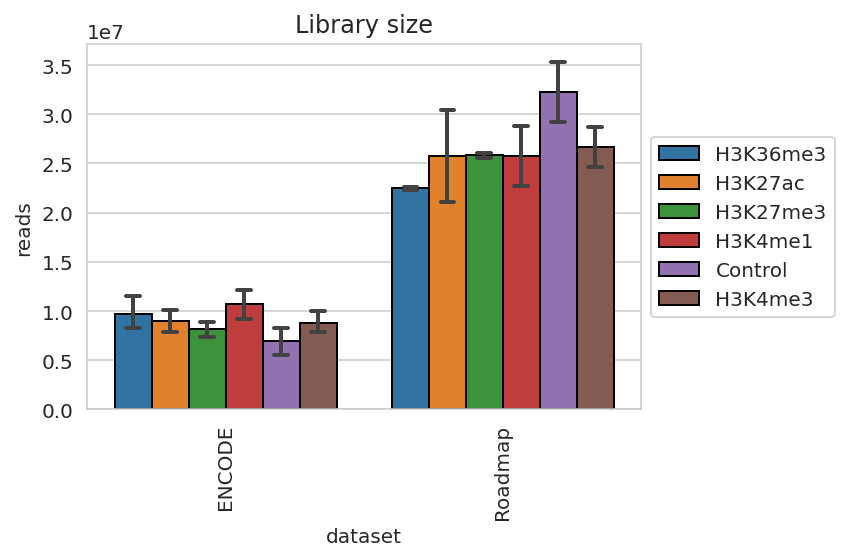

In [27]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams,
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.05, errwidth=2, edgecolor="black",
                        )
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

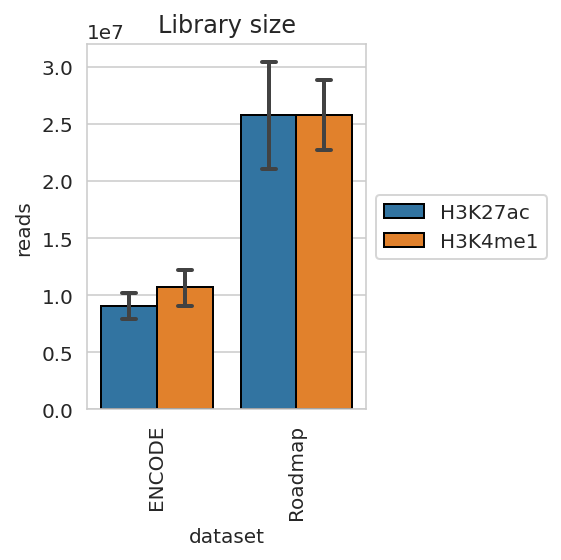

In [28]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams[(df_bams['modification'] == 'H3K27ac') | (df_bams['modification'] == 'H3K4me1')],
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.1, errwidth=2, edgecolor="black",
                        )
# ax.set_ylim(0, 160_000)
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Prepare datasets with wiggling and mixing control data into signal track

In [29]:
# Prepare BAM files

WD = os.path.expanduser('~/data/2023_GSE26320_wiggle_mix')
! mkdir -p {WD}/bed

df_bam_beds = df_bams[(df_bams['modification'].isin(['H3K27ac', 'H3K4me1', 'Control'])) & 
                      # (df_bams['cell'].isin(['GM12878', 'K562', 'Huvec', 'HMEC', 'NHEK'])) & # LIMIT number of peaks
                      # (df_bams['replicate'] == 'rep2') &
                      (df_bams['dataset'] == 'ENCODE')].copy()
df_bam_beds

bam_file modification     cell  \
2    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHEK   
4    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     K562   
5    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     K562   
7    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac    HepG2   
9    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     NHEK   
10   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     HMEC   
12   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HMEC   
13   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  GM12878   
14   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HSMM   
15   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control       H1   
16   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HMEC   
17   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac    Huvec   
18   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  GM12878   
20   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHLF   
22   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac    Huvec   
23   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     NHLF   
25   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1       H1   
26   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac    HepG2   
27   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    Huvec   
28   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHLF   
29   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HSMM   
30   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     HMEC   
35   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    HepG2   
41   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     HSMM   
43   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HMEC   
49   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     NHEK   
51   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac       H1   
53   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    HepG2   
55   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     K562   
56   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1    Huvec   
58   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     K562   
59   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHEK   
63   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     K562   
68   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     K562   
70   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1    HepG2   
71   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHLF   
72   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  GM12878   
73   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HSMM   
74   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  GM12878   
78   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    Huvec   
81   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHLF   
82   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1       H1   
83   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HSMM   
84   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     NHLF   
86   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHEK   
87   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHEK   
88   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control  GM12878   
89   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HMEC   
95   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1    Huvec   
98   /home/jetbrains/data/2023_GSE26320/bams/G

In [30]:
beds = []
for _, (bam_file, m, c, r, _, _) in df_bam_beds.iterrows():
    bed_file = f'{WD}/bed/{os.path.basename(bam_file).replace(".bam", ".bed")}'
    print(bed_file)
    beds.append(bed_file)
    if not os.path.exists(bed_file):
        ! bamToBed -i {bam_file} > {bed_file}
df_bam_beds['bed_file'] = beds
df_bam_beds.sample(3)

/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646456_NHEK_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646441_K562_H3K4me1_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646452_K562_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646356_HepG2_H3K27ac_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646473_NHEK_Input_rep2.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646390_HMEC_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646374_HMEC_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646322_GM12878_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646400_HSMM_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646351_H1_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646380_HMEC_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646414_Huvec_H3K27ac_rep1.bed
/home/jetbrains/data/

bam_file modification   cell  \
87  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1   NHEK   
12  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac   HMEC   
70  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  HepG2   

   replicate     reads dataset  \
87      rep2  10314582  ENCODE   
12      rep1  10940745  ENCODE   
70      rep1  13707399  ENCODE   

                                             bed_file  
87  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...  
12  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...  
70  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...

## Wiggle

In [31]:
! mkdir -p {WD}/bams

tf1 = tempfile.mktemp()
tf2 = tempfile.mktemp()
tf3 = tempfile.mktemp()
tf4 = tempfile.mktemp()

# NUPSCALE = 20
NUPSCALE = 10

# for var_upscale, var_wiggle in tqdm(product([1, 2], [0, 5000])):
for var_upscale, var_wiggle in tqdm(product([2], [0, 2000])):
    if var_upscale == 1 and var_wiggle == 0:
        continue
    var_name = '' if var_upscale == 1 else f'x{var_upscale}_N{NUPSCALE}'
    if var_wiggle != 0:
        if var_name != '':
            var_name += '_'
        var_name += f'w80_20_N{var_wiggle}'
    print('upscale', var_upscale, 'wiggle', var_wiggle, 'Type', var_name)

    wiggles = []
    for _, row in tqdm(df_bam_beds.iterrows()):
        bam_file, m, c, r, bed_file = row['bam_file'], row['modification'], row['cell'], row['replicate'], row['bed_file']
        print(var_name, m, c, r, bed_file)
        if m == 'Control':
            wiggles.append(None)
            ! ln -sf {bam_file} {WD}/bams/{os.path.basename(bam_file)} 
            continue
        cs = 0.8 
        cw = 1.0 - cs    
        print('Signal', cs, 'wiggle', cw)
        result_file = f'{WD}/bams/{m}_{c}_{r}_{var_name}.bam'
        wiggles.append(result_file)
        print(result_file)
        if os.path.exists(result_file):
            continue
        t = pd.read_csv(bed_file, sep='\t', header=None)
        print('Reads', len(t))
    
        if var_upscale != 1:
            print('Upscale coverage')
            if var_upscale == 2:
                t_copy = t.copy()  # Double coverage
            elif var_upscale == 1.5:
                t_copy = t.sample(int(len(t) * 0.5)).copy() # +50% coverage
            else:
                raise Exception(f'Unknown var_upscale {var_upscale}')
            delta_small = [int(x) for x in np.random.normal(0, NUPSCALE, size=len(t_copy))]
            t_copy[1] += delta_small
            t_copy[2] += delta_small
            del delta_small
            # Ensure generated reads have proper coordinates
            t_copy.loc[t_copy[1] < 1, 1] = 1
            t_copy.loc[t_copy[2] < 1, 2] = 1
            t = pd.concat([t, t_copy]).reset_index(drop=True) 
            print('Upscaled coverage', len(t))
        
        if var_wiggle != 0:
            print('wiggle')
            signal = t.sample(int(len(t) * cs))
            noise = t.sample(int(len(t) * cw))
            delta = [int(x) for x in np.random.normal(0, var_wiggle, size=len(noise))]
            noise[1] += delta
            noise[2] += delta
            # Ensure generated reads have proper coordinates
            noise.loc[noise[1] < 1, 1] = 1
            noise.loc[noise[2] < 1, 2] = 1
            signal.to_csv(tf1, sep='\t', index=False, header=None)
            noise.to_csv(tf2, sep='\t', index=False, header=None)
            del t, signal, noise, delta
            ! cat {tf1} > {tf3}
            ! cat {tf2} >> {tf3}
            ! rm {tf1} {tf2}
        else:
            t.to_csv(tf3, sep='\t', index=False, header=None)
            del t
        ! cat {tf3} | sort -k1,1 -k2,2n -k3,3n > {tf4}
        ! rm {tf3}
        ! bedToBam -i {tf4} -g {WD}/hg38.chrom.sizes > {result_file}
        ! rm {tf4}
        print('Done', result_file)
    df_bam_beds[var_name] = wiggles
df_bam_beds.sample(3)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


0it [00:00, ?it/s]

upscale 2 wiggle 0 Type x2_N10


0it [00:00, ?it/s]

x2_N10 H3K27ac NHEK rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646456_NHEK_H3K27ac_rep1.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHEK_rep1_x2_N10.bam
x2_N10 H3K4me1 K562 rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646441_K562_H3K4me1_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_K562_rep2_x2_N10.bam
x2_N10 Control K562 rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646452_K562_Input_rep1.bed
ln: failed to create symbolic link '/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/GSM646452_K562_Input_rep1.bam': No space left on device
x2_N10 H3K27ac HepG2 rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646356_HepG2_H3K27ac_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HepG2_rep2_x2_N10.bam
x2_N10 Control NHEK rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed

0it [00:00, ?it/s]

x2_N10_w80_20_N2000 H3K27ac NHEK rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646456_NHEK_H3K27ac_rep1.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHEK_rep1_x2_N10_w80_20_N2000.bam
x2_N10_w80_20_N2000 H3K4me1 K562 rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646441_K562_H3K4me1_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_K562_rep2_x2_N10_w80_20_N2000.bam
x2_N10_w80_20_N2000 Control K562 rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646452_K562_Input_rep1.bed
ln: failed to create symbolic link '/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/GSM646452_K562_Input_rep1.bam': No space left on device
x2_N10_w80_20_N2000 H3K27ac HepG2 rep2 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646356_HepG2_H3K27ac_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HepG2_rep2_x2_N10_

bam_file modification  cell  \
100  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    H1   
20   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  NHLF   
29   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  HSMM   

    replicate     reads dataset  \
100      rep2   2998695  ENCODE   
20       rep2   7681380  ENCODE   
29       rep1  11291330  ENCODE   

                                              bed_file  \
100  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
20   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
29   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   

                                                x2_N10  \
100                                               None   
20   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
29   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   

                                   x2_N10_w80_20_N2000  
100                                               None  
20   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...  
29   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...

## Mix control

In [32]:
# mixtures = []
# for _, row in tqdm(df_bam_beds.iterrows()):
#     bam_file, m, c, r, bed_file = row['bam_file'], row['modification'], row['cell'], row['replicate'], row['bed_file']
#     if m == 'Control':
#         mixtures.append(None)
#         continue
#     print('Mix', m, c, r)
#     result_file = f'{WD}/bams/{m}_{c}_{r}_mix.bam'
#     mixtures.append(result_file)
#     print(result_file)
#     if os.path.exists(result_file):
#         continue
#     control_file = df_bam_beds[(df_bam_beds['cell'] == c) & 
#                                (df_bam_beds['replicate'] == r) & 
#                                (df_bam_beds['modification'] == 'Control')]['bed_file'].values[0]
#     signal = pd.read_csv(bed_file, sep='\t', header=None)
#     noise = pd.read_csv(control_file, sep='\t', header=None)
#     signal_reads = len(signal)
#     control_reads = len(noise)
#     print('Signal', bed_file, signal_reads)
#     print('Control', control_file, control_reads)
#     signal = signal.sample(int(signal_reads * 0.5))
#     noise = noise.sample(min(signal_reads, int(control_reads * 0.5)))
#     signal.to_csv(tf1, sep='\t', index=False, header=None)
#     noise.to_csv(tf2, sep='\t', index=False, header=None)
#     ! cat {tf1} > {tf3}
#     ! cat {tf2} >> {tf3}
#     ! rm {tf1} {tf2}
#     ! cat {tf3} | sort -k1,1 -k2,2n -k3,3n > {tf4}
#     ! rm {tf3}
#     ! bedToBam -i {tf4} -g {WD}/hg38.chrom.sizes > {result_file}
#     ! rm {tf4}
#     del signal, noise
#     print('Done')
# 
# df_bam_beds['mix'] = mixtures 
# df_bam_beds.sample(3)

## Estimate generated BAMs

In [33]:
df_wiggle_bams = load_bams(WD + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
df_wiggle_bams.sample(3)

  0%|          | 0/172 [00:00<?, ?it/s]

bam_file modification   cell  \
32  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  HepG2   
60  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   NHLF   
5   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     H1   

   replicate     reads  
32      rep1  27414797  
60      rep2  28080926  
5       rep1  16886889

In [34]:
df_wiggle_bams['type'] = [re.sub('.*rep[12]_|\.bam|_q.*|-W.*|_broad.*|_100_.*', '', os.path.basename(f)) for f in df_wiggle_bams['bam_file']]
df_wiggle_bams['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in df_wiggle_bams['type']]
df_wiggle_bams['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in df_wiggle_bams['type']]
# # Limit to x2_N20 and wiggle 5000
# df_wiggle_bams = df_wiggle_bams[(df_wiggle_bams['upscale'] != 1.5) &
#                                 (~df_wiggle_bams['type'].str.contains('N100')) &
#                                 (df_wiggle_bams['wiggle'] != 2000)]

df_wiggle_bams

bam_file modification     cell  \
0   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     K562   
1   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HSMM   
2   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHEK   
3   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HSMM   
4   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
..                                                ...          ...      ...   
63  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
64  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHLF   
65  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHLF   
66  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
67  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HMEC   

   replicate     reads                 type  upscale  wiggle  
0       rep2  12360187  x2_N10_w80_20_N2000      2.0  2000.0  
1       rep1  16160664               x2_N10      2.0     NaN  
2       rep1  18755229  x2_N10_w80_20_N2000      2.0  2000.0  
3       rep2  16416791  x2_N10_w80_20_N2000      2.0  2000.0  
4       rep1  20920470               x2_N10      2.0     NaN  
..       ...       ...                  ...      ...     ...  
63      rep2  11566223  x2_N10_w80_20_N2000      2.0  2000.0  
64      rep2  15362759  x2_N10_w80_20_N2000      2.0  2000.0  
65      rep2  15362760               x2_N10      2.0     NaN  
66      rep1   9108455  x2_N10_w80_20_N2000      2.0  2000.0  
67      rep2  19721374               x2_N10      2.0     NaN  

[68 rows x 8 columns]

In [35]:
df_immune_10m_bams = load_bams(IMMUNE_PATH + '_mln_control/bams', ['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], None)
df_immune_10m_bams.sample(3)

  0%|          | 0/10 [00:00<?, ?it/s]

bam_file modification   cell  \
2  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  TCell   
0  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  BCell   
3  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  BCell   

  replicate     reads  
2            10002191  
0             9998693  
3             9999314

In [36]:
t = df_wiggle_bams.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
t['scale'] = t['upscale']

t2 = df_bams[df_bams['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t2['scale'] = [0.5 if ds == 'ENCODE' else 2.5 for ds in t2['dataset']]
t2['wiggle'] = 0.0

t3 = df_immune_10m_bams.copy()
t3['scale'] = 2.2
t3['wiggle'] = 0.0

t = pd.concat([t, t2, t3]).reset_index(drop=True)

H3K27ac
H3K4me1


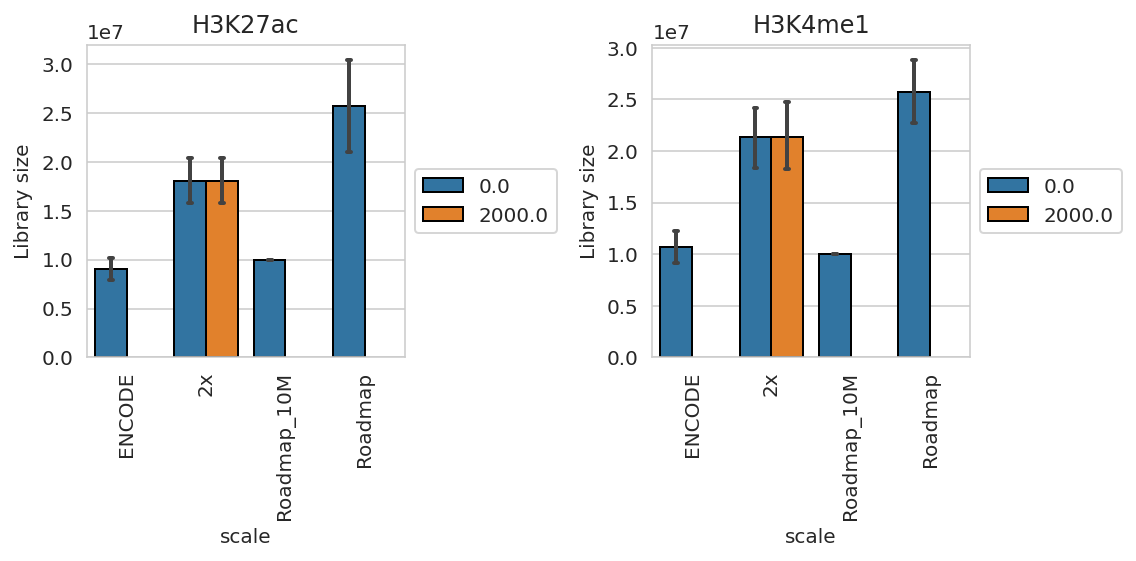

In [37]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]

    g_results = sns.barplot(data=t[t['modification'] == m],
                            hue='wiggle', x='scale', y='reads', ax=ax,
                            capsize=.05, errwidth=2, edgecolor="black",
                        )
    # ax.set_xticklabels(['ENCODE',  '1x', '1.5x', '2x', 'Roadmap_10M', 'Roadmap'])
    ax.set_xticklabels(['ENCODE', '2x', 'Roadmap_10M', 'Roadmap'])
    ax.set_title(m)
    ax.set_ylabel('Library size')
    # Put a legend to the right of the current axis
    g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=True sicer=True --rerun-trigger mtime && \
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 

```

# Analyze wiggle and scaling

In [38]:
wiggle_mix_peaks = load_peaks_path(WD, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)

  0%|          | 0/544 [00:00<?, ?it/s]

MACS2 68


  0%|          | 0/544 [00:00<?, ?it/s]

MACS2 broad 68


  0%|          | 0/68 [00:00<?, ?it/s]

SICER 68


  0%|          | 0/69 [00:00<?, ?it/s]

SPAN 68


In [39]:
wiggle_mix_peaks['type'] = [re.sub('.*rep[12]_|_q.*|-W.*|_broad.*|_100_.*', '', os.path.basename(f)) for f in wiggle_mix_peaks['file']]
wiggle_mix_peaks['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in wiggle_mix_peaks['type']]
wiggle_mix_peaks['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in wiggle_mix_peaks['type']]
wiggle_mix_peaks.sample(5)

file modification     cell  \
85   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     K562   
38   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  GM12878   
2    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
260  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HSMM   
113  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHLF   

    replicate  peaks         tool                 type  upscale  wiggle  
85       rep1  59894  MACS2 broad               x2_N10      2.0     NaN  
38       rep2  35862        MACS2               x2_N10      2.0     NaN  
2        rep1  46357        MACS2  x2_N10_w80_20_N2000      2.0  2000.0  
260      rep1  45728         SPAN  x2_N10_w80_20_N2000      2.0  2000.0  
113      rep1  32241  MACS2 broad               x2_N10      2.0     NaN

In [40]:
t = wiggle_mix_peaks.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
t['scale'] = t['upscale']
t2 = df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])) & 
              (df_peaks['dataset'] == 'ENCODE') 
              # & (df_peaks['replicate'] == 'rep1')
].copy()
t2['scale'] = 0.5
t2['upscale'] = 1.0
t2['wiggle'] = 0.0
t2['type'] = 'ENCODE'
wiggle_mix_original_peaks = pd.concat([t2, t]).reset_index(drop=True)
wiggle_mix_original_peaks

file modification     cell  \
0    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac    HepG2   
1    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac  GM12878   
2    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac       H1   
3    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac     NHLF   
4    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac    HepG2   
..                                                 ...          ...      ...   
403  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HSMM   
404  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
405  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
406  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
407  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1       H1   

    replicate   peaks   tool dataset  scale  upscale  wiggle  \
0        rep2   26021  MACS2  ENCODE    0.5      1.0     0.0   
1        rep2   43917  MACS2  ENCODE    0.5      1.0     0.0   
2        rep1   17497  MACS2  ENCODE    0.5      1.0     0.0   
3        rep2   61193  MACS2  ENCODE    0.5      1.0     0.0   
4        rep1   48652  MACS2  ENCODE    0.5      1.0     0.0   
..        ...     ...    ...     ...    ...      ...     ...   
403      rep1   49036   SPAN     NaN    2.0      2.0     0.0   
404      rep1   35061   SPAN     NaN    2.0      2.0     0.0   
405      rep2  137237   SPAN     NaN    2.0      2.0     0.0   
406      rep2   82036   SPAN     NaN    2.0      2.0  2000.0   
407      rep2  120608   SPAN     NaN    2.0      2.0  2000.0   

                    type  
0                 ENCODE  
1                 ENCODE  
2                 ENCODE  
3                 ENCODE  
4                 ENCODE  
..                   ...  
403               x2_N10  
404               x2_N10  
405               x2_N10  
406  x2_N10_w80_20_N2000  
407  x2_N10_w80_20_N2000  

[408 rows x 11 columns]

In [41]:
wiggle_mix_original_peaks['name'] = wiggle_mix_original_peaks['type']
wiggle_mix_original_peaks.loc[wiggle_mix_original_peaks['type'] == 'Roadmap_10M', 'name'] = 'Roadmap Downscale'
wiggle_mix_original_peaks.loc[wiggle_mix_original_peaks['type'] == 'x2_N10', 'name'] = 'ENCODE Upscale'
wiggle_mix_original_peaks.loc[wiggle_mix_original_peaks['type'] == 'x2_N10_w80_20_N2000', 'name'] = 'ENCODE Upscale + Wiggle'

H3K27ac NHEK rep1
H3K27ac HMEC rep1
H3K27ac GM12878 rep1
H3K27ac Huvec rep1
H3K27ac H1 rep1
H3K27ac HSMM rep1
H3K27ac NHLF rep1
H3K27ac K562 rep1
H3K27ac HepG2 rep1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac NHEK rep2
H3K27ac HMEC rep2
H3K27ac GM12878 rep2
H3K27ac Huvec rep2
H3K27ac H1 rep2
H3K27ac HSMM rep2
H3K27ac NHLF rep2
H3K27ac K562 rep2
H3K27ac HepG2 rep2
H3K4me1 NHEK rep1
H3K4me1 HMEC rep1
H3K4me1 GM12878 rep1
H3K4me1 Huvec rep1
H3K4me1 H1 rep1
H3K4me1 HSMM rep1
H3K4me1 NHLF rep1
H3K4me1 K562 rep1
H3K4me1 HepG2 rep1
H3K4me1 NHEK rep2
H3K4me1 HMEC rep2
H3K4me1 GM12878 rep2
H3K4me1 Huvec rep2
H3K4me1 H1 rep2
H3K4me1 HSMM rep2
H3K4me1 NHLF rep2
H3K4me1 K562 rep2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 HepG2 rep2


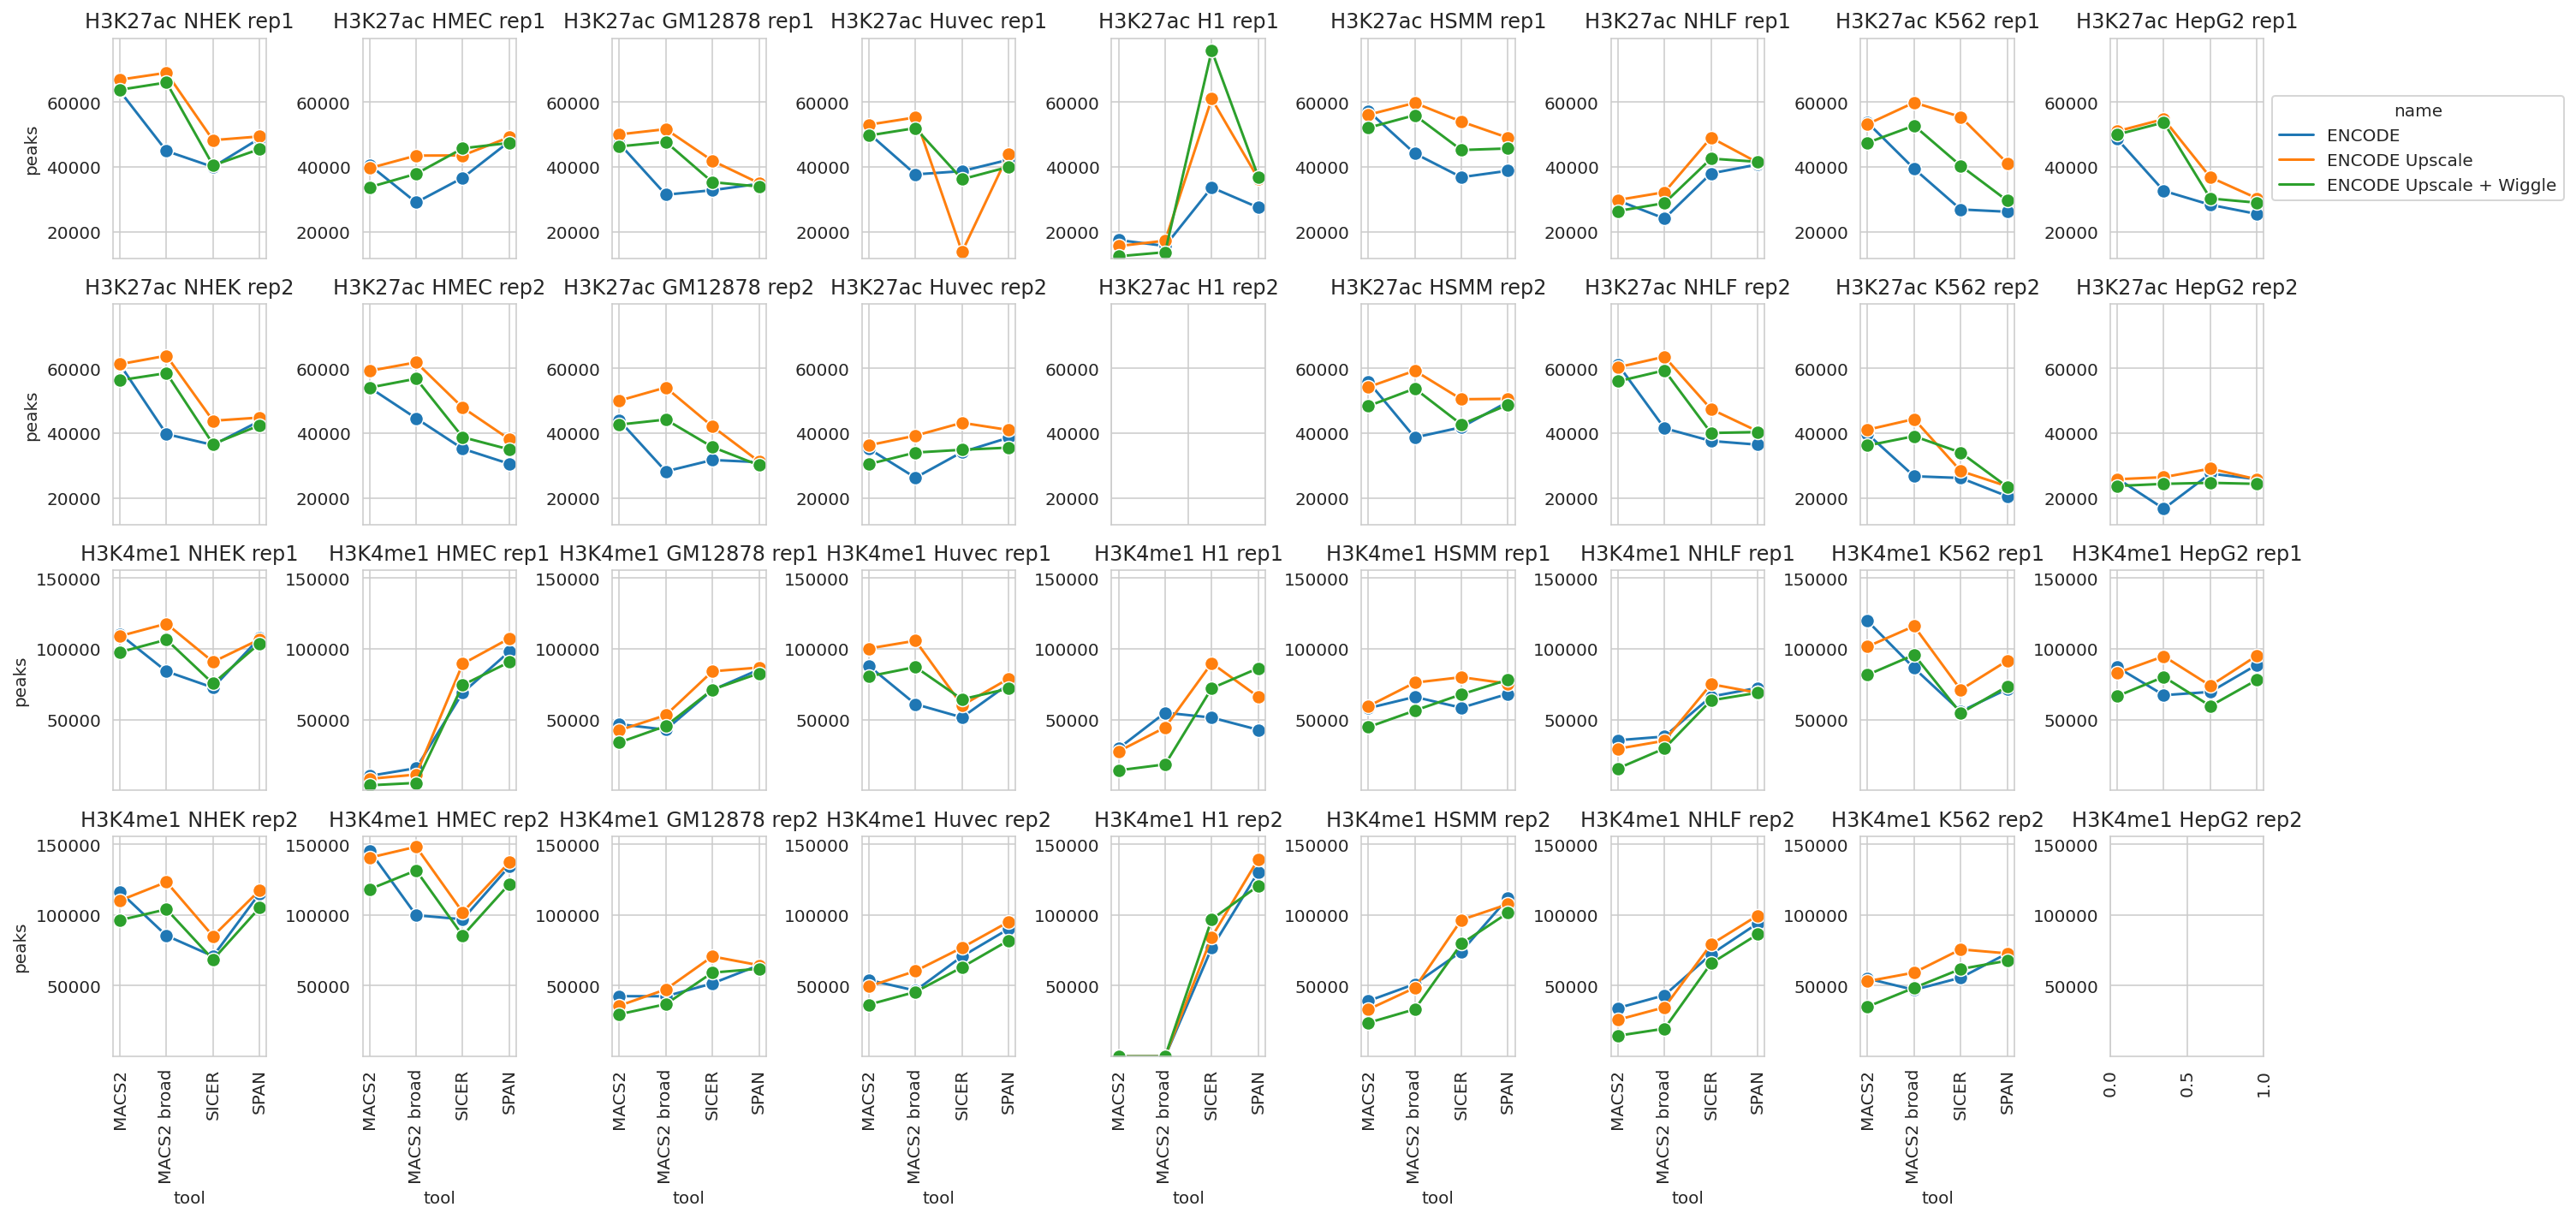

In [42]:
plt.figure(figsize=(21, 10))
CELLS = list(wiggle_mix_peaks['cell'].unique())
# CELLS = ['GM12878', 'K562', 'Huvec'] 
axs = [plt.subplot(4, len(CELLS), i + 1) for i in range(2 * len(CELLS) * 2)]

for i, (m, r, c) in enumerate(product(['H3K27ac', 'H3K4me1'], GSE26320_REPS, CELLS)):
    print(m, c, r)
    ax = axs[i]
    g_results = sns.lineplot(data=wiggle_mix_original_peaks[(wiggle_mix_original_peaks['modification']==m) &
                                                            (wiggle_mix_original_peaks['cell'] == c) &
                                                            (wiggle_mix_original_peaks['replicate'] == r)],
                             x='tool', y='peaks', hue='name',
                             hue_order=list(sorted(wiggle_mix_original_peaks['name'].unique())),
                             ax=ax,
                             # errorbar='se', 
                             marker='o', markersize=8
                             )
    if i + 1 == len(CELLS):
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i % len(CELLS) != 0:
        ax.set_ylabel(None)
    if i < len(CELLS) * 3:
        # ax.set_xticks([], minor=False)
        g_results.axes.set_xticklabels([])   
        ax.set_xlabel(None)
    else:
        ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{m} {c} {r}')
    ax.set_ylim(bottom = 0.95 * wiggle_mix_original_peaks[wiggle_mix_original_peaks['modification']==m]['peaks'].min(),
                top = 1.05 * wiggle_mix_original_peaks[wiggle_mix_original_peaks['modification']==m]['peaks'].max())
plt.tight_layout()
plt.show()

## Peaks lengths

In [43]:
print('Load lengths')
ts = []
for file, m, c, r, ty, tool in tqdm(zip(
        wiggle_mix_original_peaks['file'],
        wiggle_mix_original_peaks['modification'],
        wiggle_mix_original_peaks['cell'],
        wiggle_mix_original_peaks['replicate'],
        wiggle_mix_original_peaks['type'],
        wiggle_mix_original_peaks['tool']
)):
    # if c in ['H1', 'GM12878', 'HSMM', 'NHLF', 'HMEC']:
    #     continue
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 1000)).copy()
    t['modification'] = m
    t['cell'] = c
    t['replicate'] = r
    t['type'] = ty
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length modification     cell replicate                 type  \
29351      611      H3K4me1  GM12878      rep2               ENCODE   
266488    3999      H3K4me1     NHEK      rep2               x2_N10   
17586      971      H3K27ac     HSMM      rep1               ENCODE   
316831    1799      H3K27ac  GM12878      rep2               x2_N10   
220162     252      H3K27ac     NHLF      rep2  x2_N10_w80_20_N2000   
226345     954      H3K4me1     HSMM      rep1               x2_N10   
106917     156      H3K27ac     K562      rep1               ENCODE   
112569     731      H3K27ac  GM12878      rep2               ENCODE   
235336     214      H3K27ac     K562      rep2               x2_N10   
25866      339      H3K27ac    Huvec      rep2               ENCODE   

               tool  
29351         MACS2  
266488        SICER  
17586         MACS2  
316831        SICER  
220162  MACS2 broad  
226345  MACS2 broad  
106917         SPAN  
112569         SPAN  
235336  MACS2 broad  
25866         MACS2

In [44]:
t['name'] = t['type']
t.loc[t['type'] == 'Roadmap_10M', 'name'] = 'Roadmap Downscale'
t.loc[t['type'] == 'x2_N10', 'name'] = 'ENCODE Upscale'
t.loc[t['type'] == 'x2_N10_w80_20_N2000', 'name'] = 'ENCODE Upscale + Wiggle'

H3K27ac MACS2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac MACS2 broad


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac SPAN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac SICER
H3K4me1 MACS2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 MACS2 broad


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 SPAN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 SICER


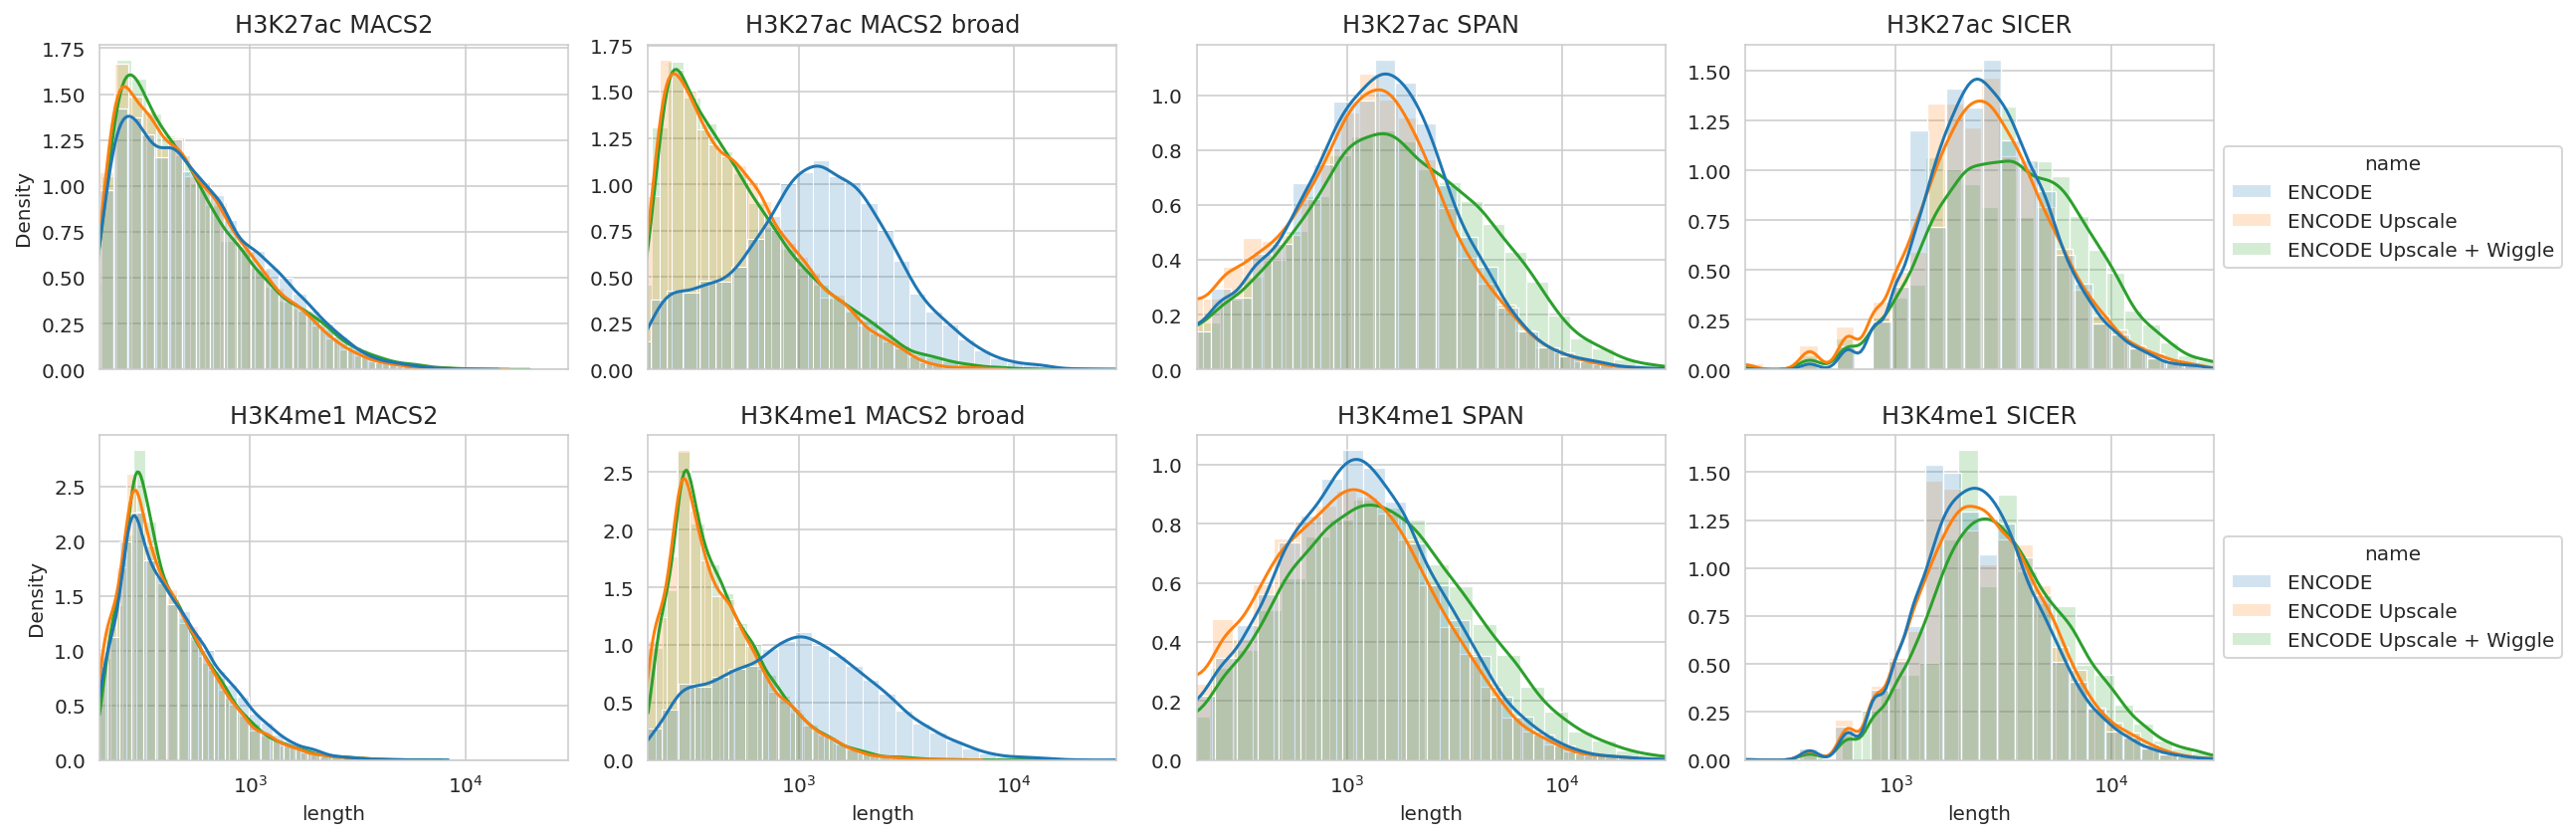

In [45]:
plt.figure(figsize=(18, 6))
CELLS = list(wiggle_mix_peaks['cell'].unique())
axs = [plt.subplot(2, len(TOOLS), i + 1) for i in range(2 * len(TOOLS))]

for i, (m, tool) in enumerate(product(['H3K27ac', 'H3K4me1'], TOOLS)):
    print(m, tool)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification']==m) &
                                    (t['tool'].isin([tool]))],
                             x='length', hue='name',
                             hue_order=list(sorted(t['name'].unique())),
                             ax=ax, stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2
                             )
    if (i + 1) % len(TOOLS) != 0:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if i % len(TOOLS) != 0:
        ax.set_ylabel(None)
    if i < len(TOOLS):
        # ax.set_xticks([], minor=False)
        g_results.axes.set_xticklabels([])
        ax.set_xlabel(None)
    ax.set_title(f'{m} {tool}')
    ax.set_xlim(2e2, 3e4)
plt.tight_layout()
plt.show()

H3K27ac MACS2
H3K27ac MACS2 broad
H3K27ac SPAN
H3K27ac SICER
H3K4me1 MACS2
H3K4me1 MACS2 broad
H3K4me1 SPAN
H3K4me1 SICER


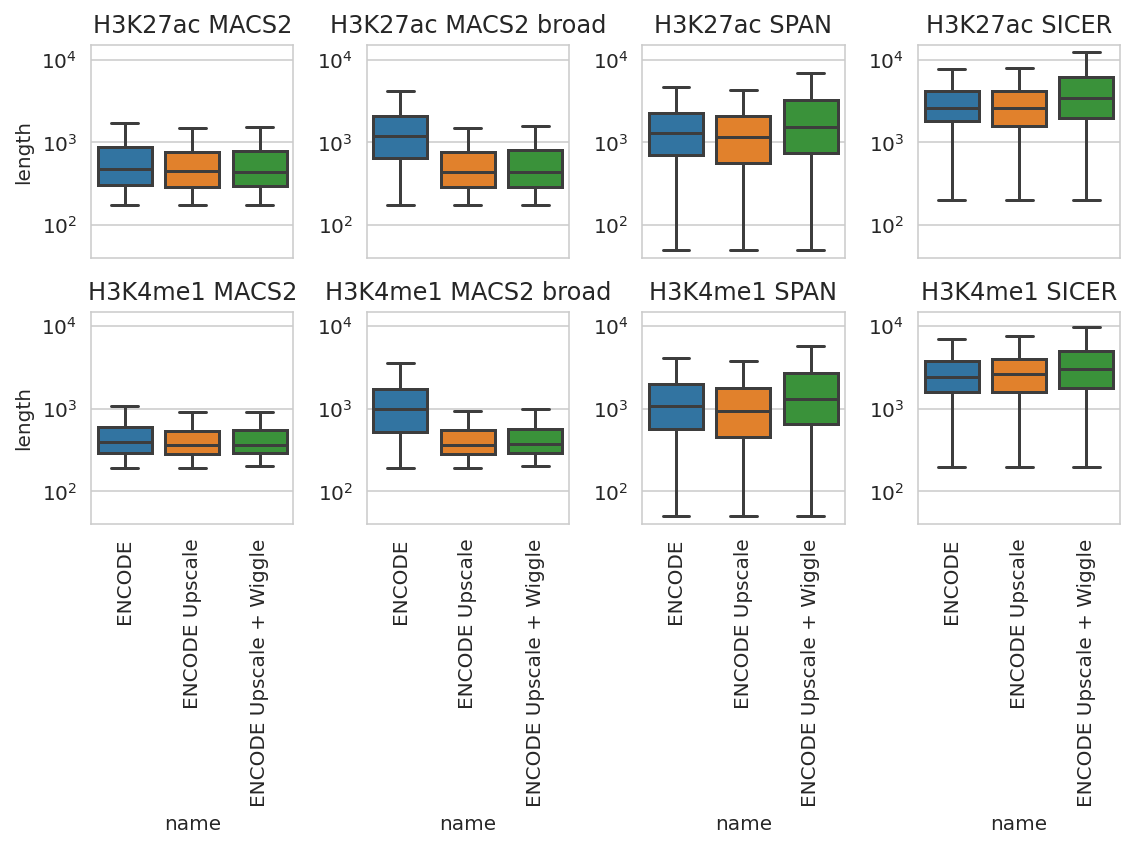

In [46]:
plt.figure(figsize=(8, 6))
TYPES = list(sorted(t['name'].unique()))
CELLS = list(wiggle_mix_peaks['cell'].unique())
axs = [plt.subplot(2, len(TOOLS), i + 1) for i in range(2 * len(TOOLS))]

for i, (m, tool) in enumerate(product(['H3K27ac', 'H3K4me1'], TOOLS)):
    print(m, tool)
    ax = axs[i]
    g_results = sns.boxplot(data=t[(t['modification']==m) &
                                   (t['tool'].isin([tool]))],
                            y='length', x='name',
                            showfliers=False,
                            order=TYPES,
                            ax=ax, 
                            )
    if i not in [0, len(TOOLS)]:
        ax.set_ylabel(None)
    if i < len(TOOLS):
        g_results.axes.set_xticklabels([])
        ax.set_xlabel(None)
    else:
        ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{m} {tool}')
    ax.set(yscale='log')
    ax.set_ylim(bottom=40, top=1.5e4)
plt.tight_layout()
plt.show()

## Compute union peaks

In [47]:
t2 = df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])) &
              (df_peaks['dataset'] == 'Roadmap') &
              (df_peaks['replicate'] == '')].copy()
t2['scale'] = 2.5
t2['upscale'] = 1.0
t2['wiggle'] = 0.0
t2['type'] = 'Roadmap'

t3 = df_downsample[(df_downsample['reads'] == '10M') & 
                   (df_downsample['modification'].isin(['H3K27ac', 'H3K4me1']))].copy()
t3['scale'] = 2.2
t3['upscale'] = 0.5
t3['wiggle'] = 0.0
t3['type'] = 'Roadmap_10M'

wiggle_mix_original_all_peaks = pd.concat([t2, t3, wiggle_mix_original_peaks]).reset_index(drop=True)
wiggle_mix_original_all_peaks

file modification     cell  \
0    /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1    TCell   
1    /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K4me1    BCell   
2    /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K27ac    TCell   
3    /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K27ac    BCell   
4    /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K27ac    TCell   
..                                                 ...          ...      ...   
435  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HSMM   
436  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
437  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
438  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
439  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1       H1   

    replicate   peaks         tool  dataset  scale  upscale  wiggle  \
0              158205        MACS2  Roadmap    2.5      1.0     0.0   
1              141414        MACS2  Roadmap    2.5      1.0     0.0   
2               57350        MACS2  Roadmap    2.5      1.0     0.0   
3               45626        MACS2  Roadmap    2.5      1.0     0.0   
4               51740  MACS2 broad  Roadmap    2.5      1.0     0.0   
..        ...     ...          ...      ...    ...      ...     ...   
435      rep1   49036         SPAN      NaN    2.0      2.0     0.0   
436      rep1   35061         SPAN      NaN    2.0      2.0     0.0   
437      rep2  137237         SPAN      NaN    2.0      2.0     0.0   
438      rep2   82036         SPAN      NaN    2.0      2.0  2000.0   
439      rep2  120608         SPAN      NaN    2.0      2.0  2000.0   

                    type  quality reads                     name  
0                Roadmap      NaN   NaN                      NaN  
1                Roadmap      NaN   NaN                      NaN  
2                Roadmap      NaN   NaN                      NaN  
3                Roadmap      NaN   NaN                      NaN  
4                Roadmap      NaN   NaN                      NaN  
..                   ...      ...   ...                      ...  
435               x2_N10      NaN   NaN           ENCODE Upscale  
436               x2_N10      NaN   NaN           ENCODE Upscale  
437               x2_N10      NaN   NaN           ENCODE Upscale  
438  x2_N10_w80_20_N2000      NaN   NaN  ENCODE Upscale + Wiggle  
439  x2_N10_w80_20_N2000      NaN   NaN  ENCODE Upscale + Wiggle  

[440 rows x 14 columns]

In [48]:
! mkdir -p {WD}/union

for _, (m, c, r, ty) in tqdm(wiggle_mix_original_all_peaks[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows()):
    print(m, c, r, ty)
    t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
                                      (wiggle_mix_original_all_peaks['cell'] == c) &
                                      (wiggle_mix_original_all_peaks['replicate'] == r) &
                                      (wiggle_mix_original_all_peaks['type'] == ty)]
    if len(t) == 0:
        continue
    # Prepare total overlap
    union_path = f'{WD}/union/{m}_{c}_{r}_{ty}.bed'
    print(union_path)
    if os.path.exists(union_path):
        continue
    try:
        files = t[t['tool'] == 'SPAN']['file']
        t_span = sorted_file(files.values[0]) if len(files) == 1 else ''
        files = t[t['tool'] == 'MACS2']['file']
        t_macs2 = sorted_file(files.values[0]) if len(files) == 1 else ''
        files = t[t['tool'] == 'MACS2 broad']['file']
        t_macs2broad = sorted_file(files.values[0]) if len(files) == 1 else ''
        files = t[t['tool'] == 'SICER']['file']
        t_sicer = sorted_file(files.values[0]) if len(files) == 1 else ''
        tf = tempfile.mktemp()
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        ! rm {tf}
    except Exception as e:
        print(e)
        break

0it [00:00, ?it/s]

H3K4me1 TCell  Roadmap
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_TCell__Roadmap.bed
H3K4me1 BCell  Roadmap
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_BCell__Roadmap.bed
H3K27ac TCell  Roadmap
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_TCell__Roadmap.bed
H3K27ac BCell  Roadmap
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_BCell__Roadmap.bed
H3K4me1 BCell  Roadmap_10M
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_BCell__Roadmap_10M.bed
H3K4me1 TCell  Roadmap_10M
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_TCell__Roadmap_10M.bed
H3K27ac BCell  Roadmap_10M
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_BCell__Roadmap_10M.bed
H3K27ac TCell  Roadmap_10M
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_TCell__Roadmap_10M.bed
H3K27ac HepG2 rep2 ENCODE
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep2_ENCODE.bed
H3K27ac GM12878 rep2 ENCODE
/home/jetbrains/

## Find bigwigs

In [49]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}


def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [50]:
encode_bws = load_bws(GSE26320_PATH + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
encode_bws['dataset'] = 'ENCODE'
display(encode_bws.sample(3))

immune_bws = load_bws(IMMUNE_PATH + '/bw', MODIFICATIONS, IMMUNE_CELLS, [''], None)
immune_bws['dataset'] = 'Roadmap'
display(immune_bws.sample(3))

  0%|          | 0/52 [00:00<?, ?it/s]

file modification  cell  \
4   /home/jetbrains/data/2023_GSE26320/bw/GSM64648...      H3K4me1  NHLF   
6   /home/jetbrains/data/2023_GSE26320/bw/GSM64638...      H3K4me1  HMEC   
22  /home/jetbrains/data/2023_GSE26320/bw/GSM64639...      H3K27ac  HSMM   

   replicate dataset  
4       rep1  ENCODE  
6       rep2  ENCODE  
22      rep2  ENCODE

  0%|          | 0/17 [00:00<?, ?it/s]

file modification   cell  \
8  /home/jetbrains/data/2023_Immune/bw/BCell_H3K2...      H3K27ac  BCell   
5  /home/jetbrains/data/2023_Immune/bw/BCell_H3K4...      H3K4me3  BCell   
1  /home/jetbrains/data/2023_Immune/bw/BCell_H3K2...     H3K27me3  BCell   

  replicate  dataset  
8            Roadmap  
5            Roadmap  
1            Roadmap

In [51]:
immune_10m_bws = load_bws(IMMUNE_PATH + '_mln_control/bw', MODIFICATIONS, IMMUNE_CELLS, [''], None)
immune_10m_bws['dataset'] = 'Roadmap_10M'
display(immune_10m_bws.sample(3))

  0%|          | 0/5 [00:00<?, ?it/s]

file modification   cell  \
1  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  BCell   
3  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  TCell   
2  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  TCell   

  replicate      dataset  
1            Roadmap_10M  
3            Roadmap_10M  
2            Roadmap_10M

In [52]:
wiggle_bws = load_bws(WD + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
wiggle_bws['type'] = [re.sub('.*rep[12]_|\.bw', '', os.path.basename(f)) for f in wiggle_bws['file']]
wiggle_bws['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in wiggle_bws['type']]
wiggle_bws['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in wiggle_bws['type']]

wiggle_bws.sample(5)

  0%|          | 0/86 [00:00<?, ?it/s]

file modification     cell  \
7   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac    Huvec   
19  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
21  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  GM12878   
29  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
13  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   

   replicate                 type  upscale  wiggle  
7       rep2  x2_N10_w80_20_N2000      2.0  2000.0  
19      rep2  x2_N10_w80_20_N2000      2.0  2000.0  
21      rep1  x2_N10_w80_20_N2000      2.0  2000.0  
29      rep1  x2_N10_w80_20_N2000      2.0  2000.0  
13      rep2               x2_N10      2.0     NaN

In [53]:
t = wiggle_bws.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
t['scale'] = t['upscale']
t2 = encode_bws[(encode_bws['modification'].isin(['H3K27ac', 'H3K4me1'])) & 
                (encode_bws['cell'].isin(CELLS)) 
                # & (encode_bws['replicate'] == 'rep1')
].copy()
t2['scale'] = 0.5
t2['wiggle'] = 0.0
t2['type'] = 'ENCODE'

t3 = immune_bws[immune_bws['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t3['scale'] = 2.5
t3['wiggle'] = 0.0
t3['type'] = 'Roadmap'

t4 = immune_10m_bws[immune_10m_bws['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t4['scale'] = 2.2
t4['wiggle'] = 0.0
t4['type'] = 'Roadmap_10M'

all_bws = pd.concat([t, t2, t3, t4]).reset_index(drop=True)
all_bws

file modification   cell  \
0    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HSMM   
1    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   NHLF   
2    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  HepG2   
3    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HMEC   
4    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HMEC   
..                                                 ...          ...    ...   
105  /home/jetbrains/data/2023_Immune/bw/BCell_H3K2...      H3K27ac  BCell   
106  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  BCell   
107  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  BCell   
108  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  TCell   
109  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  TCell   

    replicate                 type  upscale  wiggle  scale      dataset  
0        rep1               x2_N10      2.0     0.0    2.0          NaN  
1        rep2  x2_N10_w80_20_N2000      2.0  2000.0    2.0          NaN  
2        rep1               x2_N10      2.0     0.0    2.0          NaN  
3        rep1               x2_N10      2.0     0.0    2.0          NaN  
4        rep1  x2_N10_w80_20_N2000      2.0  2000.0    2.0          NaN  
..        ...                  ...      ...     ...    ...          ...  
105                        Roadmap      NaN     0.0    2.5      Roadmap  
106                    Roadmap_10M      NaN     0.0    2.2  Roadmap_10M  
107                    Roadmap_10M      NaN     0.0    2.2  Roadmap_10M  
108                    Roadmap_10M      NaN     0.0    2.2  Roadmap_10M  
109                    Roadmap_10M      NaN     0.0    2.2  Roadmap_10M  

[110 rows x 9 columns]

## Prepare homemade BigWig based peaks

In [54]:
import math
import pyBigWig

def peak_calling(bw_path, chrom_sizes, blacklist, bin, top_bins):
    print('Prepare chromosome indexes')
    chr_indx = {}
    indx = 0
    for chr, chr_size in chrom_sizes.items():
        if '_' in chr:
            continue
        bins = int(math.floor(chr_size / bin))
        chr_indx[chr] = (indx, indx + bins)
        indx += bins
    chromosomes = list(chr_indx.keys())
    # print(chromosomes)
    # print(chr_indx)

    print('Compute binned coverage')    
    binned_coverage = np.zeros(indx)
    with pyBigWig.open(bw_path) as bw:
        for chr, (istart, iend) in chr_indx.items():
            binned_coverage[istart: iend] =\
                np.array([x or 0 for x in bw.stats(chr, 1, CHROM_SIZES[chr], nBins=iend - istart, exact=True, type='sum')])
    
    if blacklist is not None:
        print('Processing blacklisted regions')
        for chr, start, end in zip(blacklist['chr'], blacklist['start'], blacklist['end']):
            if chr not in chr_indx:
                continue
            offset = chr_indx[chr][0]
            for x in range(int(math.floor(start / bin)), int(math.ceil(end / bin)) + 1):
                binned_coverage[min(x - offset, len(binned_coverage) - 1)] = 0
    
    print('Total coverage', binned_coverage.sum())
    print('Split by chromosomes')
    if top_bins > len(binned_coverage):
        raise Exception(f'Too many top bins {top_bins} > {len(binned_coverage)}')
    chr_xs = [[] for _ in range(len(chr_indx))]  # Create new array for each chromosome index
    ichr = 0
    for x in np.sort(np.argpartition(binned_coverage, -top_bins)[-top_bins:]):
        while chr_indx[chromosomes[ichr]][1] < x:
            ichr += 1
        chr_xs[ichr].append(x)
    # print(chr_xs)

    print('Collect final peaks')
    peaks = []
    for ichr, xs in enumerate(chr_xs):
        chr = chromosomes[ichr]
        offset = chr_indx[chr][0]
        start = -1
        for i, x in enumerate(xs):
            if i == 0:
                start = x
            elif xs[i - 1] != x - 1:
                peaks.append((chr, (start - offset) * bin, (xs[i - 1] + 1 - offset) * bin))
                start = x
        peaks.append((chr, (start - offset) * bin, (xs[-1] + 1 - offset) * bin))
    return pd.DataFrame(peaks, columns=['chromosome', 'start', 'end'])

# BLACK LISTS:
https://github.com/Boyle-Lab/Blacklist/tree/master/lists

In [55]:
BLACKLIST_PATH = WD + '/hg38-blacklist.v2.bed'
blacklist_df = pd.read_csv(BLACKLIST_PATH, sep='\t', header=None)
blacklist_df.rename({0: 'chr', 1: 'start', 2: 'end'}, axis=1, inplace=True)
blacklist_df

chr     start       end                   3
0    chr10         0     45700     Low Mappability
1    chr10  38481300  38596500  High Signal Region
2    chr10  38782600  38967900  High Signal Region
3    chr10  39901300  41712900  High Signal Region
4    chr10  41838900  42107300  High Signal Region
..     ...       ...       ...                 ...
631   chrY   4343800   4345800  High Signal Region
632   chrY  10246200  11041200  High Signal Region
633   chrY  11072100  11335300  High Signal Region
634   chrY  11486600  11757800  High Signal Region
635   chrY  26637300  57227400  High Signal Region

[636 rows x 4 columns]

In [56]:
bw_path = '/home/jetbrains/data/2023_GSE26320/bw/GSM646394_HSMM_H3K27ac_rep1.bw'
bin = 5_000
top_bins = 25_000
chrom_sizes_2 = {'chr1': CHROM_SIZES['chr1'], 'chr2': CHROM_SIZES['chr2']}

# print('WITHOUT BLACKLIST')
# display(peak_calling(bw_path, chrom_sizes, bin=bin, top_bins=top_bins))
# 
print('WITH BLACKLIST')
display(peak_calling(bw_path, chrom_sizes_2, blacklist_df, bin, top_bins))

WITH BLACKLIST
Prepare chromosome indexes
Compute binned coverage
Processing blacklisted regions
Total coverage 150922243.0
Split by chromosomes
Collect final peaks


chromosome      start        end
0           chr1     815000     820000
1           chr1     825000     830000
2           chr1     835000     840000
3           chr1     855000     860000
4           chr1     905000     910000
...          ...        ...        ...
11228       chr2  241605000  241620000
11229       chr2  241625000  241650000
11230       chr2  241655000  241665000
11231       chr2  241670000  241700000
11232       chr2  241720000  241735000

[11233 rows x 3 columns]

In [200]:
chrom_sizes_3 = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

BIN = 10_000
NBINS = 10_000
HMD = f'{WD}/homemade_{BIN}bp_{NBINS}'
print(HMD)
! mkdir -p {HMD}

for _, (m, c, r, ty) in tqdm(list(all_bws[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows())):
    print(m, c, r, ty)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['type'] == ty)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    print(bw_path)
    peaks_path = f'{HMD}/{m}_{c}_{r}_{ty}.bed'
    print(peaks_path)
    if os.path.exists(peaks_path):
        continue
    peaks = peak_calling(bw_path, chrom_sizes_3, blacklist_df, BIN, NBINS)
    peaks.to_csv(peaks_path, sep='\t', header=False, index=None)

/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_10000


  0%|          | 0/110 [00:00<?, ?it/s]

H3K4me1 HSMM rep1 x2_N10
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_HSMM_rep1_x2_N10.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_10000/H3K4me1_HSMM_rep1_x2_N10.bed
Prepare chromosome indexes
Compute binned coverage
Processing blacklisted regions
Total coverage 312952127.0
Split by chromosomes
Collect final peaks
H3K27ac NHLF rep2 x2_N10_w80_20_N2000
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_10000/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bed
Prepare chromosome indexes
Compute binned coverage
Processing blacklisted regions
Total coverage 284773608.0
Split by chromosomes
Collect final peaks
H3K4me1 HepG2 rep1 x2_N10
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_HepG2_rep1_x2_N10.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_10000/H3K4me1_HepG2_rep1_x2_N10.bed
Prepare chromosome indexes
Compute binned coverage
Process

## Compare homemade peaks with others

In [201]:
# homemade_compare = pd.DataFrame(columns=['modification', 'cell', 'replicate', 'type', 'tool',
#                                          'tool_peaks', 'tool_len', 'homemade_peaks', 'homemade_len',
#                                          'overlap1', 'overlap2', 'overlap_len'])
# 
# for _, (m, c, r, ty) in tqdm(wiggle_mix_original_all_peaks[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows()):
#     print(m, c, r, ty)
#     homemade_file = f'{HMD}/{m}_{c}_{r}_{ty}.bed'
#     if not os.path.exists(homemade_file):
#         continue
#     homemade_file = sorted_file(homemade_file)
#     homemade_peaks = lines(homemade_file)
#     homemade_len = bedl(homemade_file).sum()
#     
#     t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
#                                       (wiggle_mix_original_all_peaks['cell'] == c) &
#                                       (wiggle_mix_original_all_peaks['replicate'] == r) &
#                                       (wiggle_mix_original_all_peaks['type'] == ty)]
#     if len(t) == 0:
#         continue
#     for tool in TOOLS:
#         files = t[t['tool'] == tool]['file']
#         if len(files) == 0:
#             continue
#         print(tool, files.values[0])
#         tf = tempfile.mktemp()
#         tf2 = tempfile.mktemp()
#         # Filter first 3 chromosomes only
#         t_file = pd.read_csv(sorted_file(files.values[0]), sep='\t', header=None)
#         t_file[t_file[0].isin(['chr1', 'chr2', 'chr3'])].to_csv(tf, sep='\t', header=False, index=None)
#         # ! T=$'\t'; grep -E "chr[123]$T" {t_file} > {tf}
#         tool_peaks = lines(tf)
#         tool_len = bedl(tf).sum()
#         !bedtools intersect -a {homemade_file} -b {tf} -wa -u > {tf2}
#         overlap2 = lines(tf2)
#         !bedtools intersect -b {homemade_file} -a {tf} -wa -u > {tf2}
#         overlap1 = lines(tf2)
#         !bedtools intersect -a {homemade_file} -b {tf} -wo > {tf2}
#         overlap_len = int(last_col(tf).sum())
#         homemade_compare.loc[len(homemade_compare)] = \
#             (m, c, r, ty, tool,
#              tool_peaks, tool_len,
#              homemade_peaks, homemade_len, overlap1, overlap2, overlap_len)
#     
# homemade_compare.sample(5)

In [202]:
# homemade_compare['jaccard'] = [
#     d(o, p + g - o)
#     for p, g, o in zip(homemade_compare['tool_len'], homemade_compare['homemade_len'], homemade_compare['overlap_len'])
# ]
# 
# homemade_compare['overlap1f'] = [
#     d(o, t)
#     for t, o in zip(homemade_compare['tool_peaks'], homemade_compare['overlap1'])
# ]
# homemade_compare['overlap2f'] = [
#     d(o, t)
#     for t, o in zip(homemade_compare['homemade_peaks'], homemade_compare['overlap2'])
# ]
# 
# homemade_compare.sample(1)

In [203]:
# plt.figure(figsize=(5, 3.5))
# axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
# 
# for i, m in enumerate(['H3K27ac', 'H3K4me1']):
#     print(m)
#     ax = axs[i]
#     g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
#                             x='type', y='homemade_peaks', ax=ax,
#                             capsize=.1, errwidth=2, edgecolor="black",
#                             # order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
#                             order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'x2_N10_w80_20_N2000'],
#                             )
#     ax.title.set_text(m)
#     # if i < 1:
#     #     ax.legend().set_visible(False)
#     # else:
#     #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#     # ax.set_ylim(0, 55_000)
#     ax.xaxis.set_tick_params(rotation=90)
# 
# plt.tight_layout()
# plt.show()

In [204]:
# plt.figure(figsize=(11, 3.5))
# axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
# 
# for i, m in enumerate(['H3K27ac', 'H3K4me1']):
#     print(m)
#     ax = axs[i]
#     g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
#                             x='tool', hue='type', y='tool_peaks', ax=ax,
#                             capsize=.05, errwidth=2, edgecolor="black",
#                             order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
#                             # hue_order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
#                             hue_order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'x2_N10_w80_20_N2000'],
#                             )
#     ax.title.set_text(m)
#     if i < 1:
#         ax.legend().set_visible(False)
#     else:
#         sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#     # ax.set_ylim(0, 55_000)
#     ax.xaxis.set_tick_params(rotation=90)
# 
# plt.tight_layout()
# plt.show()

In [205]:
# plt.figure(figsize=(5, 3.5))
# axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
# 
# for i, m in enumerate(['H3K27ac', 'H3K4me1']):
#     print(m)
#     ax = axs[i]
#     g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
#                             x='type', y='overlap1f', ax=ax,
#                             capsize=.1, errwidth=2, edgecolor="black",
#                             # order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
#                             order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'x2_N10_w80_20_N2000'],
#                             )
#     ax.title.set_text(m)
#     ax.set_ylabel('Tool vs homemade')
#     ax.xaxis.set_tick_params(rotation=90)
# 
# plt.tight_layout()
# plt.show()

In [206]:
# plt.figure(figsize=(5, 3.5))
# axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
# 
# for i, m in enumerate(['H3K27ac', 'H3K4me1']):
#     print(m)
#     ax = axs[i]
#     g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
#                             x='type', y='overlap2f', ax=ax,
#                             capsize=.1, errwidth=2, edgecolor="black",
#                             # order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
#                             order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'x2_N10_w80_20_N2000'],
#                             )
#     ax.title.set_text(m)
#     ax.set_ylabel('Homemade vs tool')
#     ax.xaxis.set_tick_params(rotation=90)
# 
# plt.tight_layout()
# plt.show()

In [207]:
# plt.figure(figsize=(11, 3.5))
# axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
# 
# for i, m in enumerate(['H3K27ac', 'H3K4me1']):
#     print(m)
#     ax = axs[i]
#     g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
#                             x='tool', hue='type', y='jaccard', ax=ax,
#                             capsize=.05, errwidth=2, edgecolor="black",
#                             order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
#                             # hue_order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
#                             hue_order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'x2_N10_w80_20_N2000'],
#                             )
#     ax.title.set_text(m)
#     if i < 1:
#         ax.legend().set_visible(False)
#     else:
#         sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#     # ax.set_ylim(0, 55_000)
#     ax.xaxis.set_tick_params(rotation=90)
# 
# plt.tight_layout()
# plt.show()

## Compute roughness

In [208]:
from scipy.stats import zscore

def ra(xs):
    zs = xs - np.mean(xs)
    return np.fabs(zs).sum() / len(xs) 

def rq(xs):
    zs = xs - np.mean(xs)
    return math.sqrt((zs * zs).sum() / len(xs)) 

xs = [3,6,20,13,7,15,12,15,7,2]
print('RQ', rq(xs))
print('RA', ra(xs))

ys = [3,8,17,14,8,13,12,16,6,3]
print('RQ', rq(ys))
print('RA', ra(ys))


RQ 5.5677643628300215
RA 5.0
RQ 4.857983120596447
RA 4.4


In [209]:
from math import ceil
import pyBigWig

def compute_roughness(bw_path, chrom_sizes, bin, m, c, r, ty, peaks_path=None):
    if bin < 50:
        raise Exception('Too small bin size')
    rows = []
    try:
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in chrom_sizes.keys() if '_' not in chr) / 1e6
            print('Total coverage', total_coverage)
            if peaks_path is None or not os.path.exists(peaks_path):
                print('Computing roughness on chromosomes 10k-10mln')
                # TODO: process black listed regions here!!!
                for chr, chr_size in chrom_sizes.items():
                    chr_size = min(10_000_000, chr_size)
                    stats = np.array(bw.stats(chr, 100_000, chr_size, nBins=int(ceil((chr_size - 100_000) / bin)), exact=True, type='sum'))
                    rows.append((m, c, r, ty, total_coverage, f'{chr}:100000-{chr_size}', ra(stats), rq(stats)))
            else:
                print(f'Computing roughness on peaks file {peaks_path}')
                t = pd.read_csv(peaks_path, sep='\t', header=None)
                if len(t) > 1000:
                    print('Pick 1000 uniform peaks for computation speedup')
                    step = int(math.ceil(len(t) / 1000.0))
                    idxs = [False] * len(t) 
                    for i in range(0, len(t), step):
                        idxs[i] = True
                    t = t.loc[idxs].copy()  
                for chr, start, end in zip(t[0], t[1], t[2]):
                    if chr in chrom_sizes:
                        stats = np.array(bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True, type='sum'))
                        rows.append((m, c, r, ty, total_coverage, f'{chr}:{start}-{end}',  ra(stats), rq(stats)))
    except Exception as e:
        print(e)
        pass  # Ignore

    df_roughness = pd.DataFrame(rows,
                                columns=['modification', 'cell', 'replicate', 'type', 'coverage', 'position', 'ra', 'rq'])
    del rows
    return df_roughness

In [210]:
ROUGHNESS_BIN = 100  # Should be bigger than used for upscaling (N10) and resolution of bigwig file (50bp)!

chrom_sizes_3 = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

ts = []
for _, (m, c, r, ty) in tqdm(list(all_bws[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows())):
    print(m, c, r, ty)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['type'] == ty)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    print(bw_path)
    peaks_path = f'{HMD}/{m}_{c}_{r}_{ty}.bed'
    # peaks_path = f'{WD}/union/{m}_{c}_{r}_{ty}.bed'
    ts.append(compute_roughness(bw_path, chrom_sizes_3, ROUGHNESS_BIN, m, c, r, ty, peaks_path=peaks_path))
    # ts.append(compute_roughness(bw_path, chrom_sizes_3, ROUGHNESS_BIN, m, c, r, ty, peaks_path=None))
    
df_roughness = pd.concat(ts).reset_index(drop=True)
del ts
df_roughness.sample(5)

  0%|          | 0/110 [00:00<?, ?it/s]

H3K4me1 HSMM rep1 x2_N10
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_HSMM_rep1_x2_N10.bw
Total coverage 321.60765
Computing roughness on peaks file /home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_10000/H3K4me1_HSMM_rep1_x2_N10.bed
Pick 1000 uniform peaks for computation speedup
H3K27ac NHLF rep2 x2_N10_w80_20_N2000
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bw
Total coverage 291.449
Computing roughness on peaks file /home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_10000/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bed
Pick 1000 uniform peaks for computation speedup
H3K4me1 HepG2 rep1 x2_N10
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_HepG2_rep1_x2_N10.bw
Total coverage 530.13305
Computing roughness on peaks file /home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade_10000bp_10000/H3K4me1_HepG2_rep1_x2_N10.bed
Pick 1000 uniform peaks for computation speedup
H3K4me1 HMEC rep1 x2_N10
/home/jetbrain

modification     cell replicate                 type  coverage  \
91245      H3K4me1     NHEK      rep2               ENCODE  225.0494   
23940      H3K4me1       H1      rep1               x2_N10  314.7703   
95896      H3K27ac    BCell                        Roadmap  429.9391   
10744      H3K4me1  GM12878      rep2  x2_N10_w80_20_N2000  359.2588   
42578      H3K27ac     K562      rep1  x2_N10_w80_20_N2000  481.0858   

                       position        ra          rq  
91245  chr2:138750000-138760000  154.5700  217.634441  
23940      chr1:9410000-9430000  112.7075  164.430646  
95896  chr2:174740000-174760000  146.6325  211.611525  
10744  chr2:187980000-187990000   85.6800  109.265731  
42578      chr3:6640000-6650000   94.7000  124.574275

In [211]:
df_roughness['name'] = df_roughness['type']
df_roughness.loc[df_roughness['type'] == 'Roadmap_10M', 'name'] = 'Roadmap Downscale'
df_roughness.loc[df_roughness['type'] == 'x2_N10', 'name'] = 'ENCODE Upscale'
df_roughness.loc[df_roughness['type'] == 'x2_N10_w80_20_N2000', 'name'] = 'ENCODE Upscale + Wiggle'

In [212]:
def plot_modifications_simple(df, X, Y, text=False):
    plt.figure(figsize=(11, 4))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        ax = axs[i]
        t = df[df['modification'] == m].copy()
        sns.scatterplot(data=t,
                        x=X, y=Y, hue='name',
                        hue_order=sorted(t['name'].unique()),
                        alpha=0.8,
                        ax=ax)
        if text:
            for x, y, cell, rep in zip(t[X], t[Y], t['cell'], t['replicate']):
                ax.text(x, y, f'{cell} {rep}', fontsize = 4)
        ax.title.set_text(m)
        if i == 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.show()

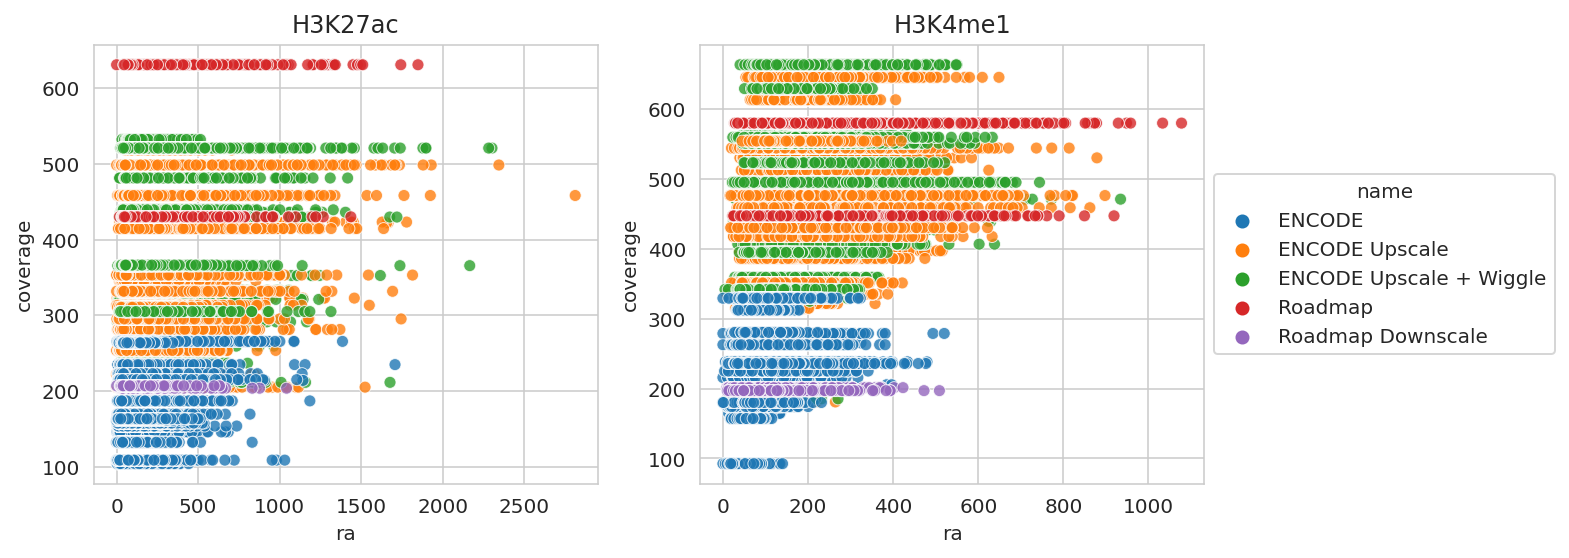

In [213]:
plot_modifications_simple(df_roughness, 'ra', 'coverage', text=False)

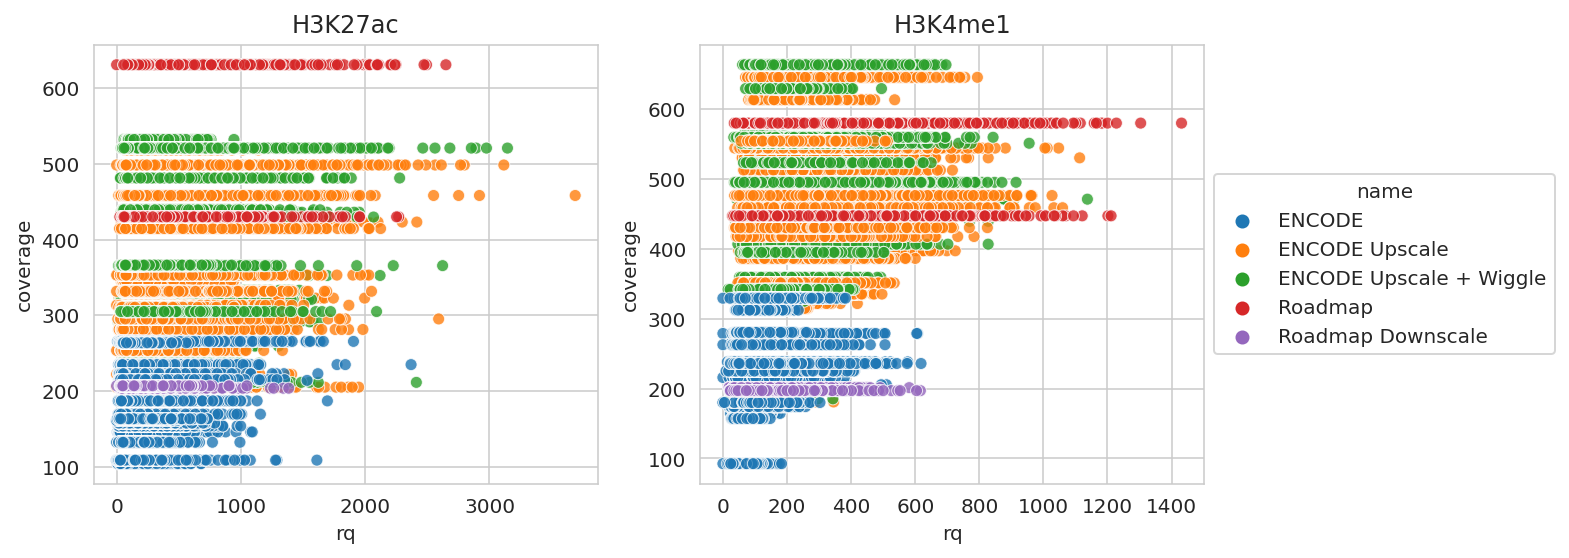

In [214]:
plot_modifications_simple(df_roughness, 'rq', 'coverage', text=False)

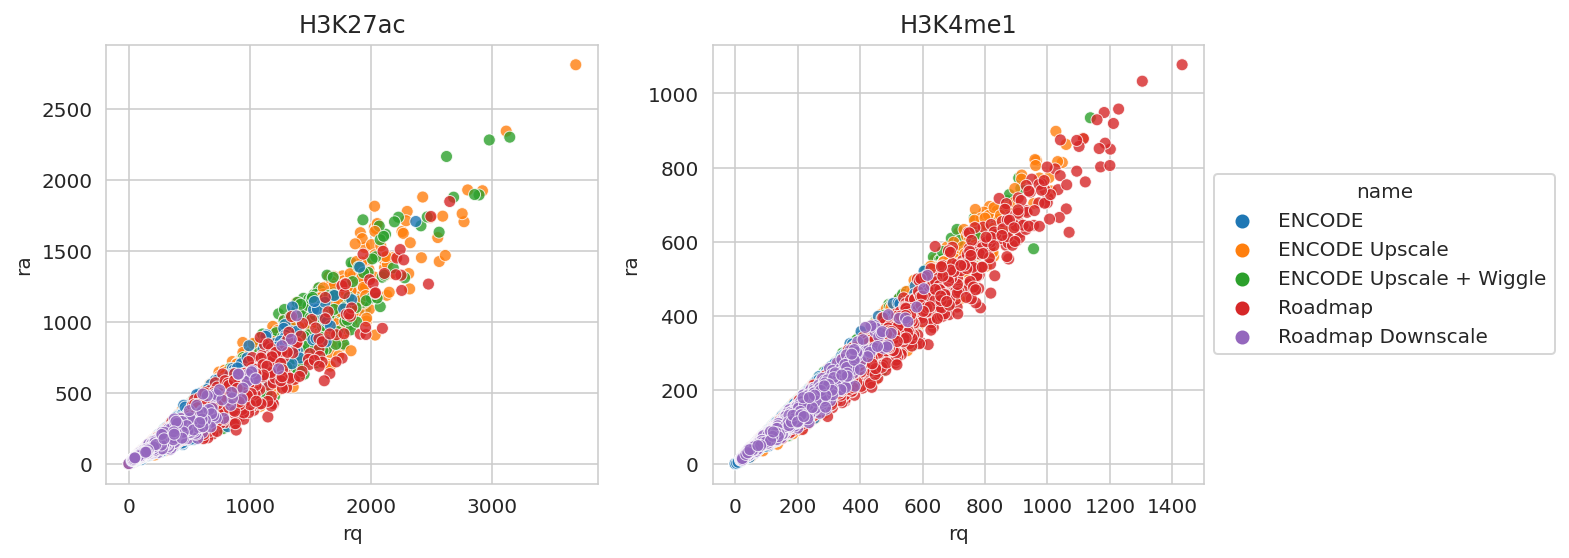

In [215]:
plot_modifications_simple(df_roughness, 'rq', 'ra', text=False)
df_roughness['ran'] = df_roughness['ra'] / df_roughness['coverage']
df_roughness['rqn'] = df_roughness['rq'] / df_roughness['coverage']
df_roughness['r'] = df_roughness['ran']

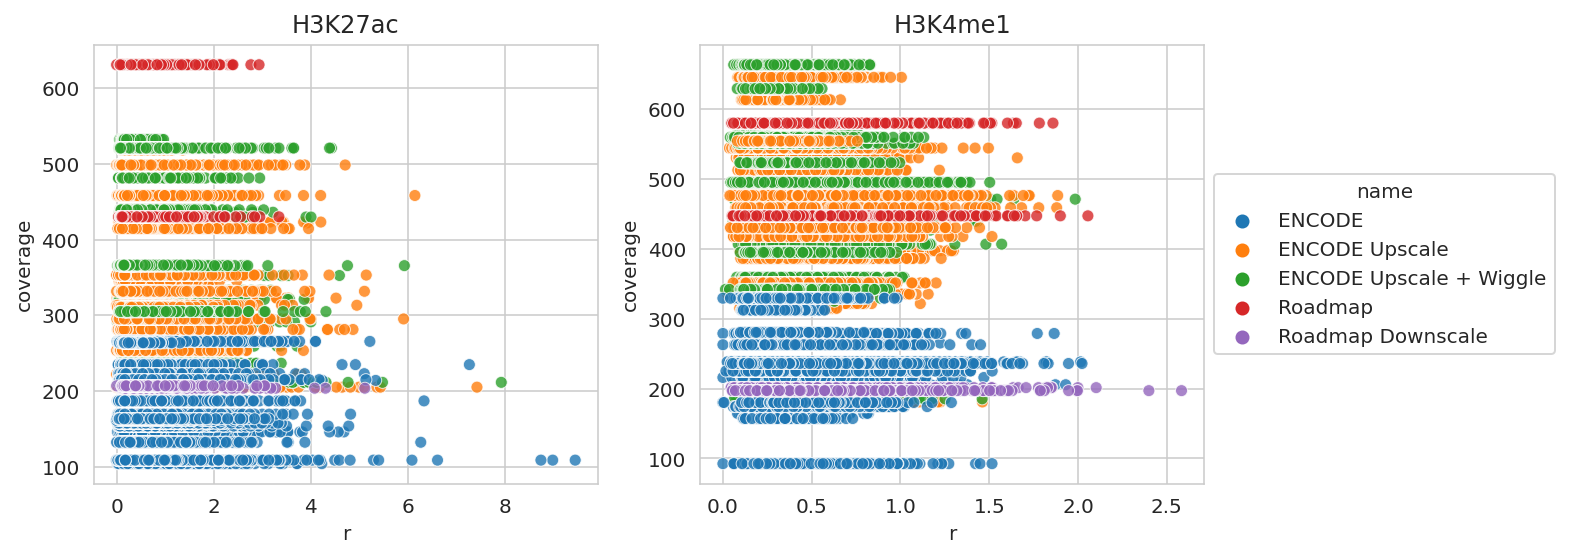

In [216]:
plot_modifications_simple(df_roughness, 'r', 'coverage', text=False)

H3K27ac ENCODE Upscale


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac ENCODE Upscale + Wiggle


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac ENCODE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac Roadmap
H3K27ac Roadmap Downscale
H3K4me1 ENCODE Upscale


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 ENCODE Upscale + Wiggle


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 ENCODE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 Roadmap
H3K4me1 Roadmap Downscale


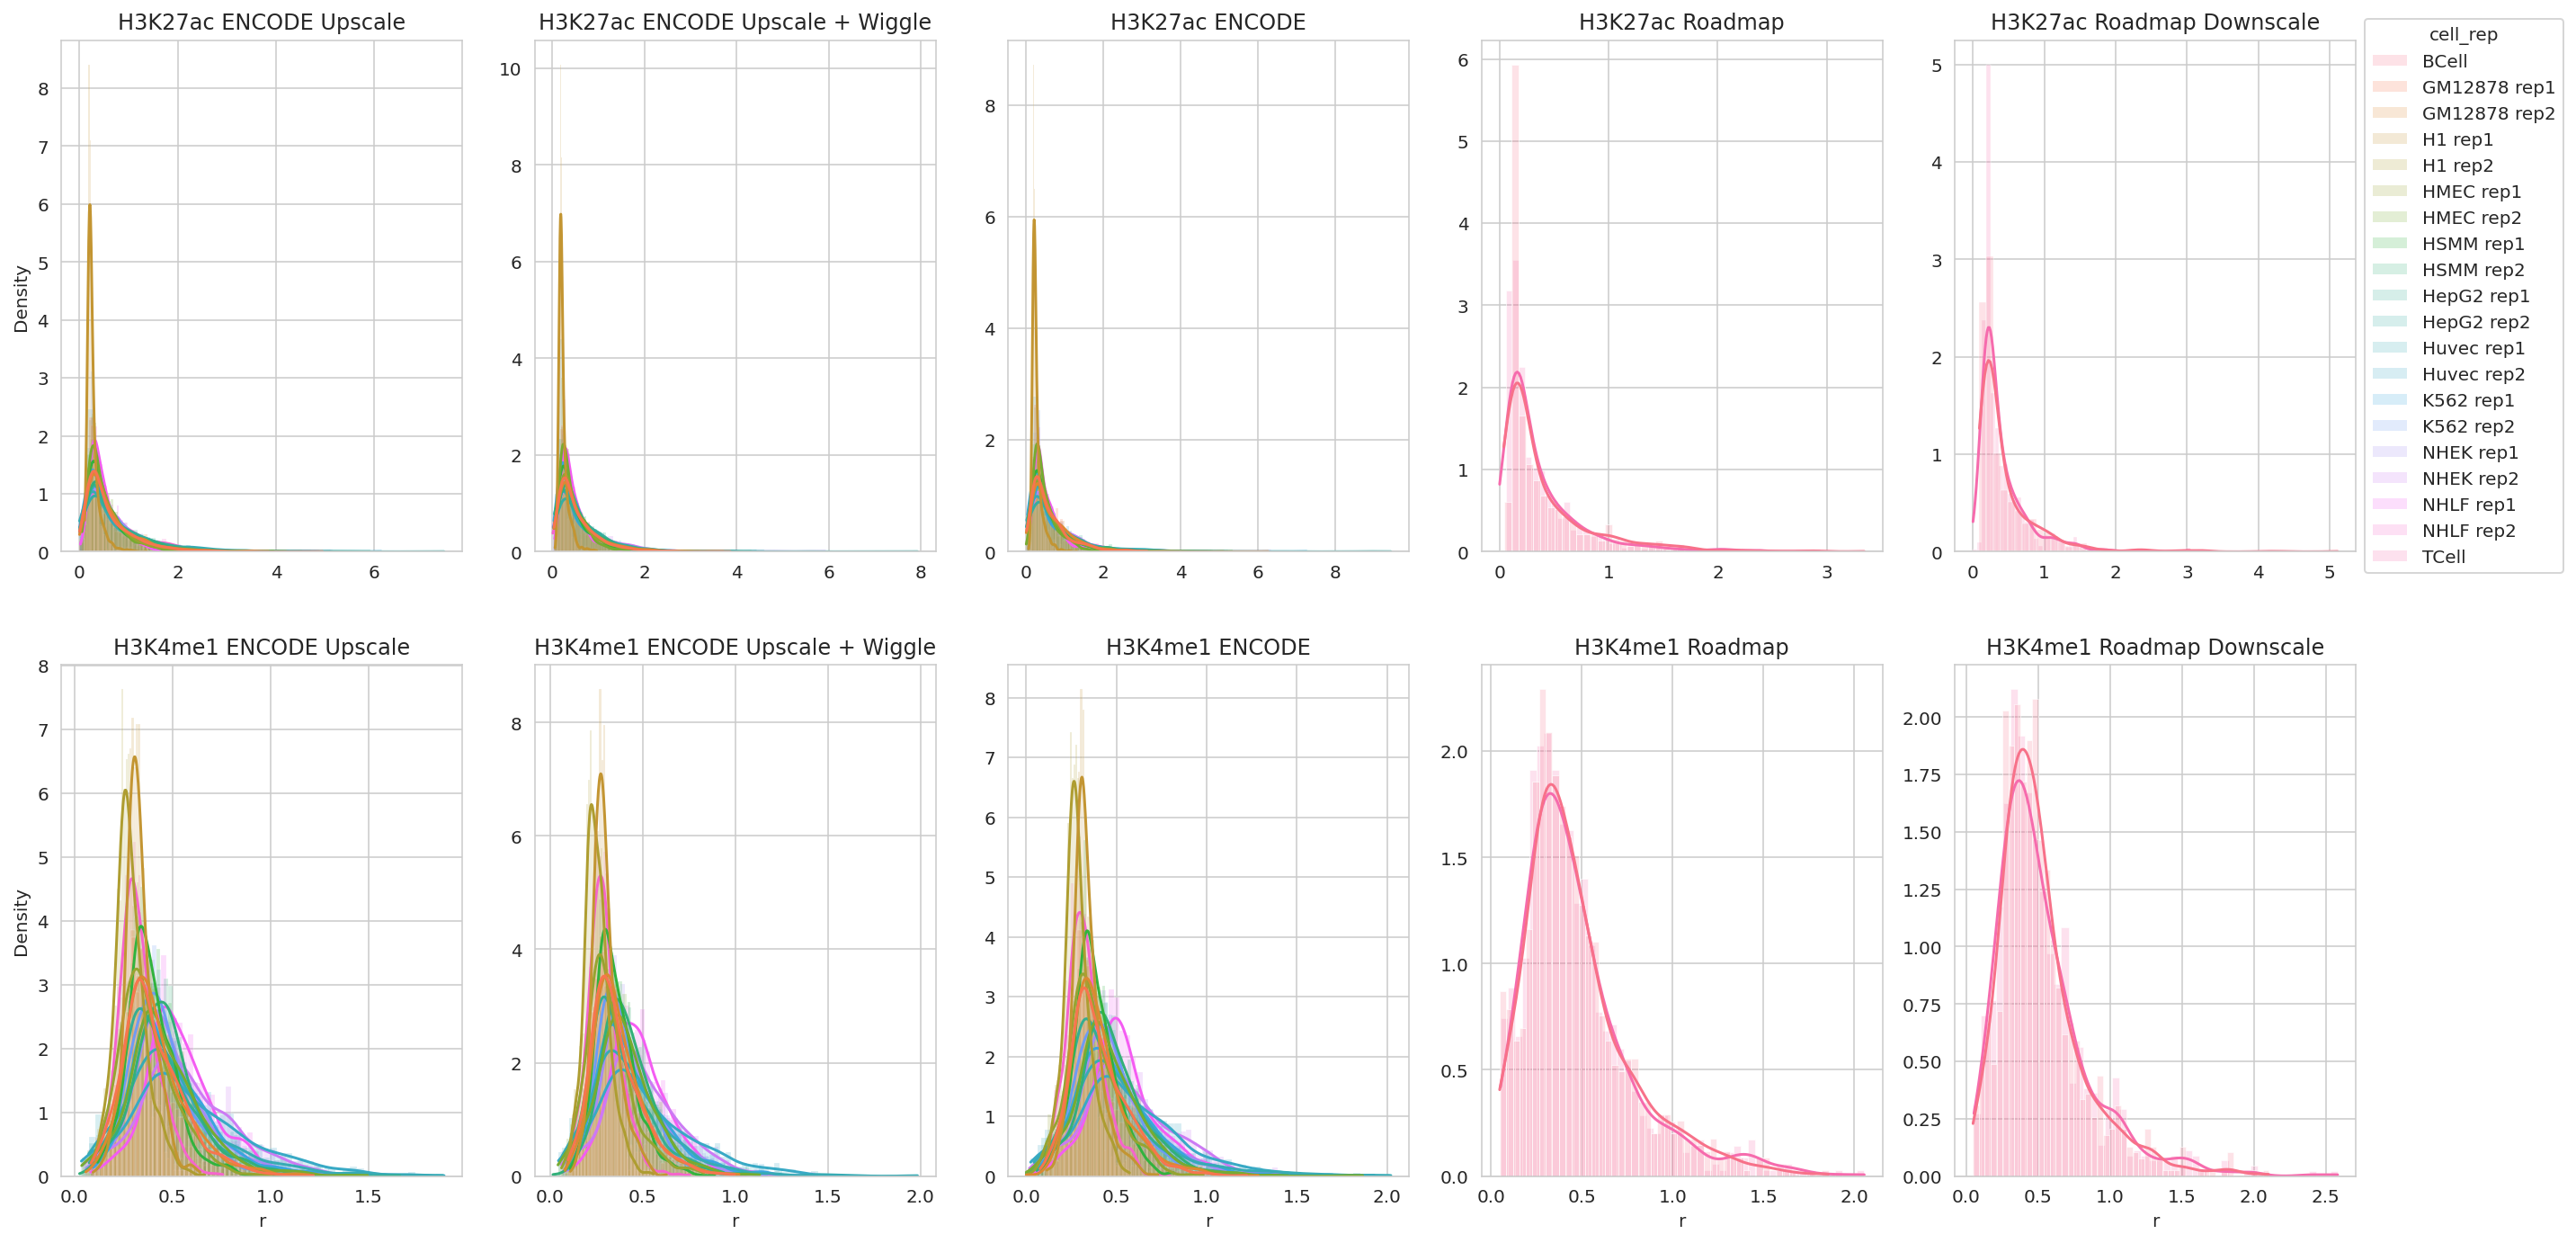

In [217]:
df_roughness['cell_rep'] = df_roughness['cell'] + ' ' + df_roughness['replicate']

plt.figure(figsize=(20, 10))
CELLS = list(wiggle_mix_peaks['cell'].unique())
axs = [plt.subplot(2, 5, i + 1) for i in range(2 * 5)]

for i, (m, name) in enumerate(product(['H3K27ac', 'H3K4me1'], df_roughness['name'].unique())):
    print(m, name)
    ax = axs[i]
    g_results = sns.histplot(data=df_roughness[(df_roughness['modification']==m) & (df_roughness['name']==name)],
                             x='r', hue='cell_rep',
                             hue_order=list(sorted(df_roughness['cell_rep'].unique())),
                             ax=ax, stat='density', common_bins=False, common_norm=False,
                             bins=50, kde=True, alpha=0.2
                             )
    if (i + 1) == 5:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i % 5 != 0:
        ax.set_ylabel(None)
    if i < 5:
        # ax.set_xticks([], minor=False)
        # g_results.axes.set_xticklabels([])
        ax.set_xlabel(None)
    ax.set_title(f'{m} {name}')
    # ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()

## Aggregate roughness by sample

In [218]:
df_roughness_aggr = df_roughness[
    ['modification', 'cell', 'replicate', 'type', 'name', 'coverage', 'ra', 'rq', 'r']
].groupby(['modification', 'cell', 'replicate', 'type', 'name']).agg('mean').reset_index()
df_roughness_aggr.sample(3)

modification  cell replicate                 type                     name  \
77      H3K4me1  HSMM      rep1  x2_N10_w80_20_N2000  ENCODE Upscale + Wiggle   
94      H3K4me1  K562      rep2               x2_N10           ENCODE Upscale   
71      H3K4me1  HMEC      rep1  x2_N10_w80_20_N2000  ENCODE Upscale + Wiggle   

     coverage          ra          rq         r  
77  329.28155  116.301678  155.382709  0.353198  
94  386.19535  172.502574  234.176569  0.446672  
71  663.38185  214.684803  288.534809  0.323622

## Additional annotation

In [219]:
t = df_wiggle_bams.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
# t['scale'] = t['upscale']

t2 = df_bams[df_bams['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t2['type'] = t2['dataset']
t2['scale'] = [0.5 if ds == 'ENCODE' else 2.5 for ds in t2['dataset']]
t2['wiggle'] = 0.0

t3 = df_immune_10m_bams.copy()
t3['type'] = 'Roadmap_10M'
t3['scale'] = 2.2
t3['wiggle'] = 0.0

all_bams_df = pd.concat([t, t2, t3]).reset_index(drop=True)
all_bams_df

bam_file modification   cell  \
0    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   K562   
1    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HSMM   
2    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   NHEK   
3    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HSMM   
4    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  Huvec   
..                                                 ...          ...    ...   
105  /home/jetbrains/data/2023_Immune/bams/TCell_H3...      H3K27ac  TCell   
106  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  BCell   
107  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  TCell   
108  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  TCell   
109  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  BCell   

    replicate     reads                 type  upscale  wiggle  dataset  scale  
0        rep2  12360187  x2_N10_w80_20_N2000      2.0  2000.0      NaN    NaN  
1        rep1  16160664               x2_N10      2.0     0.0      NaN    NaN  
2        rep1  18755229  x2_N10_w80_20_N2000      2.0  2000.0      NaN    NaN  
3        rep2  16416791  x2_N10_w80_20_N2000      2.0  2000.0      NaN    NaN  
4        rep1  20920470               x2_N10      2.0     0.0      NaN    NaN  
..        ...       ...                  ...      ...     ...      ...    ...  
105            30425955              Roadmap      NaN     0.0  Roadmap    2.5  
106             9998693          Roadmap_10M      NaN     0.0      NaN    2.2  
107             9998681          Roadmap_10M      NaN     0.0      NaN    2.2  
108            10002191          Roadmap_10M      NaN     0.0      NaN    2.2  
109             9999314          Roadmap_10M      NaN     0.0      NaN    2.2  

[110 rows x 10 columns]

In [220]:
reads = []
peaks = {tool: [] for tool in TOOLS}
for _, (m, c, r, ty) in df_roughness_aggr[['modification', 'cell', 'replicate', 'type']].iterrows():
    t = all_bams_df[(all_bams_df['modification'] == m) & 
                    (all_bams_df['cell'] == c) & 
                    (all_bams_df['replicate'] == r) & 
                    (all_bams_df['type'] == ty)]
    if len(t) == 0:
        reads.append(None)
    else:
        reads.append(t['reads'].values[0])
    for tool in TOOLS:
        t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
                                          (wiggle_mix_original_all_peaks['cell'] == c) &
                                          (wiggle_mix_original_all_peaks['replicate'] == r) &
                                          (wiggle_mix_original_all_peaks['type'] == ty) &
                                          (wiggle_mix_original_all_peaks['tool'] == tool)]
        if len(t) == 0:
            peaks[tool].append(None)
        else:
            peaks[tool].append(t['peaks'].values[0])
        

df_roughness_aggr['reads'] = reads
for tool in TOOLS:
    df_roughness_aggr[tool] = peaks[tool]

df_roughness_aggr.sample(5)

modification   cell replicate                 type  \
105      H3K4me1   NHLF      rep2               ENCODE   
36       H3K27ac   K562      rep1               x2_N10   
35       H3K27ac   K562      rep1               ENCODE   
28       H3K27ac  HepG2      rep2  x2_N10_w80_20_N2000   
107      H3K4me1   NHLF      rep2  x2_N10_w80_20_N2000   

                        name   coverage          ra          rq         r  \
105                   ENCODE  280.35835   91.219022  120.999821  0.325366   
36            ENCODE Upscale  458.04940  271.905916  457.182878  0.593617   
35                    ENCODE  235.13965  136.170208  235.207374  0.579104   
28   ENCODE Upscale + Wiggle  211.74525  145.375340  250.191546  0.686558   
107  ENCODE Upscale + Wiggle  570.11660  166.219920  218.731706  0.291554   

        reads  MACS2  MACS2 broad   SPAN  SICER  
105  14040463  34236        43243  94069  72197  
36   23409424  53234        59894  41209  55459  
35   11704712  53699        39486  26221  26929  
28   10264711  23699        24350  24345  24668  
107  28080925  14641        19657  86318  65746

In [221]:
rfile = f'{WD}/roughness_{BIN}bp_{NBINS}_{ROUGHNESS_BIN}.csv.gz'
print(rfile)
df_roughness_aggr.to_csv(rfile, compression='gzip', index=None)
# pd.read_csv(f'{WD}/roughness_{BIN}bp_{NBINS}_{ROUGHNESS_BIN}.csv.gz', compression='gzip').sample(5)

/home/jetbrains/data/2023_GSE26320_wiggle_mix/roughness_10000bp_10000_100.csv.gz


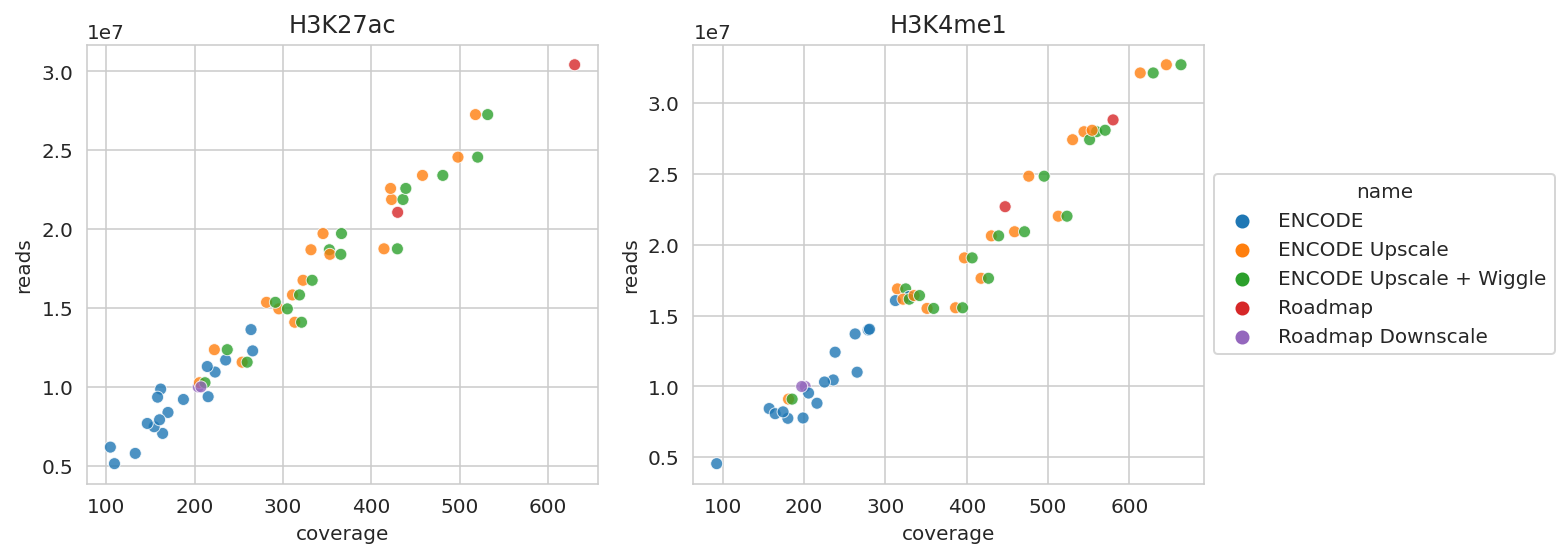

In [222]:
plot_modifications_simple(df_roughness_aggr, 'coverage', 'reads')

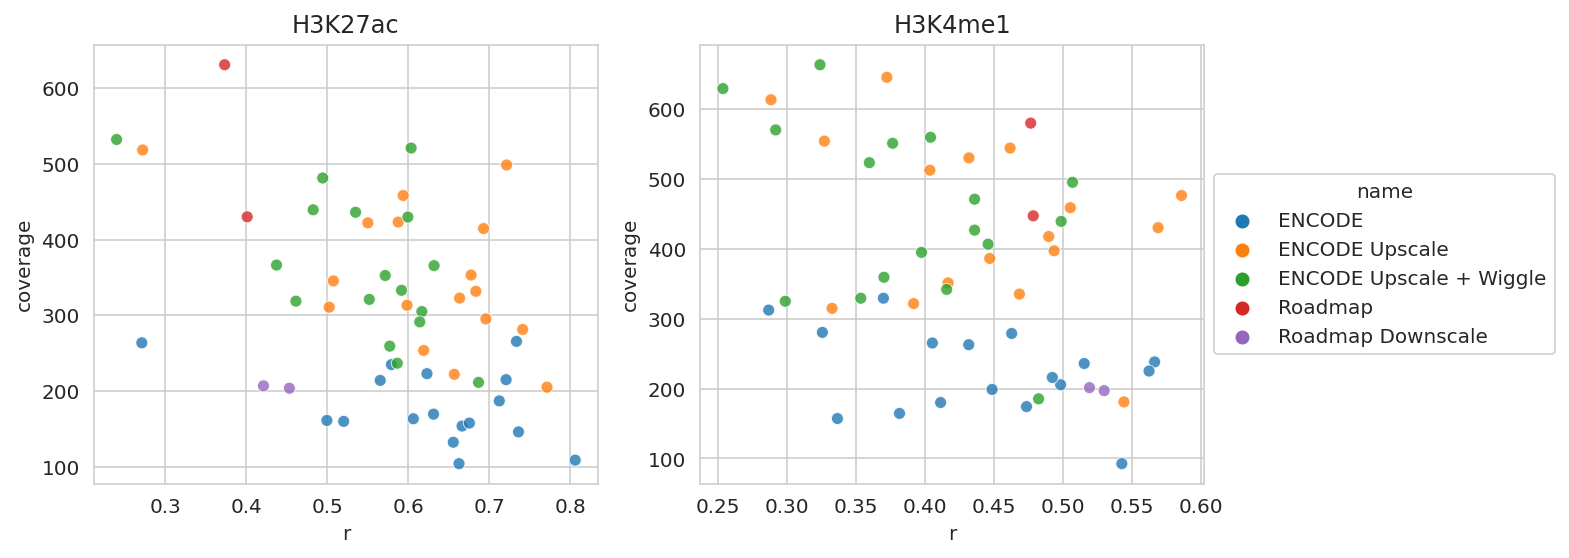

In [223]:
plot_modifications_simple(df_roughness_aggr, 'r', 'coverage')

## Modifications visualization

In [224]:
def plot_wiggle_dataset(df, X, Y, big, texts, textcenter=True, colorcol=None, x0line=False, y0line=False):
    sns.set_style("white")
    plt.figure(figsize=(11, 4))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        ax = axs[i]
        t = df[df['modification'] == m].copy()
        t['size'] = [2 if ty in big else 1 for ty in t['name']]

        # scales = ['', 'x2_N20']
        # wiggles = ['', 'w80_20_N5000']
        scales = ['', 'x2_N10']
        wiggles = ['', 'w80_20_N2000']
        for _, (c, r) in t[['cell', 'replicate']].drop_duplicates().iterrows():
            for (sc, wg) in product(scales, wiggles):
                if sc == '' and wg == '':
                    continue
                if sc == '':
                    s = 'ENCODE'
                    e = wg
                    color = 'darkblue'
                elif wg == '':
                    s = 'ENCODE'
                    e = sc
                    color = 'green'
                else:
                    s = sc
                    e = f'{sc}_{wg}'
                    color = 'blue'
                p1 = t[(t['cell'] == c) & (t['replicate'] == r) & (t['type'] == s)]
                p2 = t[(t['cell'] == c) & (t['replicate'] == r) & (t['type'] == e)]
                if len(p1) == 0 or len(p2) == 0:
                    continue
                p1x = p1[X].values[0]
                p1y = p1[Y].values[0]
                p2x = p2[X].values[0]
                p2y = p2[Y].values[0]
                sns.lineplot(x=[p1x, p2x], y=[p1y, p2y], color=color, ax=ax, alpha=0.5, linestyle='dotted')
            p1 = t[(t['cell'] == c) & (t['replicate'] == r) & (t['type'] == 'Roadmap')]
            p2 = t[(t['cell'] == c) & (t['replicate'] == r) & (t['type'] == 'Roadmap_10M')]
            if len(p1) == 0 or len(p2) == 0:
                continue
            p1x = p1[X].values[0]
            p1y = p1[Y].values[0]
            p2x = p2[X].values[0]
            p2y = p2[Y].values[0]
            sns.lineplot(x=[p1x, p2x], y=[p1y, p2y], color='red', ax=ax, alpha=0.5, linestyle='dotted')
        
        if colorcol is None:
            sns.scatterplot(data=t,
                            x=X, y=Y, hue='name', ax=ax, size='size',
                            hue_order=sorted(df['name'].unique()))
        else:
            sns.scatterplot(data=t,
                            x=X, y=Y, hue=colorcol, palette='Blues', ax=ax, size='size')

        for x, y, cell, replicate, ty in zip(t[X], t[Y], t['cell'], t['replicate'], t['name']):
            if ty in texts and (textcenter or (math.fabs(x) > 1e-3 or math.fabs(y) > 1e-3)):
                ax.text(x, y, f'{cell} {replicate}', fontsize = 5)
                
        if x0line:
            sns.lineplot(x=[0, 0], y=[t[Y].min(), t[Y].max()], color='black', ax=ax, alpha=0.5, linestyle='dotted')
        if y0line:
            sns.lineplot(x=[t[X].min(), t[X].max()], y=[0, 0], color='black', ax=ax, alpha=0.5, linestyle='dotted')

        ax.title.set_text(m)
        if i == 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.show()
    sns.set_style("whitegrid")

Modification scheme


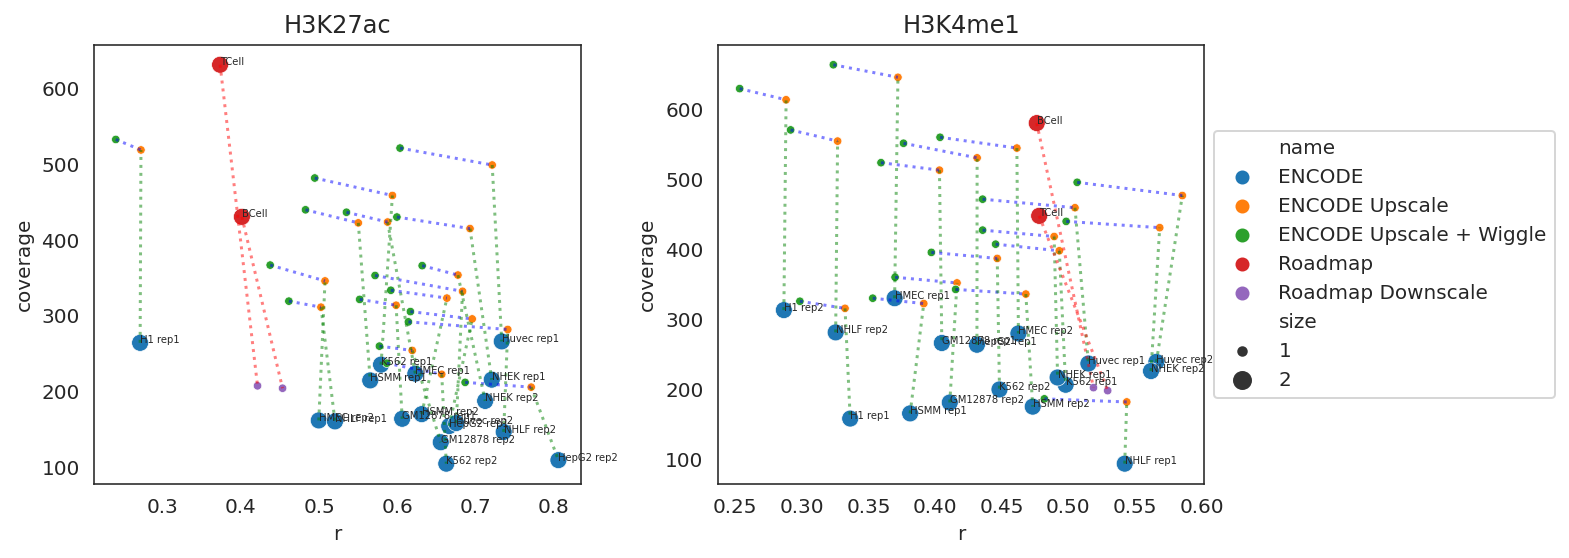

In [225]:
print('Modification scheme')

X = 'r'
Y = 'coverage'
big = ['Roadmap', 'ENCODE']
texts = ['Roadmap', 'ENCODE']

plot_wiggle_dataset(df_roughness_aggr, X, Y, big, texts, True)


In [241]:
# H3K27AC_SAMPLES = [('K562', 'rep1'), ('HSMM', 'rep1'), ('HMEC', 'rep2')]
# H3K4ME1_SAMPLES = [('HMEC', 'rep2'), ('NHEK', 'rep1'), ('NHEK', 'rep2'), ('Huvec', 'rep1'), ('K562', 'rep1')]

# Find samples with roughness higher than in Roadmap
SAMPLES = {}
for m in ['H3K27ac', 'H3K4me1']:
    SAMPLES[m] = []
    roadmap_r_max = df_roughness_aggr[(df_roughness_aggr['modification'] == m) & (df_roughness_aggr['type'] == 'Roadmap')]['r'].max()
    print(m, roadmap_r_max)
    for _, (c, r) in df_roughness_aggr[(df_roughness_aggr['modification'] == m) & 
                                       (df_roughness_aggr['type'] == 'ENCODE') & 
                                       (df_roughness_aggr['r'] > roadmap_r_max)][['cell', 'replicate']].iterrows():
        # Skip outliers
        if (m == 'H3K27ac' and c == 'HepG2' and r == 'rep2' or 
            m == 'H3K4me1' and (c == 'NHLF' and r == 'rep1' or c == 'HSMM' and r == 'rep2')):
            continue
        SAMPLES[m].append((c, r))

H3K27AC_SAMPLES = SAMPLES['H3K27ac']
H3K4ME1_SAMPLES = SAMPLES['H3K4me1']

H3K27ac 0.4012042508899649
H3K4me1 0.4781849616073195


Modification scheme


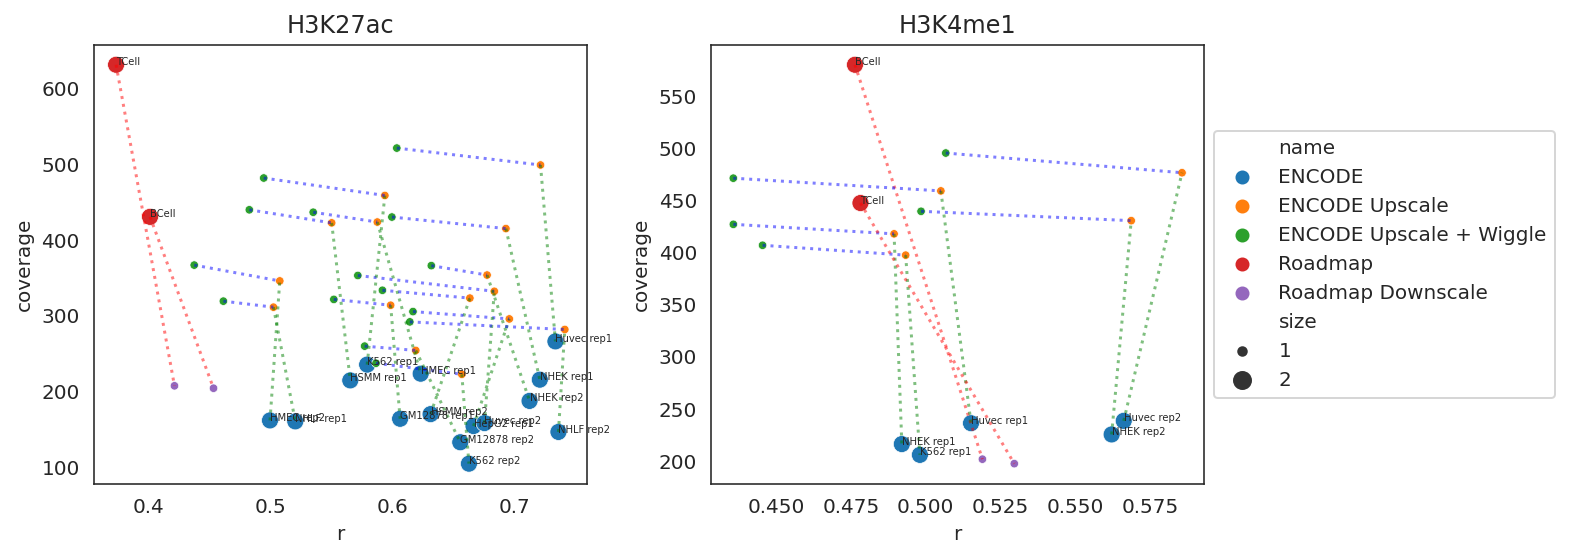

In [242]:
print('Modification scheme')

X = 'r'
Y = 'coverage'
t = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
    (((df_roughness_aggr['modification'] == 'H3K27ac') & 
      ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
     ((df_roughness_aggr['modification'] == 'H3K4me1') & 
      ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()
# big = ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
big = ['Roadmap', 'ENCODE']
texts = ['Roadmap', 'ENCODE']

plot_wiggle_dataset(t, X, Y, big, texts, True)


MACS2


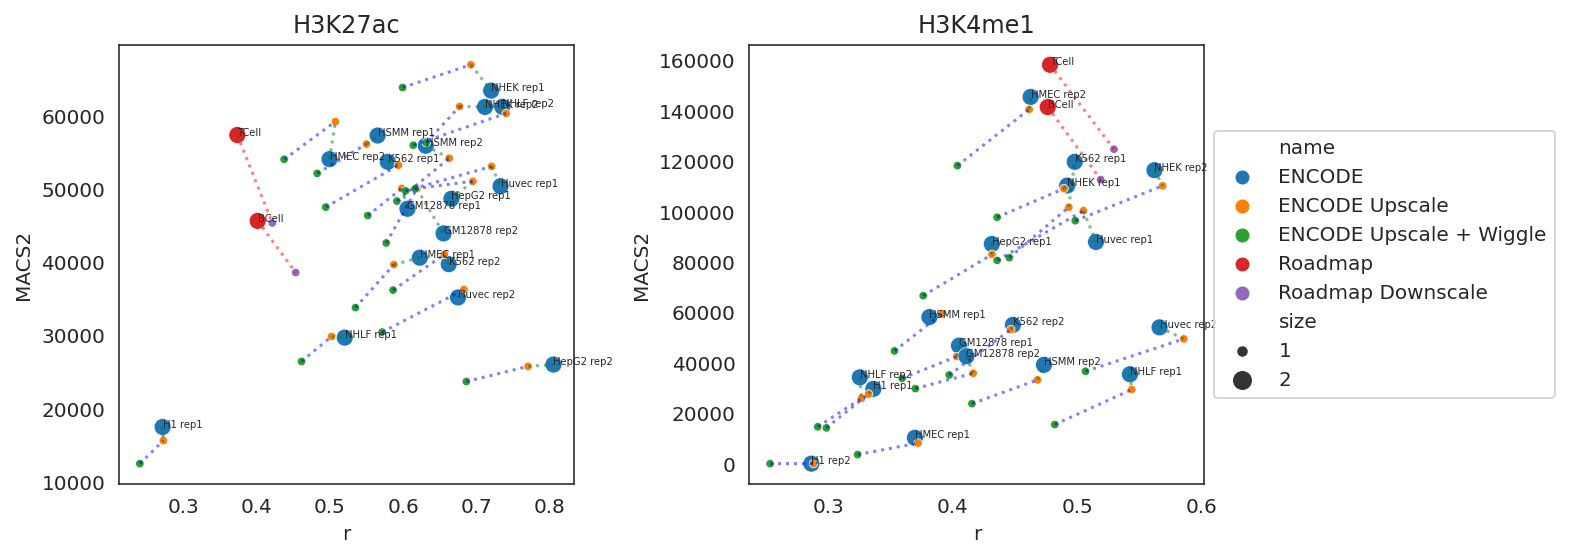

MACS2 broad


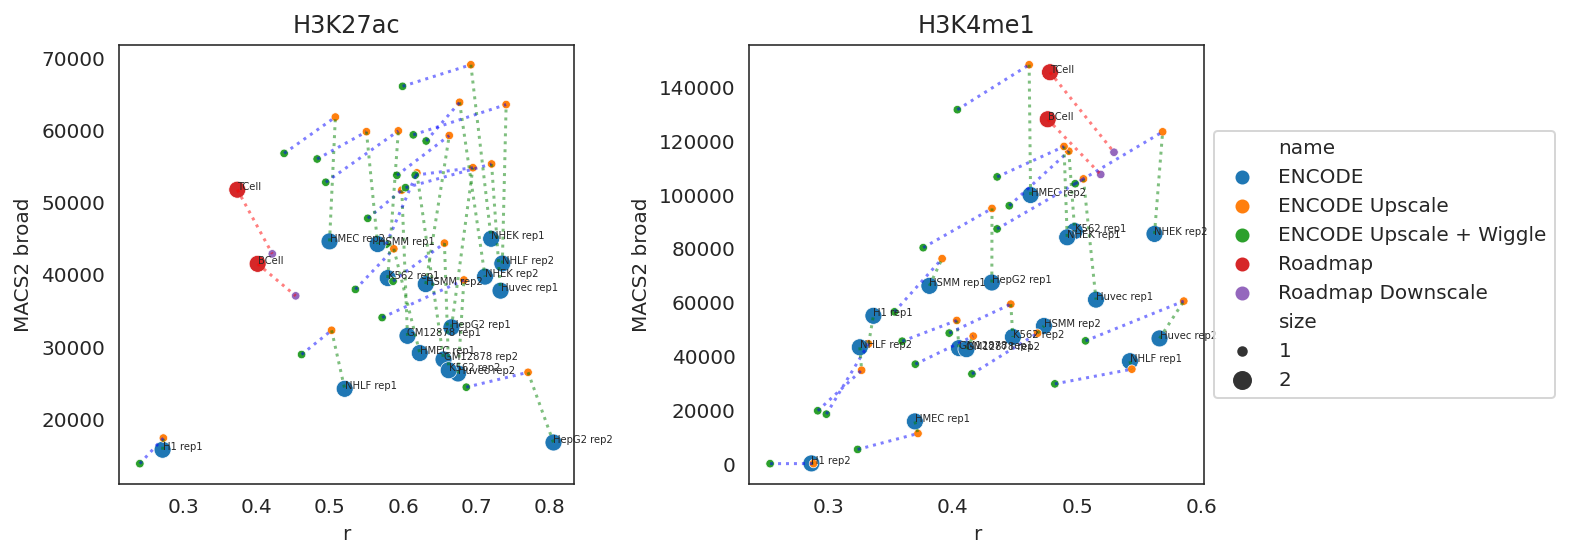

SPAN


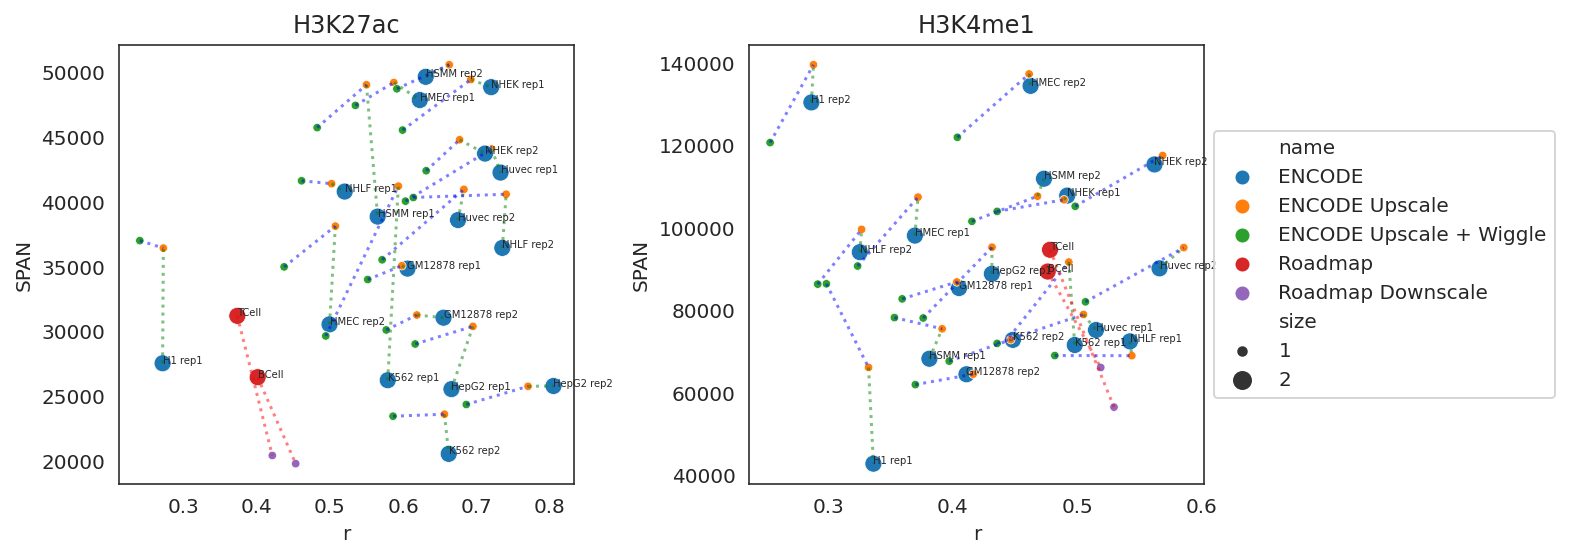

SICER


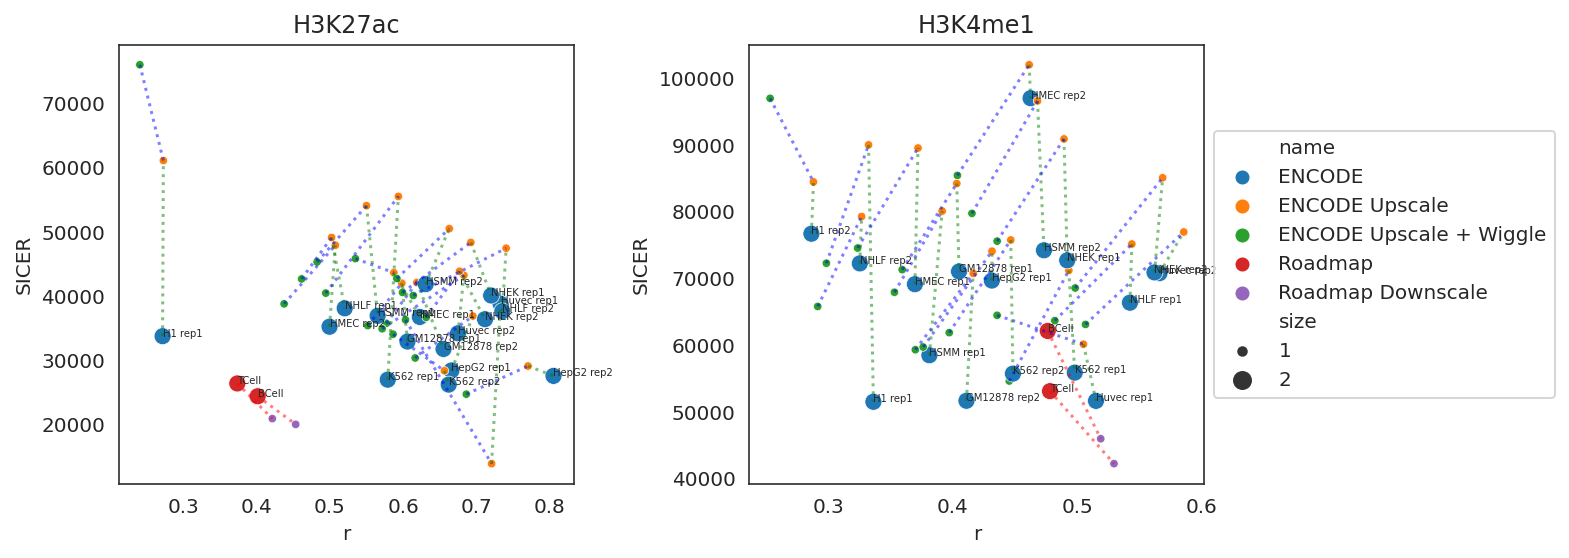

In [243]:
for Y in TOOLS:
    print(Y)
    X = 'r'
    big = ['ENCODE', 'Roadmap']
    texts = ['Roadmap', 'ENCODE']
    plot_wiggle_dataset(df_roughness_aggr, 'r', Y, big, texts, True)

MACS2


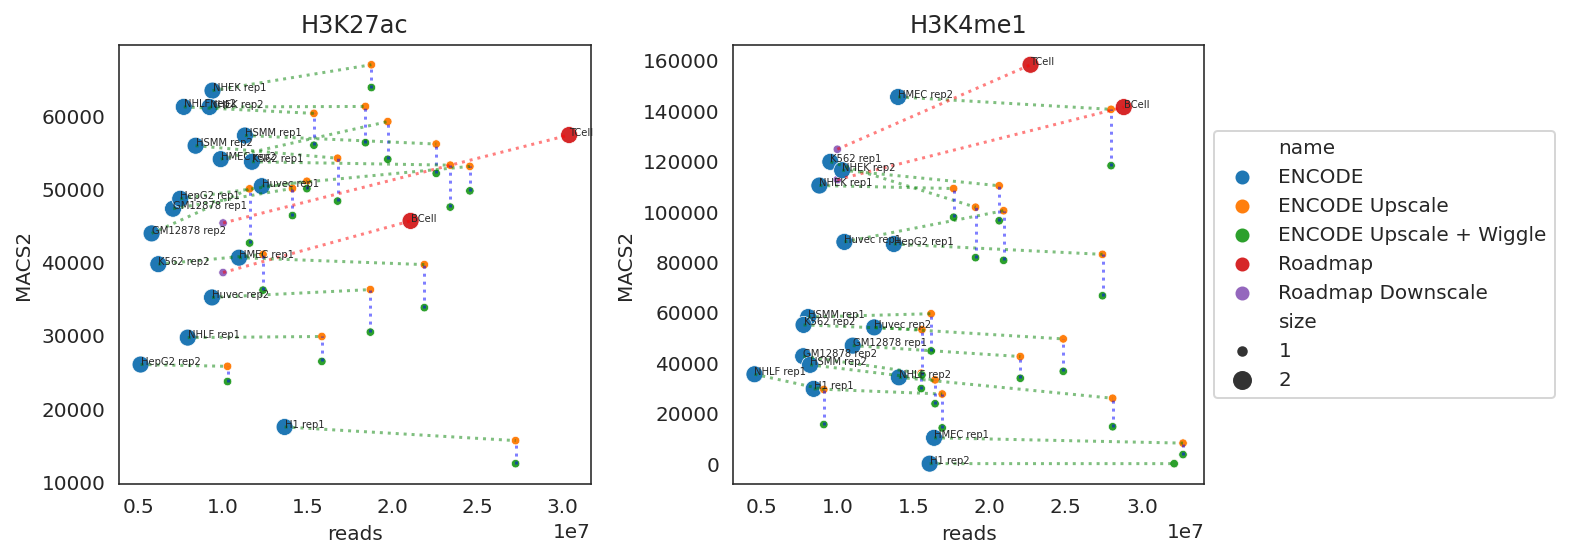

MACS2 broad


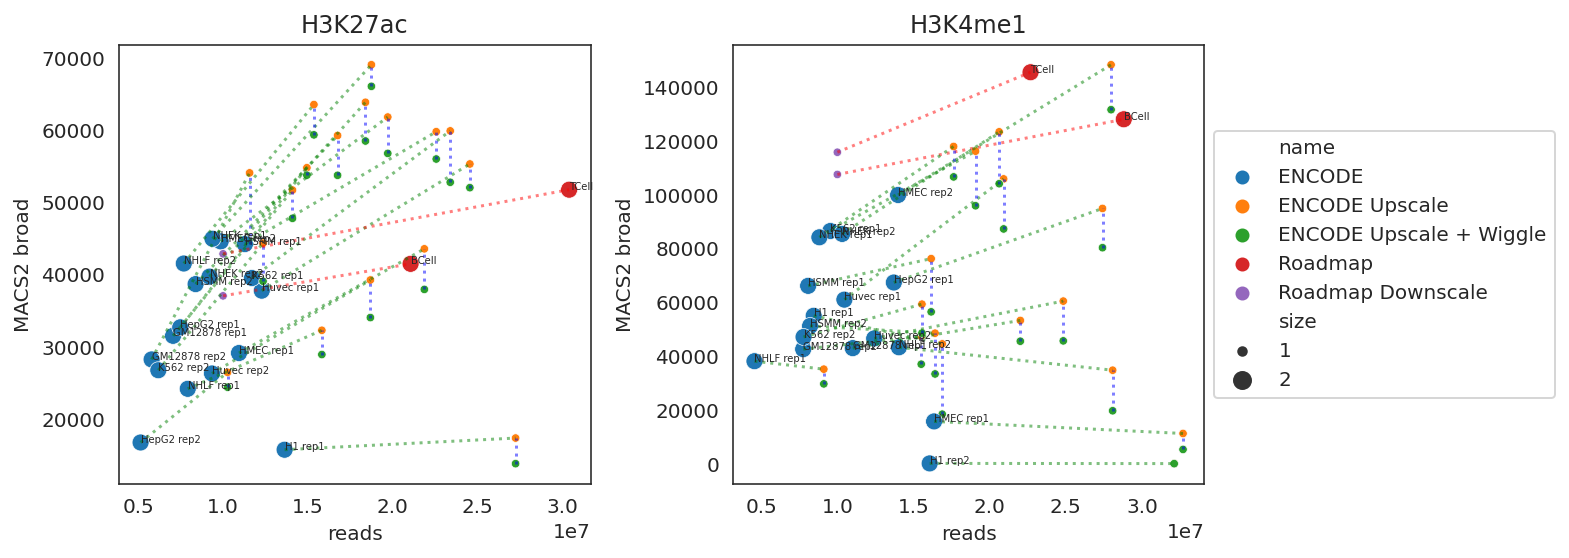

SPAN


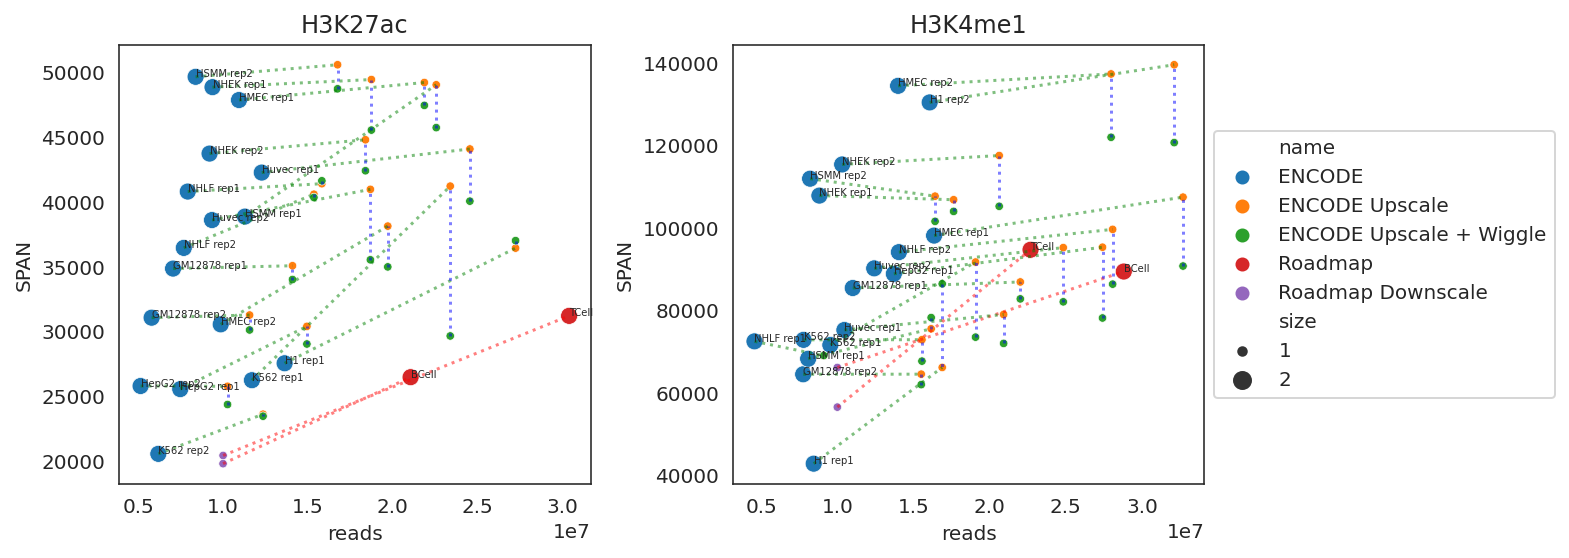

SICER


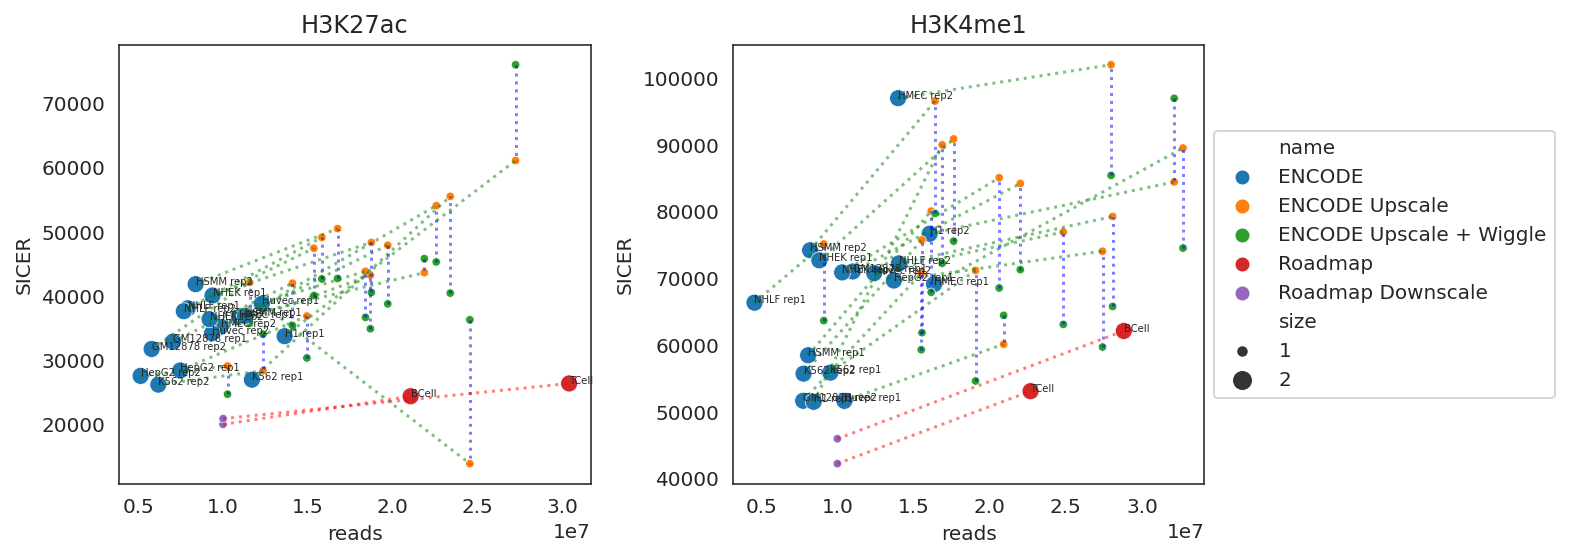

In [244]:
for Y in TOOLS:
    print(Y)
    X = 'r'
    big = ['ENCODE', 'Roadmap']
    texts = ['Roadmap', 'ENCODE']
    plot_wiggle_dataset(df_roughness_aggr, 'reads', Y, big, texts, True)

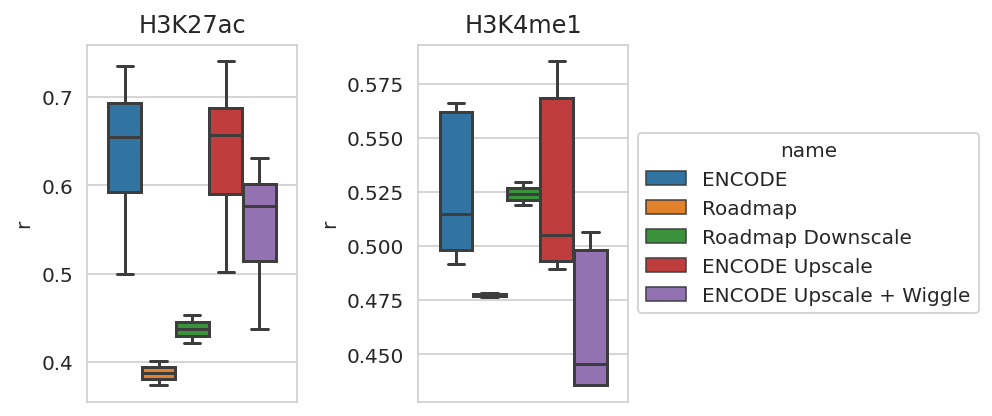

In [245]:
# df = df_roughness_aggr
df = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
                      (((df_roughness_aggr['modification'] == 'H3K27ac') &
                        ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
                       ((df_roughness_aggr['modification'] == 'H3K4me1') &
                        ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()

plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df[df['modification'] == m].copy()
    g_results = sns.boxplot(data=t,
                            x='modification', y='r', hue='name',
                            hue_order=['ENCODE', 'Roadmap', 'Roadmap Downscale', 'ENCODE Upscale', 'ENCODE Upscale + Wiggle'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [246]:
from scipy.stats import pearsonr, spearmanr
for tool, m in product(TOOLS, ['H3K27ac', 'H3K4me1']):
    print(tool, m)
    t = df_roughness_aggr[(df_roughness_aggr['modification'] == m) & (df_roughness_aggr['type'] == 'x2_N10_w80_20_N2000')]
    for y in ['reads', 'r']:
        corr, pval = spearmanr(t[tool], t[y])
        print(f'{m} {tool} vs {y} corr={corr:.2e} p={pval:.2e}')    

MACS2 H3K27ac
H3K27ac MACS2 vs reads corr=1.32e-01 p=6.13e-01
H3K27ac MACS2 vs r corr=3.33e-01 p=1.91e-01
MACS2 H3K4me1
H3K4me1 MACS2 vs reads corr=-9.31e-02 p=7.22e-01
H3K4me1 MACS2 vs r corr=6.35e-01 p=6.19e-03
MACS2 broad H3K27ac
H3K27ac MACS2 broad vs reads corr=1.03e-01 p=6.94e-01
H3K27ac MACS2 broad vs r corr=3.04e-01 p=2.36e-01
MACS2 broad H3K4me1
H3K4me1 MACS2 broad vs reads corr=-1.15e-01 p=6.60e-01
H3K4me1 MACS2 broad vs r corr=6.15e-01 p=8.58e-03
SPAN H3K27ac
H3K27ac SPAN vs reads corr=4.63e-01 p=6.11e-02
H3K27ac SPAN vs r corr=-1.35e-01 p=6.06e-01
SPAN H3K4me1
H3K4me1 SPAN vs reads corr=5.56e-01 p=2.04e-02
H3K4me1 SPAN vs r corr=-1.57e-01 p=5.48e-01
SICER H3K27ac
H3K27ac SICER vs reads corr=6.72e-01 p=3.16e-03
H3K27ac SICER vs r corr=-5.81e-01 p=1.45e-02
SICER H3K4me1
H3K4me1 SICER vs reads corr=3.70e-01 p=1.44e-01
H3K4me1 SICER vs r corr=-3.21e-01 p=2.09e-01


## Center by previous / original point

In [247]:
rows = []
for _, row in tqdm(df_roughness_aggr.iterrows()):
    m, c, r, ty = row['modification'], row['cell'], row['replicate'], row['type']
    if ty == 'ENCODE' or ty == 'Roadmap':
        rows.append([m, c, r, ty] + [row[t] for t in TOOLS + ['r', 'reads']] + 
                    [0] * (len(TOOLS) + 2) * 4 + 
                    [row[t] for t in TOOLS + ['r', 'reads']] * 2)
        continue
    original = 'Roadmap' if ty == 'Roadmap_10M' else 'ENCODE'
    previous = 'Roadmap' if ty == 'Roadmap_10M' else ('x2_N10' if ty == 'x2_N10_w80_20_N2000' else 'ENCODE')
    t_original = df_roughness_aggr[(df_roughness_aggr['modification'] == m) &
                                   (df_roughness_aggr['cell'] == c) &
                                   (df_roughness_aggr['replicate'] == r) &
                                   (df_roughness_aggr['type'] == original)]
    t_previous = df_roughness_aggr[(df_roughness_aggr['modification'] == m) &
                                   (df_roughness_aggr['cell'] == c) &
                                   (df_roughness_aggr['replicate'] == r) &
                                   (df_roughness_aggr['type'] == previous)]    
    if len(t_original) == 0 or len(t_previous) == 0:
        continue
    
    data = [m, c, r, ty]
    data.extend([row[col] for col in TOOLS + ['r', 'reads']])
    data.extend([row[col] - t_original[col].values[0] for col in TOOLS + ['r', 'reads']])
    data.extend([int(100 * d(row[col] - t_original[col].values[0], t_original[col].values[0])) for col in TOOLS + ['r', 'reads']])
    data.extend([row[col] - t_previous[col].values[0] for col in TOOLS + ['r', 'reads']])
    data.extend([int(100 * d(row[col] - t_previous[col].values[0], t_previous[col].values[0])) for col in TOOLS + ['r', 'reads']])
    data.extend([t_original[tl].values[0] for tl in TOOLS + ['r', 'reads']])
    data.extend([t_previous[tl].values[0] for tl in TOOLS + ['r', 'reads']])
    rows.append(data)
df_roughness_aggr_z = pd.DataFrame(rows, 
                                   columns=['modification', 'cell', 'replicate', 'type'] + TOOLS + ['r', 'reads'] +
                                           [f'diff vs original {t}' for t in TOOLS + ['r', 'reads']] +
                                           [f'diff% vs original {t}' for t in TOOLS + ['r', 'reads']] +
                                           [f'diff vs previous {t}' for t in TOOLS + ['r', 'reads']] +
                                           [f'diff% vs previous {t}' for t in TOOLS + ['r', 'reads']] +
                                           [f'original {t}' for t in TOOLS + ['r', 'reads']] +
                                           [f'previous {t}' for t in TOOLS + ['r', 'reads']])
df_roughness_aggr_z.sample(5)

0it [00:00, ?it/s]

modification     cell replicate                 type   MACS2  MACS2 broad  \
64      H3K4me1       H1      rep1               x2_N10   27619        44507   
97      H3K4me1     NHEK      rep1               x2_N10  109105       117856   
13      H3K27ac     HMEC      rep1  x2_N10_w80_20_N2000   33787        37912   
14      H3K27ac     HMEC      rep2               ENCODE   54056        44570   
3       H3K27ac  GM12878      rep1               x2_N10   50061        51686   

      SPAN  SICER         r     reads  ...  original SPAN  original SICER  \
64   66143  89953  0.332390  16886890  ...          42833           51468   
97  106766  90842  0.489419  17635032  ...         107773           72654   
13   47445  45769  0.534905  21881489  ...          47858           36689   
14   30534  35171  0.499512   9860687  ...          30534           35171   
3    35061  41948  0.598354  14098116  ...          34842           32861   

    original r  original reads  previous MACS2  previous MACS2 broad  \
64    0.336292         8443445           29669                 54953   
97    0.492006         8817516          110303                 84110   
13    0.622950        10940745           39661                 43537   
14    0.499512         9860687           54056                 44570   
3     0.606112         7049058           47290                 31476   

    previous SPAN  previous SICER  previous r  previous reads  
64          42833           51468    0.336292         8443445  
97         107773           72654    0.492006         8817516  
13          49210           43585    0.587438        21881490  
14          30534           35171    0.499512         9860687  
3           34842           32861    0.606112         7049058  

[5 rows x 46 columns]

In [248]:
from scipy.stats import pearsonr, spearmanr
for tool, m in product(TOOLS, ['H3K27ac', 'H3K4me1']):
    print(tool, m)
    t = df_roughness_aggr_z[(df_roughness_aggr_z['modification'] == m) & (df_roughness_aggr_z['type'] == 'x2_N10_w80_20_N2000')]
    dt = f'diff vs original {tool}'
    corr, pval = spearmanr(t[dt], t['original r'])
    print(f'{m} {dt} vs original r corr={corr:.2e} p={pval:.2e}')

    dt = f'diff vs original {tool}'
    ot = f'original {tool}'
    corr, pval = spearmanr(t[dt], t[ot])
    print(f'{m} {dt} vs {ot} corr={corr:.2e} p={pval:.2e}')
 

MACS2 H3K27ac
H3K27ac diff vs original MACS2 vs original r corr=1.99e-01 p=4.45e-01
H3K27ac diff vs original MACS2 vs original MACS2 corr=-2.94e-02 p=9.11e-01
MACS2 H3K4me1
H3K4me1 diff vs original MACS2 vs original r corr=-4.00e-01 p=1.12e-01
H3K4me1 diff vs original MACS2 vs original MACS2 corr=-5.17e-01 p=3.35e-02
MACS2 broad H3K27ac
H3K27ac diff vs original MACS2 broad vs original r corr=4.51e-01 p=6.92e-02
H3K27ac diff vs original MACS2 broad vs original MACS2 broad corr=6.32e-01 p=6.45e-03
MACS2 broad H3K4me1
H3K4me1 diff vs original MACS2 broad vs original r corr=4.95e-01 p=4.33e-02
H3K4me1 diff vs original MACS2 broad vs original MACS2 broad corr=5.69e-01 p=1.72e-02
SPAN H3K27ac
H3K27ac diff vs original SPAN vs original r corr=-6.42e-01 p=5.45e-03
H3K27ac diff vs original SPAN vs original SPAN corr=-4.36e-01 p=8.00e-02
SPAN H3K4me1
H3K4me1 diff vs original SPAN vs original r corr=-1.59e-01 p=5.41e-01
H3K4me1 diff vs original SPAN vs original SPAN corr=-8.50e-01 p=1.52e-05
SICER

In [249]:
df_roughness_aggr_z['name'] = df_roughness_aggr_z['type']
df_roughness_aggr_z.loc[df_roughness_aggr_z['type'] == 'Roadmap_10M', 'name'] = 'Roadmap Downscale'
df_roughness_aggr_z.loc[df_roughness_aggr_z['type'] == 'x2_N10', 'name'] = 'ENCODE Upscale'
df_roughness_aggr_z.loc[df_roughness_aggr_z['type'] == 'x2_N10_w80_20_N2000', 'name'] = 'ENCODE Upscale + Wiggle'

ENCODE Upscale
H3K27ac
H3K4me1


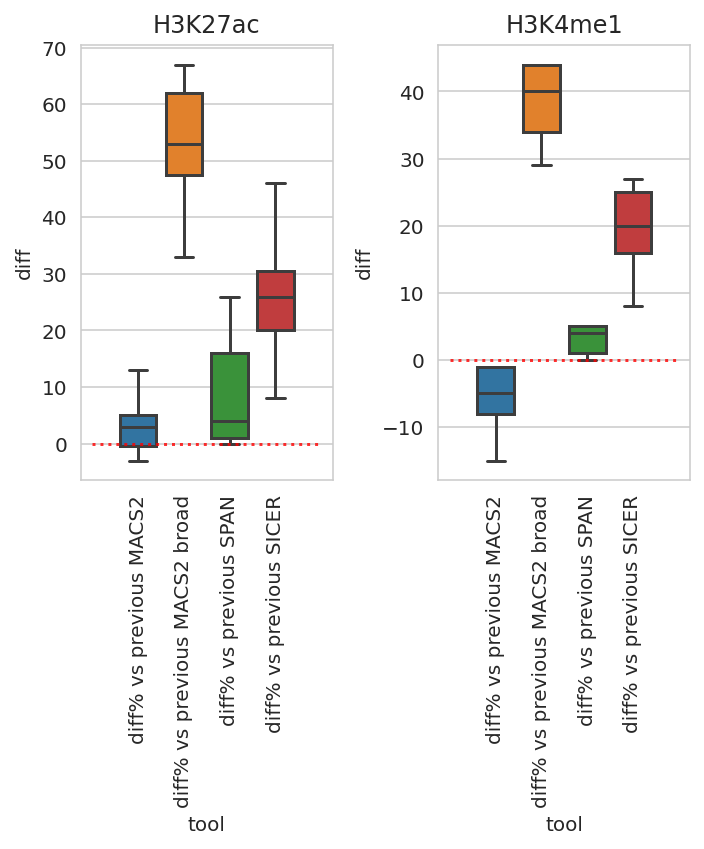

ENCODE Upscale + Wiggle
H3K27ac
H3K4me1


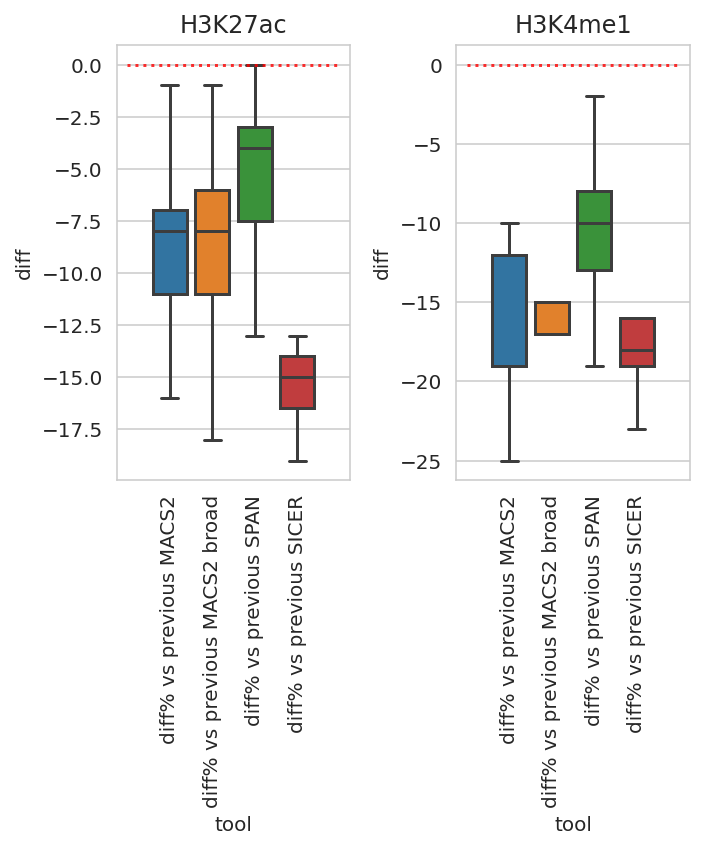

In [250]:
# df = df_roughness_aggr_z
df = df_roughness_aggr_z[(df_roughness_aggr_z['name'].str.contains('Roadmap')) |
                       (((df_roughness_aggr_z['modification'] == 'H3K27ac') &
                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])) |
                        ((df_roughness_aggr_z['modification'] == 'H3K4me1') &
                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])))].copy()

DIFF_TOOLS = [f'diff% vs previous {t}' for t in TOOLS]
for name in ['ENCODE Upscale', 'ENCODE Upscale + Wiggle']:
    print(name)
    plt.figure(figsize=(5, 6))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        t = df[(df['modification'] == m) & (df['name'] == name)].copy()
        t = pd.melt(t, id_vars=['modification', 'cell', 'replicate'], value_vars=DIFF_TOOLS)
        t2 = df[(df['modification'] == m)].copy()
        g_results = sns.boxplot(data=t,
                                x='variable', y='value',
                                order=DIFF_TOOLS,
                                showfliers=False,
                                ax=ax)
        sns.lineplot(x=[-1, 4], y=[0, 0], color='red', ax=ax, alpha=0.8, linestyle='dotted')
        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        ax.set_xlabel('tool')
        ax.set_ylabel('diff')

    plt.tight_layout()
    plt.show()

ENCODE Upscale + Wiggle
H3K27ac
H3K4me1


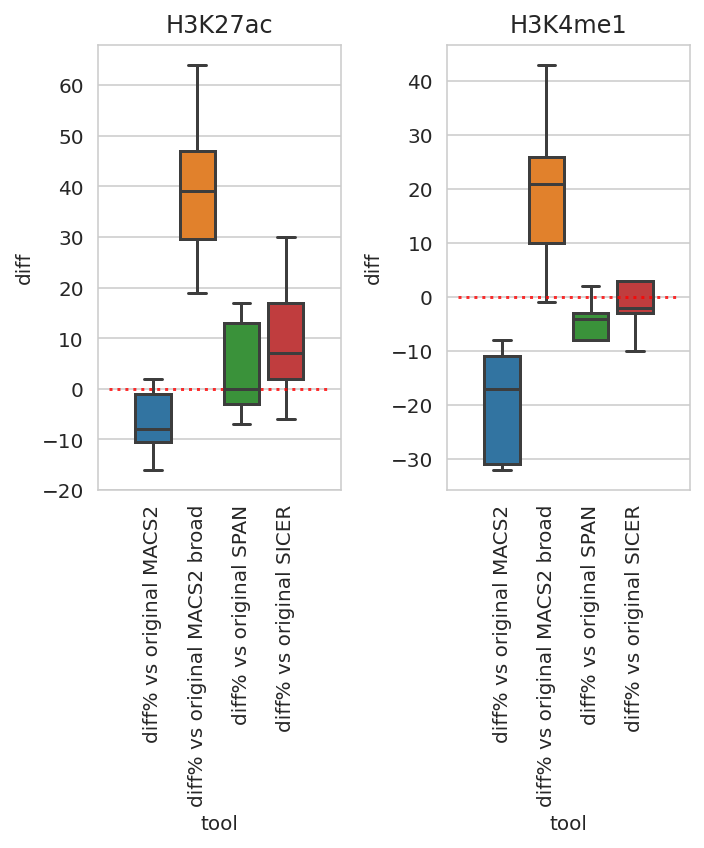

In [251]:
# df = df_roughness_aggr_z
df = df_roughness_aggr_z[(df_roughness_aggr_z['name'].str.contains('Roadmap')) |
                         (((df_roughness_aggr_z['modification'] == 'H3K27ac') &
                           ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])) |
                          ((df_roughness_aggr_z['modification'] == 'H3K4me1') &
                           ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])))].copy()

DIFF_TOOLS = [f'diff% vs original {t}' for t in TOOLS]
for name in ['ENCODE Upscale + Wiggle']:
    print(name)
    plt.figure(figsize=(5, 6))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        t = df[(df['modification'] == m) & (df['name'] == name)].copy()
        t = pd.melt(t, id_vars=['modification', 'cell', 'replicate'], value_vars=DIFF_TOOLS)
        t2 = df[(df['modification'] == m)].copy()
        g_results = sns.boxplot(data=t,
                                x='variable', y='value',
                                order=DIFF_TOOLS,
                                showfliers=False,
                                ax=ax)
        sns.lineplot(x=[-1, 4], y=[0, 0], color='red', ax=ax, alpha=0.8, linestyle='dotted')
        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        ax.set_xlabel('tool')
        ax.set_ylabel('diff')

    plt.tight_layout()
    plt.show()

MACS2


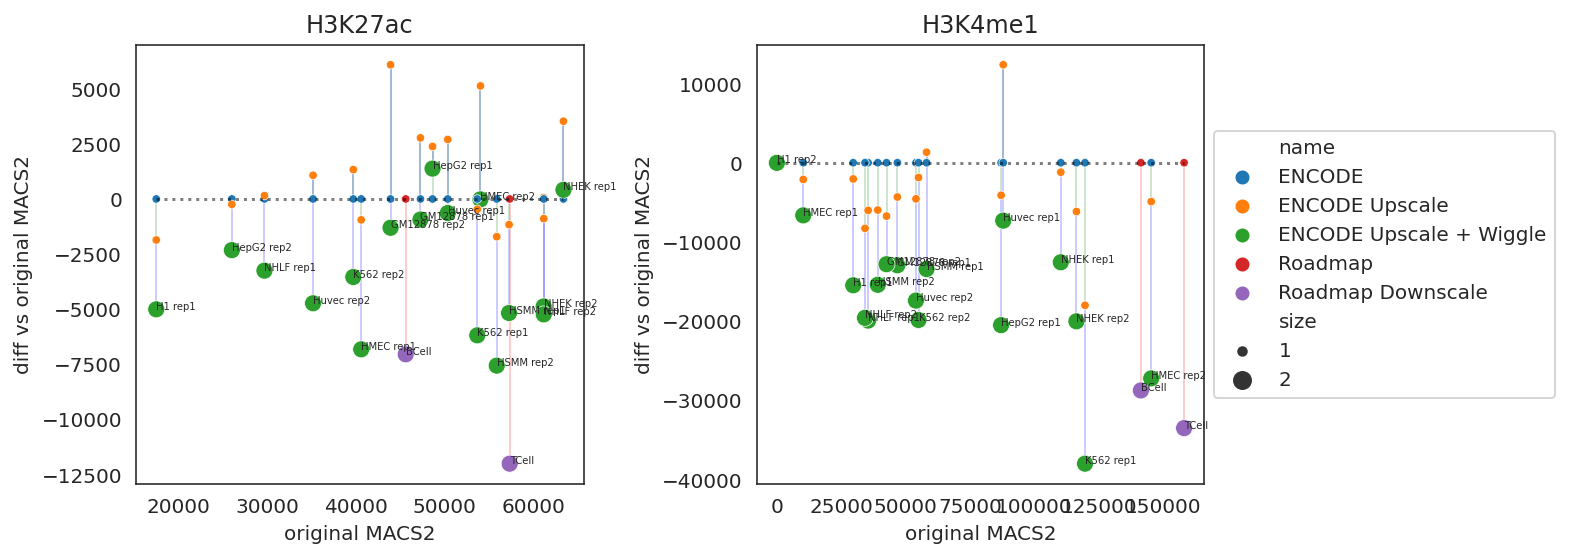

MACS2 broad


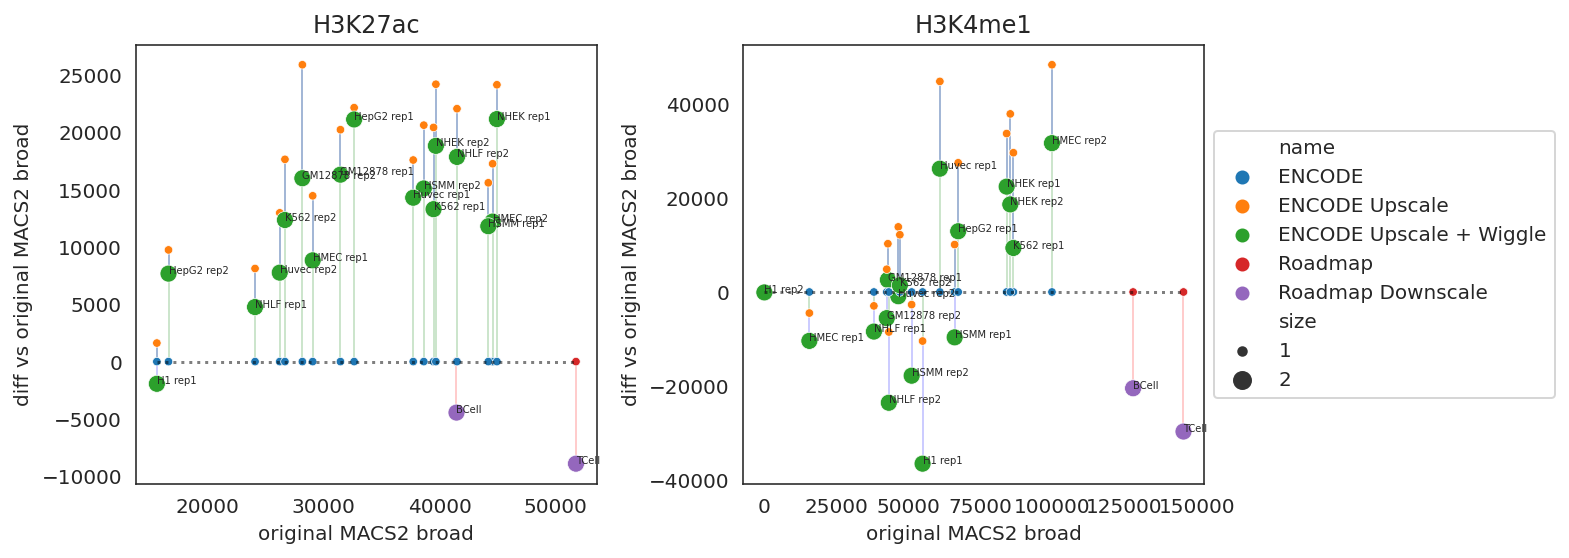

SPAN


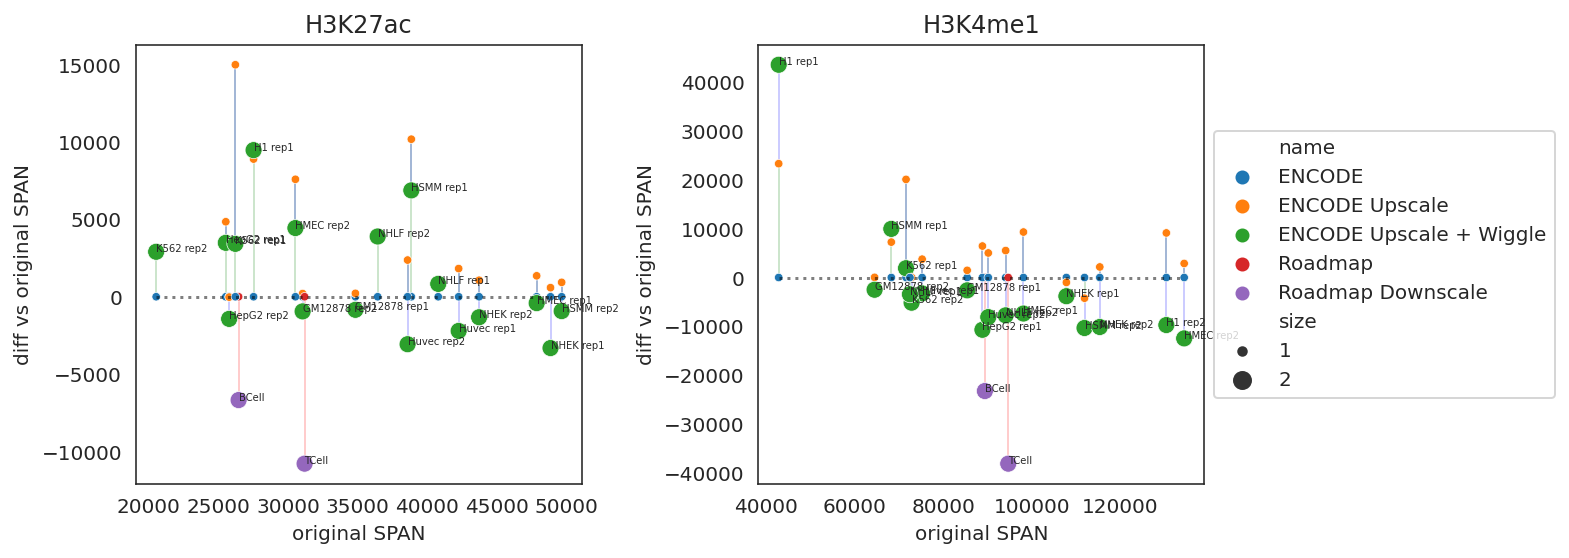

SICER


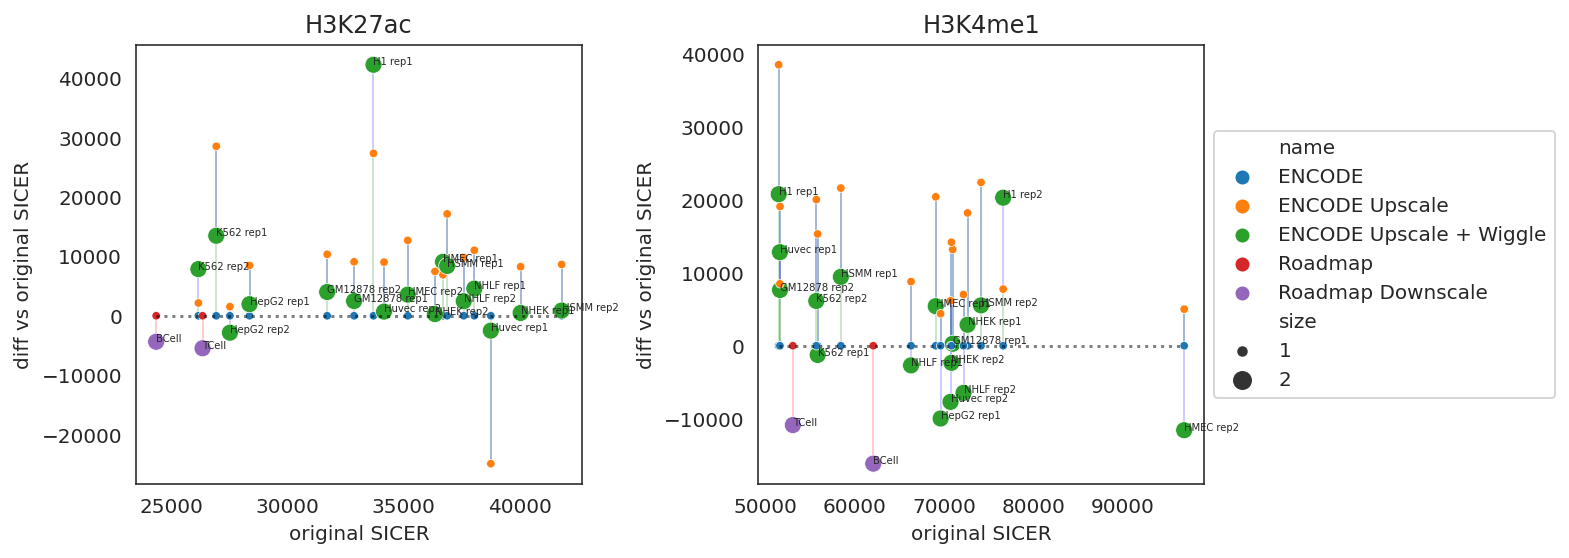

In [252]:
df = df_roughness_aggr_z
big =  ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
texts = ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
for Y in TOOLS:
    print(Y)
    plot_wiggle_dataset(df, f'original {Y}', f'diff vs original {Y}', big, texts, False, None, y0line=True)

MACS2


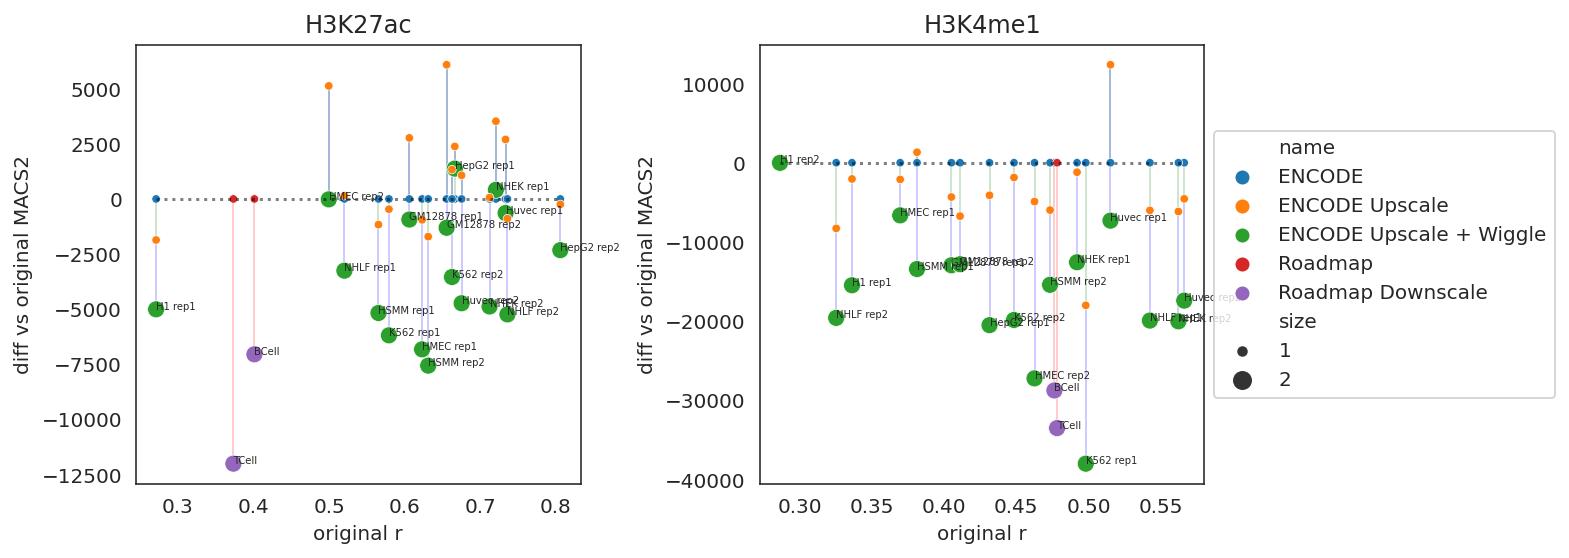

MACS2 broad


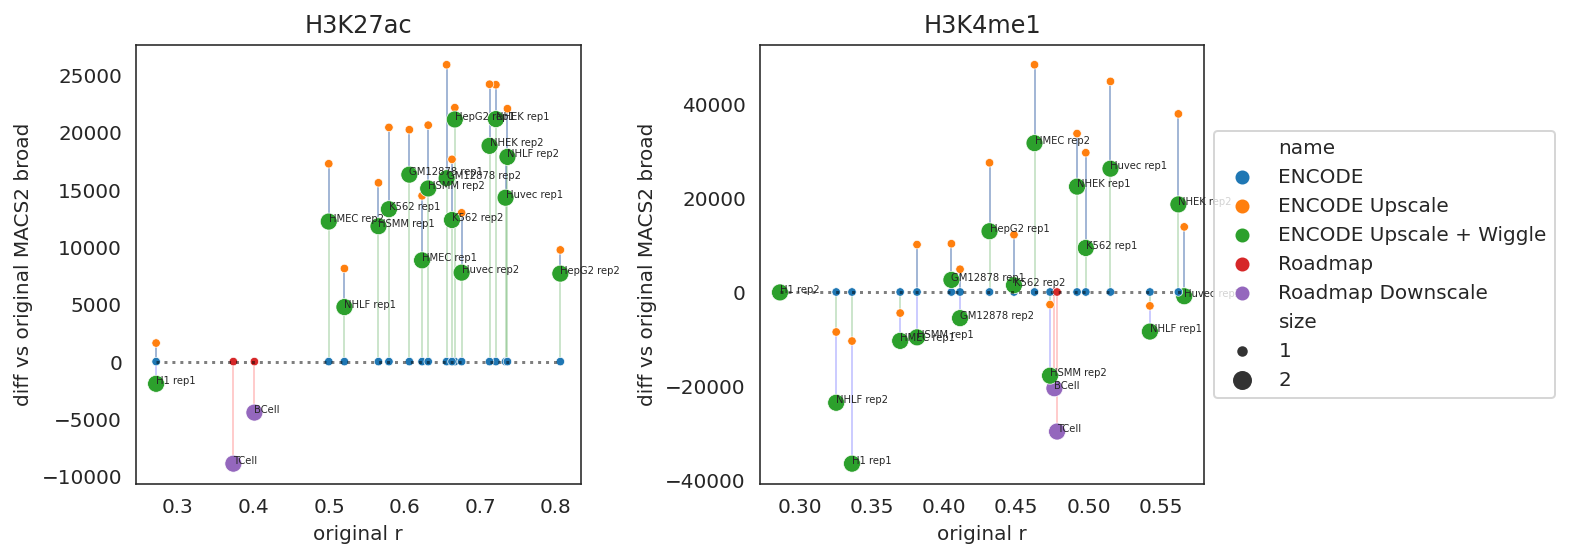

SPAN


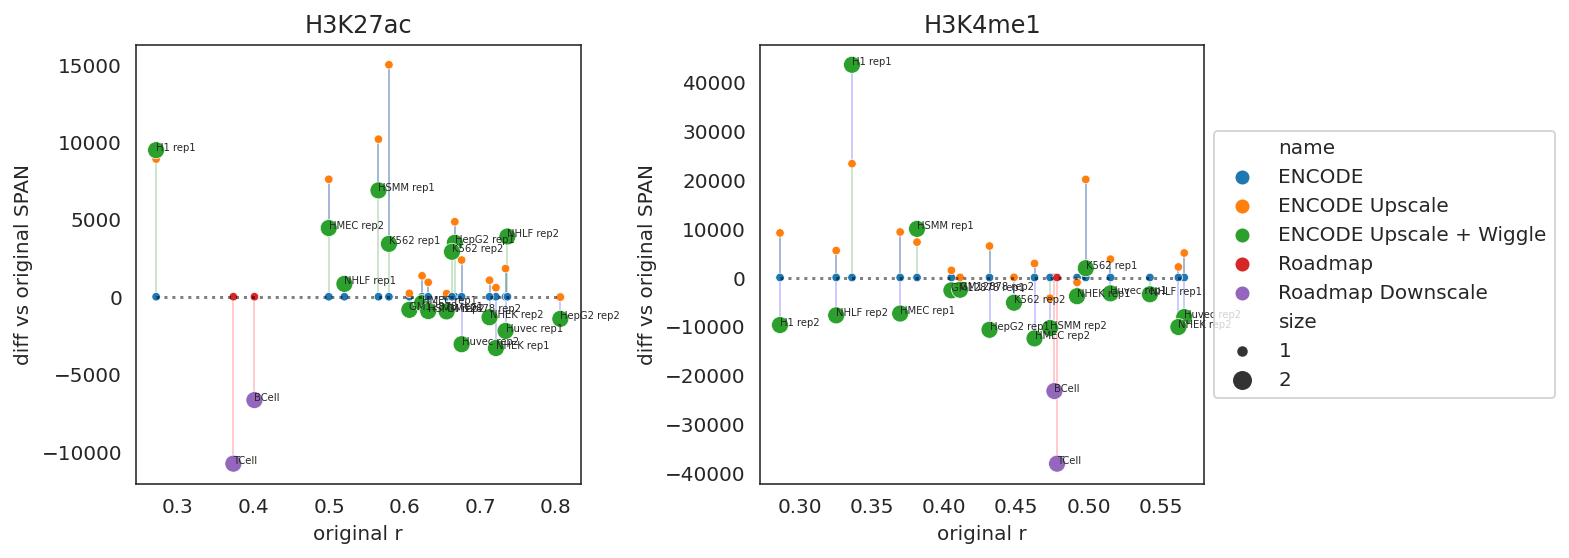

SICER


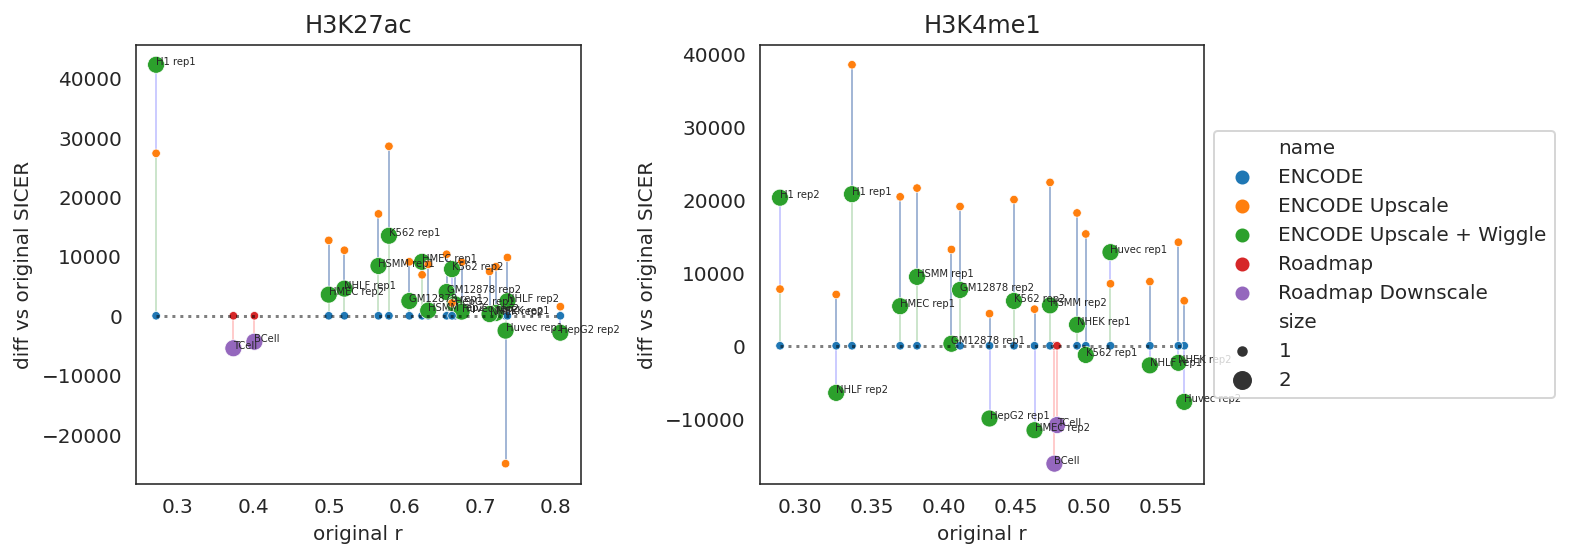

In [253]:
df = df_roughness_aggr_z
big =  ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
texts = ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
for Y in TOOLS:
    print(Y)
    plot_wiggle_dataset(df, f'original r', f'diff vs original {Y}', big, texts, False, None, y0line=True)

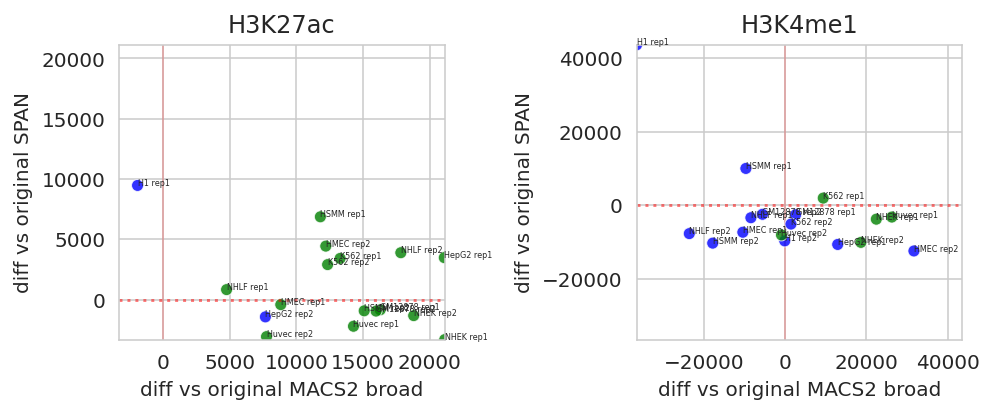

In [254]:
df = df_roughness_aggr_z[df_roughness_aggr_z['type'] == 'x2_N10_w80_20_N2000']
X = 'diff vs original MACS2 broad'
Y = 'diff vs original SPAN'
plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df[df['modification'] == m].copy()
    colors = ['green' if (row['modification'] == 'H3K27ac') & ((row['cell'], row['replicate']) in H3K27AC_SAMPLES) |
                         (row['modification'] == 'H3K4me1') & ((row['cell'], row['replicate']) in H3K4ME1_SAMPLES)
              else 'blue' for _, row in t.iterrows()]
    
    amin = min(t[X].min(), t[Y].min())
    amax = max(t[X].max(), t[Y].max())
    sns.lineplot(x=[amin, amax], y=[0, 0], color='red', ax=ax, alpha=0.5, linestyle='dotted')
    sns.lineplot(x=[0, 0], y=[amin, amax], color='red', ax=ax, alpha=0.5, linestyle='dotted')    
    
    sns.scatterplot(data=t,
                    x=X, y=Y,
                    color=colors,
                    alpha=0.8,
                    ax=ax,
                    )

    for x, y, cell, rep in zip(t[X], t[Y], t['cell'], t['replicate']):
        ax.text(x, y, f'{cell} {rep}', fontsize = 4)
    ax.title.set_text(m)

    ax.set_xlim(amin, amax)
    ax.set_ylim(amin, amax)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


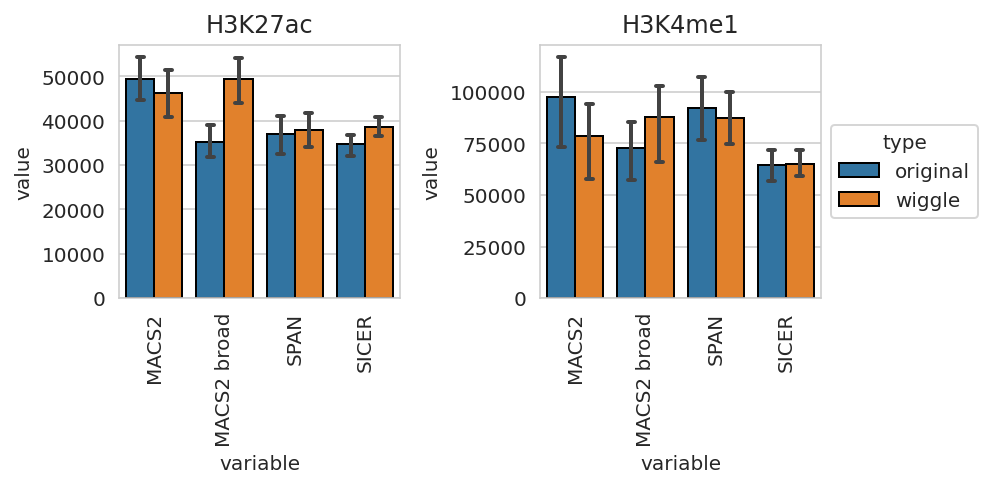

In [255]:
# df = df_roughness_aggr
df = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
                       (((df_roughness_aggr['modification'] == 'H3K27ac') &
                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
                        ((df_roughness_aggr['modification'] == 'H3K4me1') &
                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()

plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    t = df[(df['modification'] == m) &
           (df['type'].isin(['ENCODE', 'x2_N10_w80_20_N2000']))].copy()
    t = pd.melt(t, id_vars=['modification', 'cell', 'replicate', 'type'], value_vars=TOOLS).copy()
    t.loc[t['type'] == 'ENCODE', 'type'] = 'original'
    t.loc[t['type'] == 'x2_N10_w80_20_N2000', 'type'] = 'wiggle'
    
    g_results = sns.barplot(data=t,
                            x='variable', y='value', hue='type',
                            ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['original', 'wiggle'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],                            
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# OLD CODE

In [ ]:
df_peaks['name'] = df_peaks['tool']
df_peaks['type'] = 'original'

In [ ]:
wiggle_mix_peaks['name'] = wiggle_mix_peaks['tool']
wiggle_mix_peaks['type'] = 'base'

mix_rows = ['mix' in os.path.basename(f) for f in wiggle_mix_peaks['file']]
wiggle_rows = ['wiggle' in os.path.basename(f) for f in wiggle_mix_peaks['file']]
wiggle_mix_peaks.loc[mix_rows, 'name'] = wiggle_mix_peaks[mix_rows]['name'] + ' mix'
wiggle_mix_peaks.loc[mix_rows, 'type'] = 'mix'
wiggle_mix_peaks.loc[wiggle_rows, 'name'] = wiggle_mix_peaks[wiggle_rows]['name'] + ' wiggle'
wiggle_mix_peaks.loc[wiggle_rows, 'type'] = 'wiggle'

wiggle_mix_peaks.sample(3)

In [ ]:
all_wiggle_mix_peaks = pd.concat([df_peaks[(df_peaks['dataset'] != 'Roadmap') &
                                           (df_peaks['replicate'] != 'rep2') &
                                           df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])], 
                                  wiggle_mix_peaks]).reset_index(drop=True)
all_wiggle_mix_peaks.sample(3)

In [ ]:
# # Remove outliers
# display(all_wiggle_mix_peaks[(all_wiggle_mix_peaks['type'] == 'wiggle') &
#                              ((all_wiggle_mix_peaks['peaks'] < 20_000) | (all_wiggle_mix_peaks['peaks'] > 100_000))])
# all_wiggle_mix_peaks = all_wiggle_mix_peaks[
#                                             (all_wiggle_mix_peaks['peaks'] >= 20_000) & 
#                                             (all_wiggle_mix_peaks['peaks'] <= 100_000)].copy()

In [ ]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]


for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[all_wiggle_mix_peaks['modification'] == m],
                            x='tool', hue='type', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            hue_order=['original', 'wiggle', 'mix']
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]


for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[all_wiggle_mix_peaks['modification'] == m],
                            x='tool', hue='type', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['original', 'wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(7, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & 
                                                          (all_wiggle_mix_peaks['type'].isin(['original', ty]))],
                                x='tool', hue='type', y='peaks', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                hue_order=['original', ty],
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

In [ ]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(7, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & 
                                                          (all_wiggle_mix_peaks['type'].isin(['original', ty]))],
                                x='tool', hue='type', y='peaks', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                hue_order=['original', ty],
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

In [ ]:
all_wiggle_mix_peaks_fc = pd.DataFrame(columns=['modification', 'cell', 'replicate', 'tool',
                                             'peaks_original', 'type', 'peaks', 'fold-change'])
t = all_wiggle_mix_peaks[all_wiggle_mix_peaks['dataset'] == 'ENCODE']
for m, c, r, to, p in tqdm(zip(t['modification'], t['cell'], t['replicate'], t['tool'], t['peaks'])):
    print(m, c, r, to, p)
    for ty in ['wiggle', 'mix']:
        tty = all_wiggle_mix_peaks[(all_wiggle_mix_peaks['type'] == ty) &
                            (all_wiggle_mix_peaks['modification'] == m) &
                            (all_wiggle_mix_peaks['cell'] == c) &
                            (all_wiggle_mix_peaks['replicate'] == r) &
                            (all_wiggle_mix_peaks['tool'] == to)]
        if len(tty) == 0:
            continue
        pty = tty['peaks'].values[0]
        all_wiggle_mix_peaks_fc.loc[len(all_wiggle_mix_peaks_fc)] = (m, c, r, to, p, ty, pty, d(pty, p))
all_wiggle_mix_peaks_fc.sample(3)

In [ ]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(5, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.boxplot(data=all_wiggle_mix_peaks_fc[
            (all_wiggle_mix_peaks_fc['modification'] == m) & 
            (all_wiggle_mix_peaks_fc['type']==ty)],
                                x='tool', y='fold-change', ax=ax,
                                # capsize=.1, errwidth=2, edgecolor="black",
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        # if i < 1:
        #     ax.legend().set_visible(False)
        # else:
        #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, )
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & 
                                                      (all_wiggle_mix_peaks['tool'] == 'SPAN')],
                            x='type',  y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['original', 'wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) &
                                                      (all_wiggle_mix_peaks['tool'] == 'SPAN') &
                                                      (all_wiggle_mix_peaks['type'].isin(['original', 'wiggle']))],
                            x='type',  y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['original', 'wiggle'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
print('Load lengths')
ts = []
for ds, m, c, r, ty, file, tool in tqdm(zip(
        all_wiggle_mix_peaks['dataset'],
        all_wiggle_mix_peaks['modification'],
        all_wiggle_mix_peaks['cell'],
        all_wiggle_mix_peaks['replicate'],
        all_wiggle_mix_peaks['type'], all_wiggle_mix_peaks['file'], all_wiggle_mix_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = ds
    t['modification'] = m
    t['cell'] = c
    t['replicate'] = r
    t['type'] = ty
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

In [ ]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(11, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='type', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.tight_layout()
    plt.show()


In [ ]:
for ty in ['wiggle', 'mix']:
    print(ty)
    for m in ['H3K27ac', 'H3K4me1']:
        print(m)
        plt.figure(figsize=(11, 3))
        axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
        for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
            ax = axs[i]
            g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool) & (t['type'].isin(['original', ty]))],
                                     x='length', hue='type', ax=ax,
                                     stat='density', common_bins=False, common_norm=False,
                                     bins=30, kde=True, log_scale=True, alpha=0.5,
                                     )
            g_results.set(xscale='log')
            g_results.set_ylim(0, 3)
            g_results.set_xlim(200, 2e4)
            ax.title.set_text(f'{tool}')
            if i < 2:
                ax.legend().set_visible(False)
            else:
                sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

        plt.tight_layout()
        plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='type', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & 
                                    (t['tool'] == 'SPAN') & 
                                    (t['type'].isin(['original', 'wiggle']))],
                             x='length', hue='type', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
t['dataset'] = t['modification'] + ' ' + t['type']

plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(data=t[t['tool'] == tool],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 2:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
t['dataset'] = t['modification'] + ' ' + t['type']

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SPAN', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(data=t[t['tool'] == tool],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
t_aggr = t[
    ['dataset', 'modification', 'cell', 'replicate', 'type', 'tool', 'length']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'type', 'tool']).agg('mean').reset_index()
t_aggr.sample(3)

In [ ]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(5, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.boxplot(data=t_aggr[
            (t_aggr['modification'] == m) &
            (t_aggr['type']==ty)],
                                x='tool', y='length', ax=ax,
                                # capsize=.1, errwidth=2, edgecolor="black",
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        ax.set(yscale='log')
        # if i < 1:
        #     ax.legend().set_visible(False)
        # else:
        #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, )
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

## Prepare union peaks

In [ ]:
all_wiggle_mix_roadmap_peaks = pd.concat([
    df_peaks[(df_peaks['replicate'] != 'rep2') &
             df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])], 
    wiggle_mix_peaks]).reset_index(drop=True)
all_wiggle_mix_roadmap_peaks['dataset'] = [ds if ty == 'original' else ty for ds, ty in zip(all_wiggle_mix_roadmap_peaks['dataset'], all_wiggle_mix_roadmap_peaks['type'])]
all_wiggle_mix_roadmap_peaks.sample(3)

In [ ]:
# Remove outliers
display(all_wiggle_mix_roadmap_peaks[(all_wiggle_mix_roadmap_peaks['peaks'] < 20_000) | 
                                     (all_wiggle_mix_roadmap_peaks['peaks'] > 100_000)])
all_wiggle_mix_roadmap_peaks = all_wiggle_mix_roadmap_peaks[
    (all_wiggle_mix_roadmap_peaks['peaks'] >= 20_000) & 
    (all_wiggle_mix_roadmap_peaks['peaks'] <= 100_000)].copy()

In [ ]:
! mkdir -p {WD}/union

for m, ds in tqdm(product(['H3K27ac', 'H3K4me1'], ['ENCODE', 'wiggle', 'mix', 'Roadmap'])):
    print('---')
    print(m, ds)
    tmdt = all_wiggle_mix_roadmap_peaks[(all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                        (all_wiggle_mix_roadmap_peaks['dataset'] == ds)]
    if len(tmdt) == 0:
        continue
    for _, (c, r) in tmdt[['cell', 'replicate']].drop_duplicates().iterrows():
        t = tmdt[(tmdt['cell'] == c) & (tmdt['replicate'] == r)]
        if len(t) == 0:
            continue
        print(c, r)
        # Prepare total overlap
        union_path = f'{WD}/union/{m}_{c}_{r}_{ds}.bed'
        if os.path.exists(union_path):
            continue
        try:
            files = t[t['tool'] == 'SPAN']['file']
            t_span = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'MACS2']['file']
            t_macs2 = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'MACS2 broad']['file']
            t_macs2broad = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'SICER']['file']
            t_sicer = sorted_file(files.values[0]) if len(files) == 1 else ''
            tf = tempfile.mktemp()
            ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
            ! bedtools merge -i {tf} > {union_path}
            print(union_path)
        except Exception as e:
            print(e)
            break
            pass

In [ ]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}

In [ ]:
def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [ ]:
encode_bws = load_bws(GSE26320_PATH + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
encode_bws['dataset'] = 'ENCODE'
encode_bws.sample(3)

In [ ]:
immune_bws = load_bws(IMMUNE_PATH + '/bw', MODIFICATIONS, IMMUNE_CELLS, [''], 'Control')
immune_bws['dataset'] = 'Roadmap'
immune_bws.sample(3)

In [ ]:
mix_wiggle_bws = load_bws(WD + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
mix_wiggle_bws['dataset'] = ['wiggle' if 'wiggle.bw' in f else 'mix' for f in mix_wiggle_bws['file']] 
mix_wiggle_bws.sample(3)

In [ ]:
df_bws = pd.concat([encode_bws, immune_bws, mix_wiggle_bws]).reset_index(drop=True)
df_bws.sample(3)

## Compute roughness of coverage withing peaks

In [ ]:
from math import ceil
import pyBigWig

rows = []
bin = 100

t = all_wiggle_mix_roadmap_peaks[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates()
for dt, m, c, r in tqdm(zip(t['dataset'], t['modification'], t['cell'], t['replicate'])):
    if m == 'Control':
        continue
    print(dt, m, c, r)
    union_path = f'{WD}/union/{m}_{c}_{r}_{dt}.bed'
    print(union_path)
    if not os.path.exists(union_path):
        print('-')
        continue
    try:
        bw_path = df_bws[(df_bws['dataset'] == dt) &
                         (df_bws['modification'] == m) & (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        print(bw_path)
        t = pd.read_csv(union_path, sep='\t', header=None)
        t = t.sample(min(len(t), 1000))
        with pyBigWig.open(bw_path) as bw:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            print('Total coverage', total_coverage)
            for chr, start, end in zip(t[0], t[1], t[2]):
                if chr in CHROM_SIZES:
                    # Normalize by total coverage
                    stats = [c / total_coverage for c in bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True)]
                    rows.append((dt, m, c, r, f'{chr}:{start}-{end}',  len(stats), np.mean(stats), np.std(stats), np.var(stats)))
    except Exception as e:
        print(e)
        break
        pass  # Ignore

df_roughness = pd.DataFrame(rows, columns=['datatype', 'modification', 'cell', 'replicate', 'position', 'bins', 'mean', 'std', 'var'])
del rows
df_roughness.sample(5)

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_roughness[df_roughness['modification'] == m],
                            x='modification', y='var', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_roughness[df_roughness['modification'] == m],
                            x='modification', y='std', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_roughness[df_roughness['modification'] == m],
                            x='modification', y='std', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
df_roughness_aggr = df_roughness[
    ['datatype', 'modification', 'cell', 'replicate', 'var', 'std']
].groupby(['datatype', 'modification', 'cell', 'replicate']).agg('mean').reset_index()
df_roughness_aggr.sample(3)

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_roughness_aggr[df_roughness_aggr['modification'] == m],
                            x='modification', y='std', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
all_wiggle_mix_roadmap_peaks[(all_wiggle_mix_roadmap_peaks['type']=='wiggle') &
                             (all_wiggle_mix_roadmap_peaks['modification'] == 'H3K4me1') & 
                             (all_wiggle_mix_roadmap_peaks['peaks'] < 20_000)]

## Compute signal/control ratio within peaks

In [ ]:
from math import ceil
import pyBigWig

ratios = []

t = all_wiggle_mix_roadmap_peaks[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates()
for dt, m, c, r in tqdm(zip(t['dataset'], t['modification'], t['cell'], t['replicate'])):
    if m == 'Control':
        continue
    print(dt, m, c, r)
    union_path = f'{WD}/union/{m}_{c}_{r}_{dt}.bed'
    print(union_path)
    control_dt = 'Roadmap' if dt == 'Roadmap' else 'ENCODE'
    try:
        bw_path = df_bws[(df_bws['dataset'] == dt) &
                         (df_bws['modification'] == m) & (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        print(bw_path)
        bwc_path = df_bws[(df_bws['dataset'] == control_dt) &
                          (df_bws['modification'] == 'Control') & (df_bws['cell'] == c) &
                          (df_bws['replicate'] == r)]['file'].values[0]
        print(bwc_path)
        t = pd.read_csv(union_path, sep='\t', header=None)
        t = t.sample(min(len(t), 1000))
        with pyBigWig.open(bw_path) as bw:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            print('Total signal coverage', total_coverage)
            with pyBigWig.open(bwc_path) as bwc:
                # Resort top scored peaks by density and start with the most dense ones
                total_coveragec = sum(bwc.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
                print('Total control coverage', total_coveragec)

                for chr, start, end in zip(t[0], t[1], t[2]):
                    if chr in CHROM_SIZES:
                        # Normalize by total coverage
                        signal = bw.stats(chr, start, end, exact=True, type='sum')[0] / total_coverage
                        noise = bwc.stats(chr, start, end, exact=True, type='sum')[0] / total_coveragec
                        ratios.append((dt, m, c, r, f'{chr}:{start}-{end}', (signal + 1e-10) / (noise + 1e-10)))
    except:
        pass  # Ignore

df_signal_to_control = pd.DataFrame(ratios, columns=['datatype', 'modification', 'cell', 'replicate', 'position', 'signal_to_control'])
del ratios
df_signal_to_control.sample(5)

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_signal_to_control[df_signal_to_control['modification'] == m], x='modification', y='signal_to_control', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

# Signal-to-noise ratio

In [ ]:
# TODO

# Jaccard vs original peaks

In [ ]:
bench_df = pd.DataFrame(
    columns=['dataset', 'modification', 'cell', 'replicate', 'name', 'type',
             'original_peaks', 'original_peaks_len',
             'peaks', 'peaks_len', 'overlap1', 'overlap2', 'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for ds, m, c, r, tool in tqdm(
        [('ENCODE', m, c, r, tool) for m, c, r, tool in product(['H3K27ac', 'H3K4me1'], GSE26320_CELLS, GSE26320_REPS, TOOLS)] +
        [('Roadmap', m, c, r, tool) for m, c, r, tool in product(['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], TOOLS)]
):
    print(ds, m, c, r, tool)
    t = all_wiggle_mix_roadmap_peaks[
        # (all_wiggle_mix_roadmap_peaks['dataset'] == ds) &
                                     (all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                     (all_wiggle_mix_roadmap_peaks['cell'] == c) &
                                     (all_wiggle_mix_roadmap_peaks['replicate'] == r) &
                                     (all_wiggle_mix_roadmap_peaks['tool'] == tool) &
                                     (all_wiggle_mix_roadmap_peaks['type'] == 'original')]
    if len(t) == 0:
        print('-')
        continue
    original_file = sorted_file(t['file'].values[0])
    original_peaks = lines(original_file)
    original_peaks_len = int(bedl(original_file).sum())
    for ty in ['wiggle', 'mix']:
        t = all_wiggle_mix_roadmap_peaks[
            # (all_wiggle_mix_roadmap_peaks['dataset'] == ds) &
                                         (all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                         (all_wiggle_mix_roadmap_peaks['cell'] == c) &
                                         (all_wiggle_mix_roadmap_peaks['replicate'] == r) &
                                         (all_wiggle_mix_roadmap_peaks['tool'] == tool) &
                                         (all_wiggle_mix_roadmap_peaks['type'] == ty)]
        if len(t) == 0:
            print(ty, '--')
            continue
        file = sorted_file(t['file'].values[0])
        peaks = lines(file)
        peaks_len = int(bedl(file).sum())
        !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
        overlap1 = lines(tf)
        !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
        overlap2 = lines(tf)
        !bedtools intersect -a {original_file} -b {file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        bench_df.loc[len(bench_df)] = \
            (ds, m, c, r, tool, ty,
             original_peaks, original_peaks_len,
             peaks, peaks_len, overlap1, overlap2, overlap_len)

display(bench_df.sample(3))


In [ ]:
bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['original_peaks_len'], bench_df['peaks_len'], bench_df['overlap_len'])
]
bench_df.sample(1)


In [ ]:
plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['modification'] == m],
                            x='name', hue='type', y='jaccard', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(6, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=bench_df[(bench_df['type'] == ty) & (bench_df['modification'] == m)],
                                x='name', hue='type', y='jaccard', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                # hue_order=['wiggle', 'mix'],
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

## Coverage roughness (std) in peaks region example

In [ ]:
diff_bench_df = pd.DataFrame(
    columns=['dataset', 'modification', 'cell', 'replicate', 'name', 'peaks', 'peakslen', 'averagelen'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for ds, m, c, r in tqdm(
        [('ENCODE', m, c, r) for m, c, r in product(MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)] +
        [('Roadmap', m, c, r) for m, c, r in product(MODIFICATIONS, IMMUNE_CELLS, [''])]
):
    # Process single tool information
    span_file = None
    for tool in TOOLS:
        print(ds, m, c, r, tool)
        t = df_peaks[
            (df_peaks['dataset'] == ds) &
            (df_peaks['modification'] == m) &
            (df_peaks['cell'] == c) &
            (df_peaks['replicate'] == r) &
            (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        file = sorted_file(t['file'].values[0])
        peaks = lines(file)
        peaks_len = bedl(file).sum()
        average_len = d(peaks_len,  peaks)
        diff_bench_df.loc[len(diff_bench_df)] = (ds, m, c, r, tool, peaks, peaks_len, average_len) 
        if tool == 'SPAN':
            span_file = file
            
    # Processing SPAN difference
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_peaks[
            (df_peaks['dataset'] == ds) &
            (df_peaks['modification'] == m) &
            (df_peaks['cell'] == c) &
            (df_peaks['replicate'] == r) &
            (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            ! bedtools intersect {args} -e -f 0.5 -F 0.5 -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = bedl(tf).sum()
            average_len = d(peaks_len,  peaks)
            diff_bench_df.loc[len(diff_bench_df)] = (ds, m, c, r, name, peaks, peaks_len, average_len)
    
    # Processing exclusive peaks        
    for tool in TOOLS:
        t = df_peaks[
            (df_peaks['dataset'] == ds) &
            (df_peaks['modification'] == m) &
            (df_peaks['cell'] == c) &
            (df_peaks['replicate'] == r) &
            (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        other_tool_files = []
        for ot in TOOLS:
            if ot == tool:
                continue
            t = df_peaks[
                (df_peaks['dataset'] == ds) &
                (df_peaks['modification'] == m) &
                (df_peaks['cell'] == c) &
                (df_peaks['replicate'] == r) &
                (df_peaks['tool'] == ot)]
            if len(t) == 0:
                continue
            other_tool_files.append(sorted_file(t['file'].values[0]))
        other_tool_files_str = ' '.join(other_tool_files)

        ! bedtools multiinter -i {other_tool_files_str} > {tf}
        ! bedtools merge -i {tf} > {tf2}
        ! bedtools intersect -a {peaks_file} -b {tf2} -e -f 0.5 -F 0.5 -wa -v > {tf}
        peaks = lines(tf)
        peaks_len = bedl(tf).sum()
        average_len = d(peaks_len,  peaks)
        diff_bench_df.loc[len(diff_bench_df)] = (ds, m, c, r, f'{tool} only', peaks, peaks_len, average_len)

display(diff_bench_df.sample(3))

In [ ]:
diff_bench_df.to_csv(os.path.expanduser('~/data/datasets.csv'), index=False)

In [ ]:
plt.figure(figsize=(20, 8))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.barplot(data=diff_bench_df[(diff_bench_df['dataset'] == ds) &
                                               (diff_bench_df['modification']==m) &
                                               (diff_bench_df['peaks'] > 0)],
                            x='name', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    if i == 0:
        ax.set_ylabel('Peaks')
    else:
        ax.set_ylabel(None)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 8))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.barplot(data=diff_bench_df[(diff_bench_df['dataset'] == ds) &
                                               (diff_bench_df['modification']==m) &
                                               (diff_bench_df['peaks'] > 0)],
                            x='name', y='peakslen',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    if i == 0:
        ax.set_ylabel('Basepairs')
    else:
        ax.set_ylabel(None)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 8))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.boxplot(data=diff_bench_df[(diff_bench_df['dataset'] == ds) & 
                                               (diff_bench_df['modification']==m) & 
                                               (diff_bench_df['peaks'] > 0)],
                            x='name', y='averagelen',
                            ax=ax,
                            # log_scale=True,
                            # capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ]
                            )
    # ax.set(yscale='log')
    # ax.set_ylim(bottom=1e2)
    if i == 0:
        ax.set_ylabel('Average length')
    else:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)
    
plt.tight_layout()
plt.show()

## Compute signal / control coverage RPKM

In [ ]:
tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

def load_rpkms(path, bw, bwc, total_coverage, total_coveragec, n=1000):
    if lines(path) == 0:
        return []
    t = pd.read_csv(path, sep='\t', header=None)
    t = t.sample(min(len(t), n))
    
    for chr, start, end in zip(t[0], t[1], t[2]):
        if chr in CHROM_SIZES:
            # Normalize by total coverage
            signal = bw.stats(chr, start, end, exact=False, type='sum')[0] / total_coverage
            noise = bwc.stats(chr, start, end, exact=False, type='sum')[0] / total_coveragec
            yield f'{chr}:{start}-{end}', d(signal, (end - start) / 1e3), d(noise, (end - start) / 1e3)

def rpkms_to_df(rpkm_gen, ds, mod, cell, rep, name):
    positions = []
    rpkms = []
    rpkmcs = []
    for p, r, rc in rpkm_gen:
        positions.append(p)
        rpkms.append(r)
        rpkmcs.append(rc)
    t = pd.DataFrame(data={'position': positions * 3, 
                            'RPKM': rpkms + rpkmcs + [d(r, rc) for r, rc in zip(rpkms, rpkmcs)], 
                            'type': ['signal'] * len(positions) + ['control'] * len(positions) + ['signal_to_control'] * len(positions)})
    t['dataset'] = ds
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['name'] = name
    return t

ts = []

for ds, m, c, r in tqdm(
        [('ENCODE', m, c, r) for m, c, r in product(MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)] +
        [('Roadmap', m, c, r) for m, c, r in product(MODIFICATIONS, IMMUNE_CELLS, [''])]
):
    try:
        bw_path = df_bws[(df_bws['dataset'] == ds) &
                         (df_bws['modification'] == m) &
                         (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        bwc_path = df_bws[(df_bws['dataset'] == ds) &
                          (df_bws['modification'] == 'Control') &
                          (df_bws['cell'] == c) &
                          (df_bws['replicate'] == r)]['file'].values[0]
    
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            with pyBigWig.open(bwc_path) as bwc:
                print(ds, m, c, r, 'Total signal coverage', total_coverage)
                total_coveragec = sum(bwc.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
                print(ds, m, c, r, 'Total control coverage', total_coveragec)
                print('Process single tool information')
                span_file = None
                for tool in TOOLS:
                    # print(ds, m, c, r, tool)
                    t = df_peaks[
                        (df_peaks['dataset'] == ds) &
                        (df_peaks['modification'] == m) &
                        (df_peaks['cell'] == c) &
                        (df_peaks['replicate'] == r) &
                        (df_peaks['tool'] == tool)]
                    if len(t) == 0:
                        continue
                    file = sorted_file(t['file'].values[0])
                    ts.append(rpkms_to_df(load_rpkms(file, bw, bwc, total_coverage, total_coveragec), ds, m, c, r, tool))
                    if tool == 'SPAN':
                        span_file = file

                print('Processing SPAN difference')
                for tool in TOOLS:
                    if tool == 'SPAN':
                        continue
                    t = df_peaks[
                        (df_peaks['dataset'] == ds) &
                        (df_peaks['modification'] == m) &
                        (df_peaks['cell'] == c) &
                        (df_peaks['replicate'] == r) &
                        (df_peaks['tool'] == tool)]
                    if len(t) == 0:
                        continue
                    peaks_file = sorted_file(t['file'].values[0])
                    for name, args in [
                        (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                        (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
                    ]:
                        ! bedtools intersect {args} -e -f 0.5 -F 0.5 -wa -v > {tf}
                        ts.append(rpkms_to_df(load_rpkms(tf, bw, bwc, total_coverage, total_coveragec), ds, m, c, r, name))

                print('Processing exclusive peaks')        
                for tool in TOOLS:
                    t = df_peaks[
                        (df_peaks['dataset'] == ds) &
                        (df_peaks['modification'] == m) &
                        (df_peaks['cell'] == c) &
                        (df_peaks['replicate'] == r) &
                        (df_peaks['tool'] == tool)]
                    if len(t) == 0:
                        continue
                    peaks_file = sorted_file(t['file'].values[0])
                    other_tool_files = []
                    for ot in TOOLS:
                        if ot == tool:
                            continue
                        t = df_peaks[
                            (df_peaks['dataset'] == ds) &
                            (df_peaks['modification'] == m) &
                            (df_peaks['cell'] == c) &
                            (df_peaks['replicate'] == r) &
                            (df_peaks['tool'] == ot)]
                        if len(t) == 0:
                            continue
                        other_tool_files.append(sorted_file(t['file'].values[0]))
                    other_tool_files_str = ' '.join(other_tool_files)

                    ! bedtools multiinter -i {other_tool_files_str} > {tf}
                    ! bedtools merge -i {tf} > {tf2}
                    ! bedtools intersect -a {peaks_file} -b {tf2} -e -f 0.5 -F 0.5 -wa -v > {tf}
                    ts.append(rpkms_to_df(load_rpkms(tf, bw, bwc, total_coverage, total_coveragec), ds, m, c, r, f'{tool} only'))
    except:
        continue

diff_bench_coverage_df = pd.concat(ts).reset_index(drop=True)
del ts
display(diff_bench_coverage_df.sample(3))

In [ ]:
plt.figure(figsize=(24, 10))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.boxplot(data=diff_bench_coverage_df[(diff_bench_coverage_df['type'] != 'signal_to_control') & 
                                                        (diff_bench_coverage_df['dataset'] == ds) &
                                                        (diff_bench_coverage_df['modification']==m)],
                            x='name', y='RPKM', hue='type',
                            ax=ax,
                            showfliers=False,
                            # log_scale=True,
                            # capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ],
                            )
    # ax.set(yscale='log')
    # ax.set_ylim(bottom=1e2)
    if i == 0:
        ax.set_ylabel('RPKM')
    else:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(24, 10))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.boxplot(data=diff_bench_coverage_df[(diff_bench_coverage_df['type'] == 'signal_to_control') & 
                                                        (diff_bench_coverage_df['dataset'] == ds) &
                                                        (diff_bench_coverage_df['modification']==m) &
                                                        (diff_bench_coverage_df['RPKM']<1000)],
                            x='name', y='RPKM', 
                            ax=ax,
                            showfliers=False,
                            # log_scale=True,
                            # capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ],
                            )
    # ax.set(yscale='log')
    # ax.set_ylim(bottom=1e2)
    if i == 0:
        ax.set_ylabel('Signal / control')
    else:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# END